# Team members
**This work was done by:**
- **Hibah Sindi**
<br>LinkedIn: www.linkedin.com/in/hibah-sindi-5104701aa
<br>GitHub: https://github.com/hibahdesu
- **Shahad Ali Aldawsari**
<br>LinkedIn: https://www.linkedin.com/in/shahad-ali-aldawsari-711792221/
<br>GitHub: https://github.com/ShahadAliAldawsari
- **Ammar Alhawashem**
<br>LinkedIn: https://www.linkedin.com/in/ammar-alhawashem-2020/
<br>GitHub: https://github.com/AmmarHawashem


# Overview

In the face of millions of applicants, Tuwaiq Academy aims to streamline the selection process for our advanced training programs. The challenge is to develop a predictive model that can accurately identify individuals with the highest likelihood of successfully completing the rigorous training curriculum.

- Kaggle compation URL: https://www.kaggle.com/competitions/measuring-student-persistence-and-completion-rate/overview

# Key Details

* Dataset: We provide registration information for accepted trainees in a variety of training programs, including a completion target column.
* Objective: Develop a robust model to identify candidates with the best potential for successful program completion.
* Outcome: The winning models will significantly enhance the efficiency of the selection process, allowing Tuwaiq Academy to optimize resource allocation and make a lasting impact on the education landscape.

# About the Project
We will use information about previous trainees and their completion status to build the model. There are two datasets relevant to this problem: student participation data and program attempt data for each main program category.

# Methodology We investigated how to leverage features or feature combinations to extract valuable information. Here's what we did:
- **Student ID:** Excluded due to data leakage concerns. However, we indirectly utilize it (explained later).
- **Home Region & Home City:** Due to the small dataset size (~6500), Home City high variety and, presence of typos in it, we opted to use only Home Region.
- **Program ID, Program Main Category Code, & Program Sub Category Code:** We assumed Program ID represents programs held by the same organization and category code. We combined Main & Sub Category codes into a single code to reduce columns without losing information.
- **Technology Type:** High missing values (46%) and category similarity with the target variable (Y) led to exclusion. Similarly, the College column was dropped due to missing values (~60%).
- **Program Start Date & Program End Date:** We replaced these with features potentially more useful:
    - Was the program held during Ramadan?    
    - Was the program held during summer vacation?
- **Start & End month of the program- Education Specialty:** This text-based column contained inconsistencies and entries in both English & Arabic. We cleaned it using the following steps:
    - Translated all values to English.    
    - Removed extra white spaces and ensured only one space remained between words.
    - Capitalized the first letter of each word in the specialty (e.g., Information Technology).    
    - Attempted manual correction of typos.
    - Specialties with over 11 entries were saved to a list.    
    - A function replaced each value with the most similar word from the list.
    - Specialties below a user-defined threshold were converted to "Other".
- **University Degree Score & University Degree Score System:** Scores were unified into a single percentage-based system ("University_Degree_Score_100") due to the linear relationship between the original columns. Cleaning techniques were applied before and after creating this new feature.
- **Employment Status, Job Type, & Still Working:** These columns are related, but only Employment Status had a low number of missing values. We kept Employment Status and dropped the other two.
- **Age, Gender, Program Skill Level, Program Presentation Method, Completed Degree, Level of Education:** Used as it is.
- **Derived Features from Student ID:** We aimed to create a feature leveraging a student's past data to indicate their commitment. We derived the following:    
    - Number of program withdrawals divided by the total number of programs registered for (excluding withdrawals).
    - A separate feature for the total number of programs completed by each student.
    - To ensure these features reflect real-world data, we made them dynamic based on the date. For instance, if the current row is for 2/2/2023, the student's information will only be considered up to that date, even if they participated in programs later (to avoid data leakage).
Due to similar reasons, we did not use the registration table since it lacks dates and wouldn't be realistic to use information from every program record for a student.


# Duplicates & Missing Values 
- **Duplicates:**  
We addressed two types of duplicates:
    - Identical rows: Combinations of (Student ID, Program ID, Start Date) since a student cannot take the same program twice at the same time. Since we had fewer observations where Y=1 (completed program), if a duplicate existed with different Y values, we kept the Y=1 record (assuming they weren't identical).  
    - There was suspicion about duplicates with only (Student ID, Program ID), but no confirmation was received during discussions. 
 
- **Missing Values:**
    - We imputed missing values for Program Skill Level and Employment Status using a Random Forest classifier due to their relatively high number. To improve Employment Status imputation accuracy, we merged the two minority classes.  
    - Age was imputed using the median Age for the corresponding Level of Education (assuming a higher median for Ph.D. students compared to fresh graduates).  
    - Missing values in other columns were imputed using the median for numerical features and the most frequent value for categorical features.
    
# Suggestions to ensure data equality
- **We suggest to depend on selection rather than manual entering, to avoid typos especaily in the following columns:**
    - Home City
    - Education Speciality

- **In University Degree Score and University Degree Score System, we suggest the website accept only valied values**
    - In University Degree Score System == 100, the University Degree Score should be in range (60, 100).
    - In University Degree Score System == 5, the University Degree Score should be in range (2, 5).
    - In University Degree Score System == 4, the University Degree Score should be in range (1, 4).
    
# Models  
We experimented with Logistic Regression, SVM, Random Forest, XGBoost, and applyi In the grid/random search, we used a customized socre that wil lfocus in the minor class (Y=1) insteaf of the total accuracy.ng SMOTE techniques with Random Forest.


## Import Libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV
from googletrans import Translator
import time
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    make_scorer,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    average_precision_score,
    roc_curve,
    auc,
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import missingno as msno

import warnings
from thefuzz import fuzz
from thefuzz import process
warnings.filterwarnings("ignore")

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 1000)

In [24]:
import sklearn

sklearn.__version__

'1.3.1'

In [25]:
import xgboost

xgboost.__version__

'2.0.0'

## Ingest Data
- Dataset files from Kaggle: 
     https://www.kaggle.com/competitions/measuring-student-persistence-and-completion-rate/data?select=train.csv

In [26]:
Dataset = pd.read_csv("training_registration_translated_by_python.csv")
# reg = pd.read_csv("registration.csv")
# Dataset = Dataset.merge(reg, on = "Student ID")
print(Dataset.shape)
display(Dataset.sample(2))


(6500, 38)


,Student ID,Age,Gender,Home Region,Home City,Program ID,Program Main Category Code,Program Sub Category Code,Technology Type,Program Skill Level,Program Presentation Method,Program Start Date,Program End Date,Program Days,Completed Degree,Level of Education,Education Speaciality,Education Speaciality Translated,College,University Degree Score,University Degree Score System,University Degree Score_100,Employment Status,Job Type,Still Working,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total Regestration
1897,6115d594-b952-4a39-be6e-d3c16b5ee281,23.0,أنثى,منطقة الرياض,المجمعة,c8b4f6d3-7705-4373-b2e0-a110f416e893,CAUF,SWPS,NaN,NaN,عن بعد,7/31/2022,9/22/2022,54,نعم,البكالوريوس,علوم الحاسبات,Computer Science,تكنولوجيا الاتصالات والمعلومات,4.55,5.0,93.99815,غير موظف,تدريب,No,0,0,0,5,0,0,0,0,4,0,0,1,10
4949,de98438d-fdaf-4ded-b3b8-7f0962e1b5f0,32.0,ذكر,منطقة الرياض,الرياض,aee3a7b8-28ea-4b9d-963f-2f1413b81c04,PCRF,PCRF,NaN,متوسط,حضوري,10/1/2023,10/12/2023,12,نعم,البكالوريوس,علوم الحاسبات,Computer Science,تكنولوجيا الاتصالات والمعلومات,3.00,5.0,73.33200,موظف,دوام كامل,Yes,0,1,0,0,0,0,0,0,0,0,0,1,2


**train_translated_university.csv** This file is modification version of the originial one. It has the following additional columns
**Education Speaciality Translated** & **University Degree Score_100**.
<br>

- **Education Speaciality Translated** is **Education Speaciality** but with the following modifications by using Google Sheet:
- The values are translated to English  using GOOGLETRANSLATE function
- Apply TRIM & PROPER functions to remove addtional white spaces & to captilize the 1st letter of each word
<br>

**University Degree Score_100**
- Using  **University Degree Score System** & the Saudi university systems, we found linear relationships that convert each **University Degree Score** with its corresponding  **University Degree Score System** to a percentage, so all values in this column are (0, 100).

- NOTE: Now we have a version full of python, However, Trnaslate using GoogleSheet is by far faster than python free libraries

In [27]:
# function1


# --------
#!pip install googletrans

translator = Translator()

def Education_Speciality_Translation(Dataset, Translated= True):
    def translate_text(text):
        try:
            if isinstance(text, str):
                return translator.translate(text, src='ar', dest='en').text
            else:
                return np.nan
        except Exception as e:
            print(f"Translation failed: {e}", text)
            time.sleep(10)  # Wait for 10 second before retrying
            return translate_text(text)  # Retry translation
    
    Dataset['Education Speaciality_1'] = Dataset['Education Speaciality'].apply(translate_text)
    # --------
    
    
    # Applying TRIM function
    Dataset['Education Speaciality_1'] = Dataset['Education Speaciality_1'].apply(lambda x: x.strip()if isinstance(x, str) else x)
    
    # Applying PROPER function
    Dataset['Education Speaciality_1'] = Dataset['Education Speaciality_1'].apply(lambda x: x.title()if isinstance(x, str) else x)
    
    # --------
    
    # Drop the Education Speaciality Translated column
    if Translated == True:
        Dataset = Dataset.drop(columns=["Education Speaciality Translated"])
    
    # Rename Education Speaciality_1 to Education Speaciality Translated
    Dataset = Dataset.rename(columns={"Education Speaciality_1": "Education Speaciality Translated"} )
    
    # --------
    
    # Get the index of the "Education Speaciality" column
    education_specialty_index = Dataset.columns.get_loc('Education Speaciality')
    
    # Get the "Education Speaciality Translated" column
    education_specialty_translated_column = Dataset.pop('Education Speaciality Translated')
    
    # Insert the "Education Speaciality Translated" column after the "Education Speaciality" column
    Dataset.insert(education_specialty_index + 1, 'Education Speaciality Translated', education_specialty_translated_column)
    
    # # see samples
    # Dataset.sample(7)
    return Dataset


In [28]:
Dataset = Education_Speciality_Translation(Dataset)
Dataset.to_csv("final_submition_translation_df.csv", index = False)
Dataset.sample(2)


KeyboardInterrupt: 

In [29]:
Dataset = pd.read_csv("final_submition_translation_df.csv")


In [30]:
# Drop duplicate
print(Dataset.shape)
Dataset = Dataset.drop_duplicates()
print(Dataset.shape)


(6500, 38)

(6500, 38)


In [31]:
# Different type of duplicates
Dataset.duplicated(subset=["Student ID", "Program ID", "Program Start Date"]).sum()

44

In [32]:
Dataset[Dataset.duplicated(subset=["Student ID", "Program ID", "Program Start Date"], keep =False ) == True].sort_values("Student ID")

,Student ID,Age,Gender,Home Region,Home City,Program ID,Program Main Category Code,Program Sub Category Code,Technology Type,Program Skill Level,Program Presentation Method,Program Start Date,Program End Date,Program Days,Completed Degree,Level of Education,Education Speaciality,Education Speaciality Translated,College,University Degree Score,University Degree Score System,University Degree Score_100,Employment Status,Job Type,Still Working,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total Regestration
6187,008dd58a-7f04-4575-9363-e500c0e0ea60,34.0,ذكر,منطقة عسير,أبها,ee1206d8-ea7a-492e-af9d-24d6f4039e18,PCRF,PCRF,ناشئة,مبتدئ,حضوري,4/2/2023,4/6/2023,5,نعم,البكالوريوس,علوم الحاسبات,Computer Science,تكنولوجيا الاتصالات والمعلومات,3.00,5.0,73.33200,موظف,دوام كامل,Yes,0,8,0,0,1,0,0,0,1,0,0,15,25
5978,008dd58a-7f04-4575-9363-e500c0e0ea60,34.0,ذكر,منطقة عسير,أبها,ee1206d8-ea7a-492e-af9d-24d6f4039e18,PCRF,PCRF,ناشئة,مبتدئ,عن بعد,4/2/2023,4/6/2023,5,نعم,البكالوريوس,علوم الحاسبات,Computer Science,تكنولوجيا الاتصالات والمعلومات,3.00,5.0,73.33200,موظف,دوام كامل,Yes,0,8,0,0,1,0,0,0,1,0,0,15,25
1070,087dc736-b016-474c-b7b0-037569c53c05,25.0,أنثى,منطقة الرياض,الرياض,7820fea0-6794-4b09-a31c-addee650e67c,CAUF,SWPS,داعمة,مبتدئ,حضوري,5/28/2023,6/8/2023,12,نعم,البكالوريوس,تقنية المعلومات_مسار الامن السيبراني,Information Technology Is The Cybersecurity Track,NaN,4.14,5.0,88.53162,خريج,NaN,NaN,1,9,0,20,5,1,1,0,9,0,0,0,45
466,087dc736-b016-474c-b7b0-037569c53c05,25.0,أنثى,منطقة الرياض,الرياض,7820fea0-6794-4b09-a31c-addee650e67c,CAUF,SWPS,داعمة,مبتدئ,حضوري,5/28/2023,6/8/2023,12,نعم,البكالوريوس,تقنية المعلومات_مسار الامن السيبراني,Information Technology Is The Cybersecurity Track,NaN,4.14,5.0,88.53162,خريج,NaN,NaN,0,9,0,20,5,1,1,0,9,0,0,0,45
4927,087ebbb4-82ad-4a44-b2fb-b9ffe8514c37,24.0,أنثى,منطقة الرياض,الرياض,bfe7c8aa-789e-4239-8043-8e7554fa564a,TOSL,NaN,NaN,متوسط,حضوري,5/14/2023,6/22/2023,40,نعم,البكالوريوس,information technology,Information Technology,NaN,4.40,5.0,91.99820,غير موظف,NaN,NaN,0,1,2,1,2,0,0,0,5,0,0,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,f6815cc7-a86e-4024-b8d2-ad729c1f63c0,30.0,ذكر,منطقة الرياض,الرياض,321e4dc8-c3c4-4173-bca5-59a0bd9f327c,PCRF,PCRF,تقليدية,متوسط,حضوري,1/8/2023,1/19/2023,12,نعم,البكالوريوس,Mobile communication and security,Mobile Communication And Security,NaN,2.40,4.0,78.66620,موظف,NaN,NaN,1,1,0,0,1,1,0,0,0,0,0,0,3
4802,f8ace646-f4f2-4e79-8a43-a129f130f377,24.0,أنثى,منطقة الرياض,الرياض,bfe7c8aa-789e-4239-8043-8e7554fa564a,TOSL,NaN,NaN,متوسط,حضوري,5/14/2023,6/22/2023,40,نعم,البكالوريوس,تقنية المعلومات,Information Technology,تكنولوجيا الاتصالات والمعلومات,3.15,4.0,88.66595,موظف,دوام كامل,Yes,1,3,0,0,5,0,0,0,1,0,0,1,10
3712,f8ace646-f4f2-4e79-8a43-a129f130f377,24.0,أنثى,منطقة الرياض,الرياض,bfe7c8aa-789e-4239-8043-8e7554fa564a,TOSL,NaN,NaN,متوسط,حضوري,5/14/2023,6/22/2023,40,نعم,البكالوريوس,تقنية المعلومات,Information Technology,تكنولوجيا الاتصالات والمعلومات,3.15,4.0,88.66595,موظف,دوام كامل,Yes,0,3,0,0,5,0,0,0,1,0,0,1,10
3252,fa368d12-716e-4766-831b-a2d748e29220,24.0,ذكر,منطقة الرياض,الرياض,bfe7c8aa-789e-4239-8043-8e7554fa564a,TOSL,NaN,NaN,متوسط,حضوري,5/14/2023,6/22/2023,40,نعم,البكالوريوس,هندسة برمجيات,Software Engineering,NaN,3.89,5.0,85.19837,موظف,NaN,NaN,0,11,3,0,11,1,0,0,0,0,0,0,26


In [33]:
# before drping the duplicate of rows with the same "Student ID", "Program ID", "Program Start Date" columns
# We will sort the dataset by Y = 1 1st so if the same row has different Y values, we keep Y= 1 since it is the minor class
print(Dataset.shape)
Dataset.sort_values("Y", ascending = False)
Dataset = Dataset.sort_values("Y", ascending = False).drop_duplicates(subset=["Student ID", "Program ID", "Program Start Date"],keep = "first")
print(Dataset.shape)

(6500, 38)

(6456, 38)


### Cumulative_Withdrawals

We want to create a feature that uses previous data of a student since it may indicate its commitment. Therefore, we created the following formula:

(عدد مرات الإنسحاب ÷ عدد البرامج إلي سجل فيها) + عدد مرات الإنسحاب


To distinguish between a student did not withdraw and a fresh student, we created a 2nd column for the total completed programs by each student.
<br>
To make these columns real, we make them dynamic by using the date columns

In [34]:
# function2

def Withdrawals(Dataset, is_it_train = 1, train_df =None):
    if is_it_train == 1:
        # Assuming 'Program Start Date' is the column with program start dates, 'Y' is the column with withdrawal information, and 'Student ID' is the column with student IDs
        # Replace these column names with your actual column names
        
        # Sort the dataframe by 'Program Start Date'
        Dataset.sort_values(by=['Student ID', 'Program Start Date'], inplace=True)
        
        # Create new columns 'Cumulative Withdrawals', 'Cumulative Completed Programs', and 'Withdrawals_scores' initialized with zeros
        Dataset['Cumulative_Withdrawals'] = 0
        Dataset['Cumulative_Completed_Programs'] = 0
        Dataset['Withdrawals_scores'] = 0
        
        # Iterate through each row
        for index, row in Dataset.iterrows():
            # Filter rows where the Student ID is the same and the Program Start Date is less than the current row's date
            previous_data = Dataset.loc[(Dataset['Student ID'] == row['Student ID']) & (Dataset['Program Start Date'] < row['Program Start Date'])]
            
            # Update the 'Cumulative Withdrawals' column with the sum of previous withdrawals for the student
            Dataset.at[index, 'Cumulative_Withdrawals'] = previous_data['Y'].sum()
            
            # Update the 'Cumulative Completed Programs' column with the sum of previous completed programs for the student
            Dataset.at[index, 'Cumulative_Completed_Programs'] = (previous_data['Y'] == 0).sum()
            
            # Calculate the total participation as Cumulative_Withdrawals + Cumulative_Completed_Programs
            total_participation = Dataset.at[index, 'Cumulative_Withdrawals'] + Dataset.at[index, 'Cumulative_Completed_Programs']
            
            # Update the 'Withdrawals_scores' with the calculated value, replacing NaN with 0
            Dataset.at[index, 'Withdrawals_scores'] = (Dataset.at[index, 'Cumulative_Withdrawals'] / total_participation) + Dataset.at[index, 'Cumulative_Withdrawals']
            Dataset['Withdrawals_scores'] = Dataset['Withdrawals_scores'].fillna(0)
        
        # If you want to reset the index after sorting, you can use the following line
        # df.reset_index(drop=True, inplace=True)
        Dataset = Dataset.drop(columns=["Cumulative_Withdrawals"])
        Dataset.sample(3)
        # Display the resulting dataframe
        return (Dataset)
    
    elif is_it_train == 0:
        train_df = train_df.rename(columns={'Student_ID':'Student ID',
                        "Program_Start_Date":'Program Start Date',
                                 "Program_ID" : "Program ID"})
        train_df['Program Start Date'] = pd.to_datetime(train_df['Program Start Date'])

        for index, row in Dataset.iterrows():
            student_id = row['Student ID']
            program_date = row['Program Start Date']
    
            previous_data = train_df.loc[(train_df['Student ID'] == student_id) & (train_df['Program Start Date'] < program_date)]
            cumulative_withdrawals = previous_data['Y'].sum()
            cumulative_completed_programs = (previous_data['Y'] == 0).sum()
    
            Dataset.at[index, 'Cumulative_Withdrawals'] = cumulative_withdrawals
            Dataset.at[index, 'Cumulative_Completed_Programs'] = cumulative_completed_programs
    
            total_participation = cumulative_withdrawals + cumulative_completed_programs
            Dataset.at[index, 'Withdrawals_scores'] = (cumulative_withdrawals / total_participation) + cumulative_withdrawals
            Dataset['Withdrawals_scores'] = Dataset['Withdrawals_scores'].fillna(0)
    
        Dataset = Dataset.drop(columns=["Cumulative_Withdrawals"])
        
        return Dataset
        


In [35]:
Dataset = Withdrawals(Dataset)
Dataset.sample(7)

,Student ID,Age,Gender,Home Region,Home City,Program ID,Program Main Category Code,Program Sub Category Code,Technology Type,Program Skill Level,Program Presentation Method,Program Start Date,Program End Date,Program Days,Completed Degree,Level of Education,Education Speaciality,Education Speaciality Translated,College,University Degree Score,University Degree Score System,University Degree Score_100,Employment Status,Job Type,Still Working,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total Regestration,Cumulative_Completed_Programs,Withdrawals_scores
4842,37cf237d-5c8a-401b-be54-9c4afd80c880,37.0,ذكر,منطقة الرياض,الرياض,6432991a-ddb5-45ca-95fc-d9e8d696be85,CAUF,SWPS,تقليدية,مبتدئ,عن بعد,10/23/2022,10/27/2022,5,نعم,الماجستير,هندسة كهربائية,Electrical Engineering,NaN,3.83,4.0,97.73239,موظف,NaN,NaN,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0.0
3587,a6504c2a-b727-4e24-bd31-bf432b60ff3b,25.0,أنثى,منطقة الرياض,الرياض,b0ee753e-5f35-4dc8-ae46-03af557569c0,APMR,NaN,NaN,متوسط,حضوري,5/7/2023,5/18/2023,12,نعم,البكالوريوس,Mathematics,Mathematics,NaN,4.91,5.0,98.79803,موظف,NaN,NaN,0,1,0,8,3,0,0,0,8,0,0,0,20,0,0.0
1643,072bafb0-4471-4c3b-bf10-2be0ecaa840f,26.0,ذكر,منطقة مكة المكرمة,جدة,dd948935-4e37-4454-81f2-13d75c10cd69,PCRF,PCRF,NaN,NaN,عن بعد,4/2/2023,4/6/2023,5,نعم,البكالوريوس,Information Technology,Information Technology,NaN,3.30,4.0,90.66590,خريج,NaN,NaN,0,1,0,1,0,0,0,0,0,0,0,0,2,0,0.0
3898,d54e4041-d8f4-4ae3-b465-e28f232c8d51,26.0,أنثى,منطقة الرياض,الرياض,268677b0-7229-4252-9e62-04ae0f7dfeca,DTFH,NaN,ناشئة,مبتدئ,حضوري,8/14/2022,8/18/2022,5,نعم,البكالوريوس,علوم الحاسبات,Computer Science,NaN,3.80,5.0,83.99840,غير موظف,NaN,NaN,0,0,0,4,0,0,0,0,0,0,0,0,4,0,0.0
128,c4806b80-0ce1-42a5-831c-f7577b59ceba,22.0,أنثى,منطقة الرياض,الرياض,bfe7c8aa-789e-4239-8043-8e7554fa564a,TOSL,NaN,NaN,متوسط,حضوري,5/14/2023,6/22/2023,40,نعم,البكالوريوس,information technology,Information Technology,NaN,4.78,5.0,97.06474,خريج,NaN,NaN,1,0,2,1,2,0,0,0,2,0,0,0,7,0,0.0
2672,66978fee-8ceb-47b4-a23a-b302ffbe0e48,31.0,ذكر,منطقة الرياض,الرياض,d0f06377-196d-486c-bad8-15c04f8cdad3,PCRF,PCRF,ناشئة,مبتدئ,عن بعد,8/6/2023,8/10/2023,5,نعم,الماجستير,إدارة الأعمال,Business Management,الأعمال والإدارة والقانون,4.62,5.0,94.93146,غير موظف,دوام كامل,No,0,2,0,0,0,0,0,0,0,0,0,1,3,2,0.0
4965,10faea0d-1392-47f8-bb89-7fed48975dc2,20.0,أنثى,منطقة الرياض,الرياض,aee3a7b8-28ea-4b9d-963f-2f1413b81c04,PCRF,PCRF,NaN,متوسط,عن بعد,7/23/2023,8/3/2023,12,نعم,البكالوريوس,كلية الاقتصاد والعلوم الادارية - نظم معلومات ا...,College Of Economics And Administrative Scienc...,NaN,NaN,NaN,NaN,طالب,NaN,NaN,0,0,1,13,4,0,0,0,1,0,0,0,19,2,0.0


In [36]:
# Create a copy before manipulation
df = Dataset.copy()

# EDA

In [37]:
Dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,6370.0,26.823391,5.540475,18.0,23.00000,25.000000,29.0000,57.0000
Program Days,6456.0,19.620973,32.211052,3.0,5.00000,12.000000,19.0000,292.0000
University Degree Score,6381.0,8.244320,19.154637,0.0,3.30000,4.000000,4.5100,100.0000
University Degree Score System,6381.0,9.782479,21.275385,4.0,5.00000,5.000000,5.0000,100.0000
University Degree Score_100,6380.0,87.515455,19.409304,0.0,82.79918,87.471646,94.6648,1350.6334
Y,6456.0,0.160936,0.367500,0.0,0.00000,0.000000,0.0000,1.0000
PCRF,6456.0,1.839839,3.346973,0.0,0.00000,0.000000,2.0000,27.0000
GRST,6456.0,0.282528,0.614651,0.0,0.00000,0.000000,0.0000,4.0000
CAUF,6456.0,2.951518,4.465720,0.0,0.00000,1.000000,4.0000,45.0000
INFA,6456.0,0.919300,1.635345,0.0,0.00000,0.000000,1.0000,13.0000


In [38]:
Dataset.describe(include="O").T

,count,unique,top,freq
Student ID,6456,5196,415cfcb1-8dfa-459d-b719-d942cc5e19e1,9
Gender,6456,2,أنثى,3632
Home Region,6454,13,منطقة الرياض,4705
Home City,6454,92,الرياض,4642
Program ID,6456,223,ab263106-20a8-42aa-9626-278e62ae3a49,131
Program Main Category Code,6456,10,CAUF,2338
Program Sub Category Code,5552,11,SWPS,1773
Technology Type,3518,3,تقليدية,2651
Program Skill Level,4812,3,متوسط,2083
Program Presentation Method,6456,2,حضوري,4884


In [39]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>

Index: 6456 entries, 70 to 694

Data columns (total 40 columns):

 #   Column                            Non-Null Count  Dtype  

---  ------                            --------------  -----  

 0   Student ID                        6456 non-null   object 

 1   Age                               6370 non-null   float64

 2   Gender                            6456 non-null   object 

 3   Home Region                       6454 non-null   object 

 4   Home City                         6454 non-null   object 

 5   Program ID                        6456 non-null   object 

 6   Program Main Category Code        6456 non-null   object 

 7   Program Sub Category Code         5552 non-null   object 

 8   Technology Type                   3518 non-null   object 

 9   Program Skill Level               4812 non-null   object 

 10  Program Presentation Method       6456 non-null   object 

 11  Program Start Date                6456 non-null   object 


In [40]:
# missing values
Dataset.isnull().sum().sort_values().tail(18)

Program Days                           0
Program End Date                       0
Home Region                            2
Home City                              2
Level of Education                    21
University Degree Score               75
University Degree Score System        75
University Degree Score_100           76
Age                                   86
Education Speaciality Translated     271
Education Speaciality                271
Employment Status                    551
Program Sub Category Code            904
Program Skill Level                 1644
Technology Type                     2938
College                             3836
Job Type                            4503
Still Working                       4503
dtype: int64

In [41]:
# Duplicated values
Dataset.duplicated().sum()


0

[Text(0, 0, '5417'), Text(0, 0, '1039')]

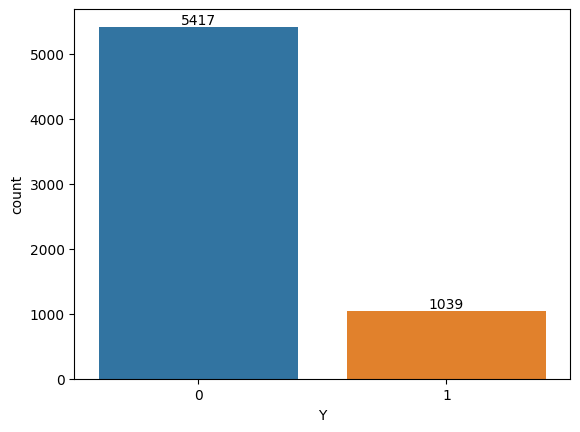

In [42]:
ax = sns.countplot(x='Y', data=Dataset)
ax.bar_label(ax.containers[0])

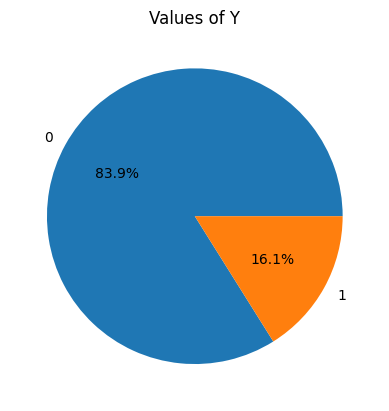

In [43]:
y_counts = Dataset['Y'].value_counts()

# Create the pie chart using matplotlib
plt.pie(y_counts, labels=y_counts.index, autopct='%1.1f%%')

# Set the title
plt.title('Values of Y')

# Show the plot
plt.show()

#As we can see, we are going to deal with unbalanced data

<Axes: >

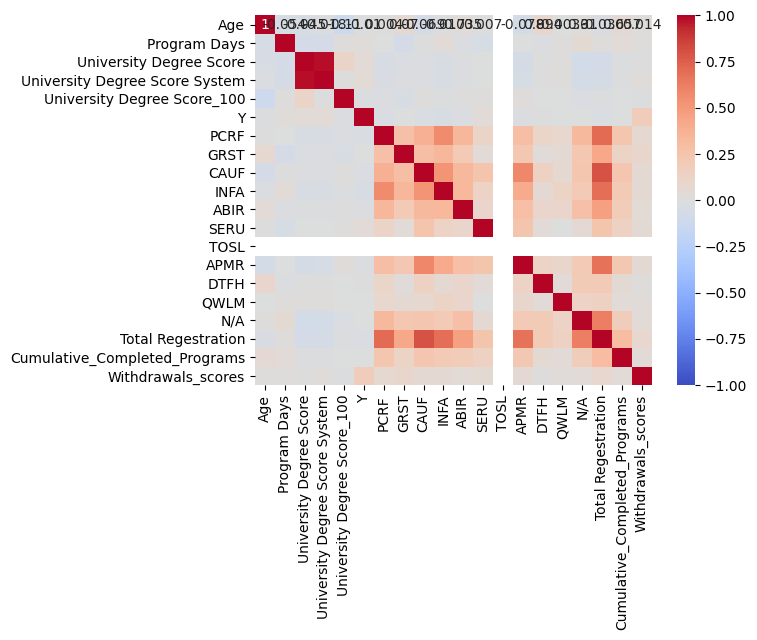

In [44]:
sns.heatmap(Dataset.select_dtypes('number').corr(),vmin=-1, vmax=1, annot=True, cmap="coolwarm" )

# DATA Preprocessing

In [45]:
Dataset.head()

,Student ID,Age,Gender,Home Region,Home City,Program ID,Program Main Category Code,Program Sub Category Code,Technology Type,Program Skill Level,Program Presentation Method,Program Start Date,Program End Date,Program Days,Completed Degree,Level of Education,Education Speaciality,Education Speaciality Translated,College,University Degree Score,University Degree Score System,University Degree Score_100,Employment Status,Job Type,Still Working,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total Regestration,Cumulative_Completed_Programs,Withdrawals_scores
70,001a2d9a-54ee-4ae9-91b4-d6fe03c98ce0,29.0,ذكر,منطقة الرياض,الرياض,e94942dd-8684-4746-97ae-df567b9b0a4a,PCRF,PCRF,NaN,مبتدئ,حضوري,5/14/2023,5/25/2023,12,لا,البكالوريوس,هندسة الكترونيات,Electronics Engineering,NaN,3.82,5.0,84.26506,موظف,NaN,NaN,1,0,0,2,0,0,0,0,1,0,0,0,3,0,0.0
4629,00235747-dd1a-4f59-be5b-4aeb66e037a1,20.0,أنثى,منطقة الرياض,الرياض,cbbba769-bb8f-43f2-a24d-8ac13a74caff,CAUF,CRDP,NaN,مبتدئ,حضوري,7/23/2023,7/27/2023,5,لا,الدبلوم,ادارة فعاليات,Event Management,NaN,4.37,5.0,91.59821,خريج,NaN,NaN,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0.0
2104,00252da1-947b-4116-a096-852830ac0f89,20.0,أنثى,منطقة الرياض,الرياض,28730cba-4bc2-4eb8-84ce-3002895e600d,APMR,KLTM,ناشئة,متوسط,حضوري,7/9/2023,8/3/2023,26,نعم,البكالوريوس,تقنية المعلومات,Information Technology,تكنولوجيا الاتصالات والمعلومات,5.00,5.0,99.99800,طالب,NaN,NaN,0,0,0,1,1,0,0,0,1,0,0,7,10,0,0.0
3765,002e4e76-d10d-47eb-a4db-3fa9f39e47dd,34.0,أنثى,منطقة الرياض,الدلم,6432991a-ddb5-45ca-95fc-d9e8d696be85,CAUF,SWPS,تقليدية,مبتدئ,عن بعد,10/23/2022,10/27/2022,5,نعم,البكالوريوس,نظم المعلومات,Information Systems,تكنولوجيا الاتصالات والمعلومات,92.00,100.0,92.00000,NaN,NaN,NaN,1,0,0,7,0,0,0,0,5,0,0,6,18,0,0.0
4119,002e4e76-d10d-47eb-a4db-3fa9f39e47dd,34.0,أنثى,منطقة الرياض,الدلم,0a189924-a682-4deb-80c9-5525ebd2b9da,CAUF,SWPS,NaN,NaN,عن بعد,12/4/2022,12/22/2022,19,نعم,البكالوريوس,نظم المعلومات,Information Systems,تكنولوجيا الاتصالات والمعلومات,92.00,100.0,92.00000,NaN,NaN,NaN,0,0,0,7,0,0,0,0,5,0,0,6,18,0,2.0


In [46]:
Dataset.columns

Index(['Student ID', 'Age', 'Gender', 'Home Region', 'Home City', 'Program ID', 'Program Main Category Code', 'Program Sub Category Code', 'Technology Type', 'Program Skill Level', 'Program Presentation Method', 'Program Start Date', 'Program End Date', 'Program Days', 'Completed Degree', 'Level of Education', 'Education Speaciality', 'Education Speaciality Translated', 'College', 'University Degree Score', 'University Degree Score System', 'University Degree Score_100', 'Employment Status', 'Job Type', 'Still Working', 'Y', 'PCRF', 'GRST', 'CAUF', 'INFA', 'ABIR', 'SERU', 'TOSL', 'APMR', 'DTFH', 'QWLM', 'N/A', 'Total Regestration', 'Cumulative_Completed_Programs', 'Withdrawals_scores'], dtype='object')

In [47]:
# function3

def Adjust_Column_Name(Dataset):
    Dataset.columns = Dataset.columns.str.replace(' ', '_')
    return Dataset

In [48]:
Dataset = Adjust_Column_Name(Dataset)
Dataset.sample(2)

,Student_ID,Age,Gender,Home_Region,Home_City,Program_ID,Program_Main_Category_Code,Program_Sub_Category_Code,Technology_Type,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality,Education_Speaciality_Translated,College,University_Degree_Score,University_Degree_Score_System,University_Degree_Score_100,Employment_Status,Job_Type,Still_Working,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total_Regestration,Cumulative_Completed_Programs,Withdrawals_scores
3205,4434b9d8-ee61-46ba-9c90-0fe134ee7fef,24.0,أنثى,منطقة الرياض,الرياض,8e451dd2-2726-46fc-9e4d-b356ad1cd96e,APMR,SRTA,NaN,NaN,حضوري,3/26/2023,4/13/2023,19,نعم,البكالوريوس,علوم حاسب,Computer Science,NaN,4.53,5.0,93.73149,موظف,NaN,NaN,1,1,0,10,2,0,0,0,10,0,0,0,23,1,0.0
194,5d94f82b-8f72-4768-8cab-ad0d84175057,37.0,ذكر,منطقة القصيم,بريدة,ce3562c8-8d27-4ffb-8dfc-e1dd4527b32a,PCRF,PCRF,تقليدية,مبتدئ,عن بعد,1/15/2023,1/19/2023,5,لا,البكالوريوس,علوم حاسب,Computer Science,NaN,3.76,5.0,83.46508,موظف,NaN,NaN,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0.0


## Date

The idea is to get rid of the two dates columns, after create from them two features which are:
- was the program  held in Ramadan month or not
- was the program  held in the summer vacation or not

In [49]:
Dataset["Program_Start_Date"].value_counts()

Program_Start_Date
4/2/2023      344
7/23/2023     285
7/16/2023     266
5/14/2023     248
3/5/2023      244
             ... 
9/18/2022      16
12/17/2023     16
8/28/2022      16
9/21/2022      15
1/15/2024      15
Name: count, Length: 77, dtype: int64

In [50]:
# to extract the oldest & neweset programs' dates
Dataset["Program_Start_Date"].describe()

count         6456
unique          77
top       4/2/2023
freq           344
Name: Program_Start_Date, dtype: object

In [51]:
# function4 
def date(Dataset):
    Dataset["Program_Start_Date"] = Dataset["Program_Start_Date"].astype('datetime64[ns]')
    Dataset["Program_End_Date"] = Dataset["Program_End_Date"].astype('datetime64[ns]')
    #--------------- Is_Ramadan
    # Just one year was in Ramadan (1444 H) 
    # it was between 2023/03/23 & 2023/04/21
    # Define the start and end dates for Ramadan
    ramadan_start = pd.Timestamp('2023-03-23')
    ramadan_end = pd.Timestamp('2023-04-21')
    # Create the new column where the program starts or end in ramadan
    Dataset['Is_ramadan_s'] = (Dataset['Program_Start_Date'].between(ramadan_start, ramadan_end)).astype(int)
    Dataset['Is_ramadan_t'] = (Dataset['Program_End_Date'].between(ramadan_start, ramadan_end)).astype(int)
    
    # add them in one column and delte the prevouis two 
    Dataset['Is_ramadan'] = Dataset['Is_ramadan_s'] + Dataset['Is_ramadan_t']
    
    # if two it means the program starts & ends in ramadan, we will just see if any day as in ramadan
    Dataset['Is_ramadan'] = Dataset['Is_ramadan'].replace(2,1)
    
    Dataset.drop(columns=['Is_ramadan_t','Is_ramadan_s'], inplace = True)
    #--------------------- Is_Summer
    # Define the start and end dates for Ramadan 
    # Just one summer vacation 
    # it was between 2023/07/06 & 2023/08/20
    summer_start = pd.Timestamp('2023-07-06')
    summer_end = pd.Timestamp('2023-08-20')
    
    # Create the new column where the program starts or end in ramadan
    Dataset['Is_summer_s'] = (Dataset['Program_Start_Date'].between(summer_start, summer_end)).astype(int)
    Dataset['Is_summer_e'] = (Dataset['Program_End_Date'].between(summer_start, summer_end)).astype(int)
    
    # add them in one column and delte the prevouis two 
    Dataset['Is_summer'] = Dataset['Is_summer_s'] + Dataset['Is_summer_e'] 
    
    # if two it means the program starts & ends in ramadan, we will just see if any day as in ramadan
    Dataset['Is_summer'] = Dataset['Is_summer'].replace(2,1)
    
    Dataset.drop(columns=['Is_summer_s','Is_summer_e'], inplace = True)
    # -----------------------
    Dataset["start_month"] = Dataset["Program_Start_Date"].dt.month
    Dataset["end_month"] = Dataset["Program_End_Date"].dt.month
    # -----------------------
    
    return Dataset

In [52]:
Dataset = date(Dataset)
Dataset.sample(2)

,Student_ID,Age,Gender,Home_Region,Home_City,Program_ID,Program_Main_Category_Code,Program_Sub_Category_Code,Technology_Type,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality,Education_Speaciality_Translated,College,University_Degree_Score,University_Degree_Score_System,University_Degree_Score_100,Employment_Status,Job_Type,Still_Working,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total_Regestration,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month
4421,1a43882f-5b6b-474e-9bcb-3742cccc0f53,32.0,أنثى,منطقة الرياض,الرياض,120fdcdc-7390-415a-99a4-18eb542343e1,CAUF,ERST,تقليدية,متوسط,عن بعد,2023-06-04,2023-06-15,12,لا,البكالوريوس,الأدب,Literature,الفنون والعلوم الإنسانية,3.40,5.0,78.66520,غير موظف,دوام كامل,No,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0,0,6,6
3056,bbafa07c-44ad-40b6-b613-d2081ee3a5b2,22.0,أنثى,منطقة الرياض,الرياض,a8841902-da19-4b48-8243-386ae61246ec,APMR,NaN,ناشئة,متقدم,عن بعد,2023-09-03,2023-09-07,5,نعم,البكالوريوس,Statistics,Statistics,NaN,3.32,5.0,77.59856,خريج,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0,0,9,9


### Ramadan

In [53]:
# Check distribution of the new variable
Is_Ramadan = pd.crosstab(Dataset["Is_ramadan"], Dataset["Y"]).T
Is_Ramadan

Is_ramadan,0,1
Y,,
0,4946,471
1,881,158


In [54]:
percentage_distribution = Is_Ramadan.div(Is_Ramadan.sum(axis=0), axis=1) * 100

# Display the percentage distribution
percentage_distribution

Is_ramadan,0,1
Y,,
0,84.880728,74.880763
1,15.119272,25.119237


In [55]:
nRC =  Is_Ramadan.iloc[0,0]
RC = Is_Ramadan.iloc[0,1]
RnC = Is_Ramadan.iloc[1,1]
nRnC = Is_Ramadan.iloc[1,0]
no_complete_in_ramadan = RnC / (RC+RnC)*100 
no_complete_NOT_in_ramadan = nRnC / (nRnC+nRC) * 100

In [56]:
print(" percentage of students did not complete in NOT Ramadan", round(no_complete_NOT_in_ramadan,2),
      "\n",
     "percentage of students did not complete in Ramadan", round(no_complete_in_ramadan,2))
print("Student associates with more withdrawals in Ramadan")

 percentage of students did not complete in NOT Ramadan 15.12 

 percentage of students did not complete in Ramadan 25.12

Student associates with more withdrawals in Ramadan


### Summer vacation

In [57]:
# Check distribution of the new variable
Is_Summer = pd.crosstab(Dataset["Is_summer"], Dataset["Y"]).T
Is_Summer

Is_summer,0,1
Y,,
0,4591,826
1,948,91


In [58]:
percentage_distribution = Is_Summer.div(Is_Summer.sum(axis=0), axis=1) * 100

# Display the percentage distribution
percentage_distribution

Is_summer,0,1
Y,,
0,82.884997,90.076336
1,17.115003,9.923664


In [59]:
nSC =  Is_Summer.iloc[0,0]
SC = Is_Summer.iloc[0,1]
SnC = Is_Summer.iloc[1,1]
nSnC = Is_Summer.iloc[1,0]
no_complete_in_summer = SnC / (SC+SnC)*100 
no_complete_NOT_in_summer = nSnC / (nSnC+nSC) * 100

In [60]:
print(" percentage of students did not complete in NOT Summer", round(no_complete_NOT_in_summer,2),
      "\n",
     "percentage of students did not complete in Summer", round(no_complete_in_summer,2))
print("Student associates with LESS withdrawals in Summer")

 percentage of students did not complete in NOT Summer 17.12 

 percentage of students did not complete in Summer 9.92

Student associates with LESS withdrawals in Summer


## Education Speciality

### Clean

based on unique values, found the most mistakes (some of them due to the translation)

In [61]:
# function5
def Education_Speciality_Cleaning(to_clean, train_df, threshold, is_it_train):

    # 1 Cyber Security
    to_clean["Education_Speaciality_Translated"].replace(["Information Technology - Siprani Security","Information Technology - Cyber ​​Security","Information Technology - Cybersecurity","Computer Science- Cyber ​​Security","Computer Science - Cyber ​​Security","It Cybersecurity","Sabrani Security","Cybersecurity Engineering","Siprani Security", "Cybersecurity", "Applied Computing Cyber ​​Security Path", "Applied Computing Cyber ​​Security Track", "Cyber ​​Security"], "Cyber Security", inplace= True)   
    to_clean["Education_Speaciality_Translated"].replace(["It Cyber ​​Security Track","Information Systems - Cyblessecuryment","Information Technology-Massar Cyber ​​Security", "Cyber ​​And Digital Security Security", "Cyber ​​Forensics And Information Security", "Cyber ​​Forensics And Information System", "Cyber ​​Security And Digital Evidence", "Cyber ​​Security And Networks", "Cyber ​​Security Computer Science", "Cyber ​​Security Path Technology", "Cybersecurity And Info Assuance", "Cybersecurity And Networking"], "Cyber Security", inplace= True)    
    
    # 2 Information Technology
    to_clean["Education_Speaciality_Translated"].replace(["Information Technology Science","Information Technology It","Information Tehnology","Information Technology-It","Information Technology (No University Student To Put My Expected Graduation Date, A Secondary Certificate Graduated At A Cumulative Rate Of 98)","It","Bachelor Of Information Technology (Computer Science)" ,"(It) Information Technology","Information Technology - Data Science Path" ,"Computer - Information Technology", "At"], "Information Technology", inplace= True)
    
    # 3 Management Information Systems
    to_clean["Education_Speaciality_Translated"].replace(["Management Information System (Mis)","Management Information System","College Of Economics And Administrative Sciences - Administrative Information Systems","Mis","Management Information Systers" , "Administrative Information System", "Administrative Information Systems", "Administrative Information Systems (Mis)", "Administrative Information Systems Mis", "Administrative Systems", "College Of Economics And Administrative Sciences - Administrative Information Systems ", 'Information Management'], "Management Information Systems", inplace= True)
    
    # 4 Computer Engineering
    to_clean["Education_Speaciality_Translated"].replace(["Computer Engineer","Computer Of Engineering"], "Computer Engineering", inplace= True)

    # 5 Arabic Language
    to_clean["Education_Speaciality_Translated"].replace("Arabic", "Arabic Language", inplace= True)
    
    # 6 Artificial Intelligence
    to_clean["Education_Speaciality_Translated"].replace(["Computer And Master Student Currently In Artificial Intelligence At The University Of Bahrain","Artificial", "Artificial Intelligence Engineering", "Artificical Intellegence"], "Artificial Intelligence", inplace= True)
    
    # 7 Biology
    to_clean["Education_Speaciality_Translated"].replace("Alive", "Biology", inplace= True)
    
    # 8 Computer Information Systems
    to_clean["Education_Speaciality_Translated"].replace(["Information Systems Cis","Cis","Computer College Information Systems","Computer And Information Systems","Computer And Information ","Computer -Information Systems ","Computer Information System", "Computer Information Systems Department", "Computer Information Systems To Me", "Computer Information Systems-Data Rules", "Computer Information Systym", "A Computer That Organizes Information"], "Computer Information Systems", inplace= True)
    
    # 9 Applied Mathematics & Statstics
    to_clean["Education_Speaciality_Translated"].replace(["Statistics","Mathematics And Statistics","Mathematics Statistics Path","Applied Mathematics Statistics","Applied Mathematics","Applied Mathematic","Mathematics", "Science In Mathematics", "Mathematical"], "Applied Mathematics", inplace= True)
    
    # 10 Human Resource Management
    to_clean["Education_Speaciality_Translated"].replace(["Management Of Human Resources","Management And Human Resources","Human Resources Management","Hr", "Human Resources", "Hr Management"], "Human Resource Management", inplace= True)
    
    # 11 Information Systems
    to_clean["Education_Speaciality_Translated"].replace(["Systems","Computer (Information Systems)","Computer Information Systems", "Computer - Information Systems","Is","Information System"], "Information Systems", inplace= True)
    
    # 12 Computer Engineering
    to_clean["Education_Speaciality_Translated"].replace(["Computer Engineering To Me", "Computer Engineering And Networks"], "Computer Engineering", inplace= True)
    
    # 13 Computer Science
    to_clean["Education_Speaciality_Translated"].replace(["Computer","Computer Sciences","Computer Seince","Computer Since","Computer Science To","Computer Science To My Application","Computer Science, But My Practical Experience Is Not Strong","Computer Science - General","Computer Science Cs","Bachelor Of Computer Science" ,"Hashab Science", "Cs", "College Of Computer Science And Information"], "Computer Science", inplace= True)
    
    # 14 Software Engineering
    to_clean["Education_Speaciality_Translated"].replace(["Software Engineer","Softeare Engineering","Software","Bachelor'S Degree In Software Engineering" ,"Computer Software"], "Software Engineering", inplace= True)
    
    # 15 Computer Networks & Computer Enigneering
    to_clean["Education_Speaciality_Translated"].replace(["Computer Networks","Networks", "Computer Networks", "Network Engineering"], "Computer Networks & Computer Enigneering", inplace= True)
    to_clean["Education_Speaciality_Translated"].replace(["Computer Networks And Sciences","Computer Networking And Cyber ​​Security","Computer Network Technology","Computer Network", "Computer Network And Communication", "Computer Network Engineering", "Computer Network Systems Engineering"], "Computer Networks & Computer Enigneering", inplace= True)
    
    # 16 Data Science & Data Analytics
    to_clean["Education_Speaciality_Translated"].replace(["Information Systems - Data Science","Data Analysis","Data Science And Show It","Data Science", "Data Analytics"], "Data Science & Data Analytics", inplace= True)
    
    # 17 English Language
    to_clean["Education_Speaciality_Translated"].replace(["Languages ​​And Translation - English","Languages ​​And Translation English","Languages ​​And Translation Of The English Language","College Of Languages ​​And Translation, English Translation","English Language And Literature","English Literator","English Literature","English", "English Language And Literator"], "English Language", inplace= True)
    
    # 18 Computer Programming
    to_clean["Education_Speaciality_Translated"].replace(["Programming"], "Computer Programming", inplace= True)
    
    # 19 Electricity Engineering & Electronics
    to_clean["Education_Speaciality_Translated"].replace(["Electronic Engineering - Siri University Britain","Electronic Engineering","Electricity Engineering", "Electrical Engineering-Electronics And Communications Engineering" ,"Electrical Engineering Etisalat","Electrical Engineering And Computers","Electrical Engineering - Electronics And Communications","Electrical Engineering","Electrical Engineer","Electrical And Electronics Engineering","Electrical Engineer", "Electrical And Electronic Engineering"], "Electricity Engineering & Electronics", inplace= True)
    to_clean["Education_Speaciality_Translated"].replace(["Applied Electrical Engineering","Electronics", "Electronics And Communication", "Electronics And Communications Engineering", "Electronics And Control Specialization", "Electronics Engineering", "Electronics Engineering And Control", "Electronics Engineering Technology", "Electronics Engineering Vehicles", "Electronics Technology Engineering"], "Electricity Engineering & Electronics", inplace= True)
    
    # 20 Business Management
    to_clean["Education_Speaciality_Translated"].replace(["Business Management."], "Business Management", inplace= True)
    
    # 21 #VALUE! to Nan
    to_clean["Education_Speaciality_Translated"].replace(["#VALUE!"], np.nan, inplace= True)
    
    # 22 Computer Science And Information Technology
    to_clean["Education_Speaciality_Translated"].replace(["Computer And Info Sciences"], "Computer Science And Information Technology", inplace= True)
    
    # 23 Media
    to_clean["Education_Speaciality_Translated"].replace(["Digital Media","Multimedia And Web Graphics","Media (General)","Flags","Media (General) ","Graphics And Multiple Media","Digital Flags", "Interactive Multiple Media"], "Media", inplace= True)
    
    # 24  Mechanical Engineering
    to_clean["Education_Speaciality_Translated"].replace(["Mechanical Engineering (Science)","Mechanical Engieering","Mechanical Engineer Technology","Applied Mechanical Engineering"], "Mechanical Engineering", inplace= True)
    
    # 25 Computer Programming
    to_clean["Education_Speaciality_Translated"].replace(["Computer Programming To Me", "Computer Programming Software Engineering", "Computer Programming And Information Systems"], "Computer Programming", inplace= True)

    
    #------------------- # This is to get a list of the sepcialties that has been repeated more than threshold_1
    threshold_1 = 11
    column_name = 'Education_Speaciality_Translated'
    df1 = train_df.copy()
    # Get value counts of the column
    value_counts = df1[column_name].value_counts()
    
    # Identify values occurring less than the threshold
    to_replace = value_counts[value_counts < threshold_1].index
    
    # Replace values with 'Other'
    df_temp = train_df.copy()
    df_temp[column_name] = train_df[column_name].replace(to_replace, 'Other')
    
    choices = df_temp["Education_Speaciality_Translated"].value_counts().index



    #------------------- apply the fuzz to get the most similar speacility to the current row(value)

    to_clean["Education_Speaciality_Translated"] = to_clean["Education_Speaciality_Translated"].apply(
        lambda value: process.extractOne(value, choices)[0] if pd.notna(value) else value
    ) 
    
    #------------------- Make what it is less than the specified threshold to be "Other"
    if is_it_train == True:


        other_value = 'Other'
        
        # Calculate value counts
        specialty_counts = train_df["Education_Speaciality_Translated"].value_counts()
        
        # Get the specialties with counts less than 50
        less_frequent_specialties = specialty_counts[specialty_counts < threshold].index.tolist()
        
        # Replace less frequent specialties with 'Other'
        train_df.loc[train_df["Education_Speaciality_Translated"].isin(less_frequent_specialties), "Education_Speaciality_Translated"] = other_value
        
        
    return to_clean


In [62]:
Dataset

,Student_ID,Age,Gender,Home_Region,Home_City,Program_ID,Program_Main_Category_Code,Program_Sub_Category_Code,Technology_Type,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality,Education_Speaciality_Translated,College,University_Degree_Score,University_Degree_Score_System,University_Degree_Score_100,Employment_Status,Job_Type,Still_Working,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total_Regestration,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month
70,001a2d9a-54ee-4ae9-91b4-d6fe03c98ce0,29.0,ذكر,منطقة الرياض,الرياض,e94942dd-8684-4746-97ae-df567b9b0a4a,PCRF,PCRF,NaN,مبتدئ,حضوري,2023-05-14,2023-05-25,12,لا,البكالوريوس,هندسة الكترونيات,Electronics Engineering,NaN,3.82,5.0,84.26506,موظف,NaN,NaN,1,0,0,2,0,0,0,0,1,0,0,0,3,0,0.0,0,0,5,5
4629,00235747-dd1a-4f59-be5b-4aeb66e037a1,20.0,أنثى,منطقة الرياض,الرياض,cbbba769-bb8f-43f2-a24d-8ac13a74caff,CAUF,CRDP,NaN,مبتدئ,حضوري,2023-07-23,2023-07-27,5,لا,الدبلوم,ادارة فعاليات,Event Management,NaN,4.37,5.0,91.59821,خريج,NaN,NaN,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0.0,0,1,7,7
2104,00252da1-947b-4116-a096-852830ac0f89,20.0,أنثى,منطقة الرياض,الرياض,28730cba-4bc2-4eb8-84ce-3002895e600d,APMR,KLTM,ناشئة,متوسط,حضوري,2023-07-09,2023-08-03,26,نعم,البكالوريوس,تقنية المعلومات,Information Technology,تكنولوجيا الاتصالات والمعلومات,5.00,5.0,99.99800,طالب,NaN,NaN,0,0,0,1,1,0,0,0,1,0,0,7,10,0,0.0,0,1,7,8
3765,002e4e76-d10d-47eb-a4db-3fa9f39e47dd,34.0,أنثى,منطقة الرياض,الدلم,6432991a-ddb5-45ca-95fc-d9e8d696be85,CAUF,SWPS,تقليدية,مبتدئ,عن بعد,2022-10-23,2022-10-27,5,نعم,البكالوريوس,نظم المعلومات,Information Systems,تكنولوجيا الاتصالات والمعلومات,92.00,100.0,92.00000,NaN,NaN,NaN,1,0,0,7,0,0,0,0,5,0,0,6,18,0,0.0,0,0,10,10
4119,002e4e76-d10d-47eb-a4db-3fa9f39e47dd,34.0,أنثى,منطقة الرياض,الدلم,0a189924-a682-4deb-80c9-5525ebd2b9da,CAUF,SWPS,NaN,NaN,عن بعد,2022-12-04,2022-12-22,19,نعم,البكالوريوس,نظم المعلومات,Information Systems,تكنولوجيا الاتصالات والمعلومات,92.00,100.0,92.00000,NaN,NaN,NaN,0,0,0,7,0,0,0,0,5,0,0,6,18,0,2.0,0,0,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5965,ffba6bca-a961-4881-a2a2-65fe664f345a,22.0,ذكر,منطقة الرياض,الرياض,9a48a693-5c44-4c91-9443-417178621789,PCRF,PCRF,NaN,NaN,حضوري,2023-03-19,2023-03-23,5,لا,البكالوريوس,Computer Engineering,Computer Engineering,NaN,3.75,5.0,83.33175,خريج,NaN,NaN,0,5,0,1,1,0,0,0,0,0,0,0,7,0,0.0,1,0,3,3
1788,ffd073f5-cf0d-4de3-b55f-f584f00f10fc,29.0,ذكر,منطقة الرياض,الرياض,53efebf0-6779-48c2-9c72-2e0e7c2bf175,PCRF,PCRF,NaN,NaN,حضوري,2023-01-15,2023-01-19,5,نعم,البكالوريوس,Dental surgery,Dental Surgery,NaN,3.33,5.0,77.73189,موظف,NaN,NaN,0,6,0,0,4,0,0,0,0,0,0,0,10,0,0.0,0,0,1,1
3242,ffd8a999-24dc-4ac8-8d58-3d77fc850f5d,22.0,ذكر,منطقة الرياض,الرياض,32bce2ad-426a-4096-b7d0-78b5f30bd8a0,ABIR,INFA,ناشئة,مبتدئ,حضوري,2023-05-14,2023-05-25,12,نعم,ثانوي,NaN,NaN,NaN,97.00,100.0,97.00000,طالب,NaN,NaN,0,1,1,1,1,0,0,0,0,0,0,0,4,0,0.0,0,0,5,5
3438,fffe70a7-43c5-4215-a432-6908f6dcf72c,27.0,ذكر,منطقة حائل,حائل,daf89fda-a75f-487c-a30c-0b65de513e32,CAUF,NaN,NaN,مبتدئ,عن بعد,2023-07-16,2023-07-20,5,لا,البكالوريوس,إدارة الشبكات,Network Management,تكنولوجيا الاتصالات والمعلومات,4.00,5.0,86.66500,موظف,دوام كامل,Yes,0,4,0,2,2,0,0,0,1,0,0,5,14,0,0.0,0,1,7,7


In [63]:
Dataset = Education_Speciality_Cleaning(Dataset, Dataset, threshold = 50, is_it_train = True )

In [64]:
# check unqiue values
Dataset["Education_Speaciality_Translated"].value_counts()
#Dataset["Education Speaciality Translated"].value_counts().sort_index()

Education_Speaciality_Translated
Computer Science                               2037
Information Technology                         1074
Information Systems                             951
Other                                           394
Management Information Systems                  271
Software Engineering                            248
Computer Networks & Computer Enigneering        216
Computer Engineering                            171
Cyber Security                                  136
Computer Science And Information Technology     120
Electricity Engineering & Electronics           114
Applied Mathematics                              91
Business Management                              82
Product Design                                   69
Non-Specialist                                   55
English Language                                 54
Media                                            51
Mechanical Engineering                           51
Name: count, dtype: int64

### TheFuzz for similarity

We have now some majors, for each input, we will compare it with these list of majors (including others), then we will convert it it into the major with the highest similarity score.
<br>
You will notice that there are some majors that convert it into "Other" which means it was the most similar word to them.
<br>
We may think of a way to deal with this



In [65]:
# # Usage example

# from thefuzz import fuzz
# from thefuzz import process


# print(process.extract("Englsh ", choices, limit=2))
# print(process.extract("Info tech", choices, limit=2))
# print(process.extract("computer sience", choices, limit=2))
# print(process.extractOne("computer sience", choices)[0])


# #process.extractOne("cowboys", choices)
#     #("Dallas Cowboys", 90)

In [66]:
# choices = df_temp["Education_Speaciality_Translated"].value_counts().index
# choices

In [67]:
Dataset["Education_Speaciality_Translated"].value_counts()


Education_Speaciality_Translated
Computer Science                               2037
Information Technology                         1074
Information Systems                             951
Other                                           394
Management Information Systems                  271
Software Engineering                            248
Computer Networks & Computer Enigneering        216
Computer Engineering                            171
Cyber Security                                  136
Computer Science And Information Technology     120
Electricity Engineering & Electronics           114
Applied Mathematics                              91
Business Management                              82
Product Design                                   69
Non-Specialist                                   55
English Language                                 54
Media                                            51
Mechanical Engineering                           51
Name: count, dtype: int64

In [68]:
Dataset["Education_Speaciality_Translated"].isna().sum()

271

### Delete the original column

In [69]:
Dataset = Dataset.drop(columns=["Education_Speaciality"])
Dataset.sample(1)

,Student_ID,Age,Gender,Home_Region,Home_City,Program_ID,Program_Main_Category_Code,Program_Sub_Category_Code,Technology_Type,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,College,University_Degree_Score,University_Degree_Score_System,University_Degree_Score_100,Employment_Status,Job_Type,Still_Working,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total_Regestration,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month
425,cc637513-12d0-41de-b151-0887ce00d0b2,23.0,أنثى,منطقة الرياض,الرياض,4f7a7bbf-9172-4490-b388-c0dc1a776826,CAUF,ERST,تقليدية,مبتدئ,حضوري,2023-11-26,2023-11-30,5,نعم,البكالوريوس,Information Technology,تكنولوجيا الاتصالات والمعلومات,4.0,5.0,86.665,موظف,دوام كامل,Yes,0,5,2,8,0,0,0,0,6,0,0,5,26,1,0.0,0,0,11,11


------------

## Age

In [70]:
# ! pip install ptitprince

In [71]:
#pip install --upgrade ptitprince seaborn


https://github.com/pog87/PtitPrince/blob/master/tutorial_python/raincloud_tutorial_python.ipynb

https://www.youtube.com/watch?v=uFDdzTjn190&t=298s

In [72]:
Dataset.Age.isna().sum()

86

In [73]:
Dataset.Age.describe()

count    6370.000000
mean       26.823391
std         5.540475
min        18.000000
25%        23.000000
50%        25.000000
75%        29.000000
max        57.000000
Name: Age, dtype: float64

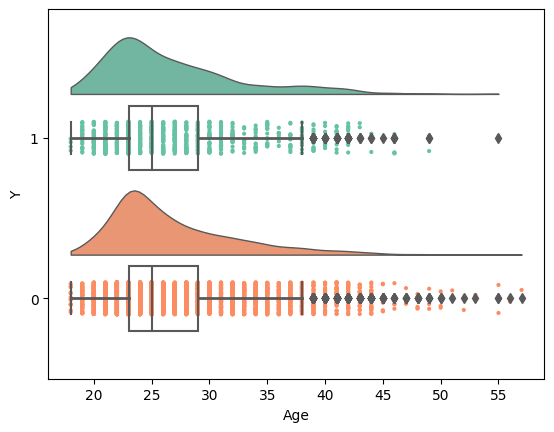

In [74]:
import ptitprince as pt

ax = pt.RainCloud(y = Dataset['Age'], x = Dataset['Y'].astype('str'), 
                  width_viol = .8,
                  width_box = .4,
                  orient = 'h',
                  move = .0)

In [75]:
#Here, we are going to drop any age that has a value counts == 1, as this will not help the model to learn from it and will 
#Affect the model negetavily.
drop_model = Dataset["Age"].value_counts()[Dataset["Age"].value_counts() == 1].index
drop_model

Index([56.0, 52.0, 53.0, 57.0, 51.0], dtype='float64', name='Age')

In [76]:
for i in drop_model:
    drop_index = Dataset[Dataset["Age"] == i].index
    Dataset.drop(index = drop_index, inplace=True)

Dataset.reset_index(drop=True, inplace=True)

## Gender

In [77]:
Dataset.Gender.isna().sum()

0

In [78]:
Dataset.groupby("Gender")[["Y"]].count()

,Y
Gender,
أنثى,3631
ذكر,2820


## Home City & Home Region

We will use just Home Region & Drop Home city


In [79]:
Dataset.groupby("Home_Region")[["Y"]].count().sort_values("Y")

,Y
Home_Region,
منطقة الجوف,21
منطقة الحدود الشمالية,21
منطقة نجران,29
منطقة حائل,36
منطقة الباحة,46
منطقة تبوك,49
منطقة جازان,59
منطقة القصيم,100
منطقة عسير,170


In [80]:
Dataset.Home_Region.isna().sum()

2

In [81]:
Dataset[Dataset.Home_Region.isna() == True]

,Student_ID,Age,Gender,Home_Region,Home_City,Program_ID,Program_Main_Category_Code,Program_Sub_Category_Code,Technology_Type,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,College,University_Degree_Score,University_Degree_Score_System,University_Degree_Score_100,Employment_Status,Job_Type,Still_Working,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total_Regestration,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month
2136,55b23798-369d-4698-8cb9-f8d1684bf1f8,NaN,ذكر,NaN,NaN,899795e1-7bf3-46d0-a58e-824d4033f6da,PCRF,PCRF,تقليدية,متوسط,حضوري,2023-05-14,2023-11-02,173,نعم,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0,0,5,11
5154,cc394a25-74ed-43f9-92bc-e0021fc969c5,45.0,ذكر,NaN,NaN,ce3562c8-8d27-4ffb-8dfc-e1dd4527b32a,PCRF,PCRF,تقليدية,مبتدئ,عن بعد,2023-01-15,2023-01-19,5,نعم,الماجستير,Management Information Systems,الأعمال والإدارة والقانون,4.0,5.0,86.665,موظف,دوام كامل,Yes,0,2,0,1,0,0,1,0,0,0,0,1,5,0,0.0,0,0,1,1


In [82]:
# Drop the 2nd row since all information is missing (just the program info is there)
Dataset.drop([3292], inplace= True)

# Fill the only missing Home_Region by the most frequent city which is Riyadh
Dataset["Home_Region"][1864] = "منطقة الرياض"

**Check**

In [83]:
Dataset[Dataset.Home_Region.isna() == True]

,Student_ID,Age,Gender,Home_Region,Home_City,Program_ID,Program_Main_Category_Code,Program_Sub_Category_Code,Technology_Type,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,College,University_Degree_Score,University_Degree_Score_System,University_Degree_Score_100,Employment_Status,Job_Type,Still_Working,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total_Regestration,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month
2136,55b23798-369d-4698-8cb9-f8d1684bf1f8,NaN,ذكر,NaN,NaN,899795e1-7bf3-46d0-a58e-824d4033f6da,PCRF,PCRF,تقليدية,متوسط,حضوري,2023-05-14,2023-11-02,173,نعم,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0,0,5,11
5154,cc394a25-74ed-43f9-92bc-e0021fc969c5,45.0,ذكر,NaN,NaN,ce3562c8-8d27-4ffb-8dfc-e1dd4527b32a,PCRF,PCRF,تقليدية,مبتدئ,عن بعد,2023-01-15,2023-01-19,5,نعم,الماجستير,Management Information Systems,الأعمال والإدارة والقانون,4.0,5.0,86.665,موظف,دوام كامل,Yes,0,2,0,1,0,0,1,0,0,0,0,1,5,0,0.0,0,0,1,1


In [84]:
Dataset["Home_City"].unique()

array(['الرياض', 'الدلم', 'الأحساء', 'جدة', 'أبها', 'الطائف',
       'العاصمة المقدسة', 'الجبيل', 'الخبر', 'الدرعية', 'رفحاء',
       'محايل عسير', 'شرورة', 'المدينة المنورة', 'الباحة', 'سكاكا',
       'المجمعة', 'خميس مشيط', 'الدمام', 'العلا', 'الهفوف', 'طبرجل',
       'بريدة', 'حفر الباطن', 'جازان', 'حائل', 'ينبع', 'نجران', 'عنيزة',
       'مكة المكرمة', 'صبيا', 'البدائع', 'جيزان', 'الجموم', 'الظهران',
       'سيهات', 'القطيف', 'محايل', 'أحد المسارحة', 'بحرة', 'الخرج',
       'عرعر', 'ثادق', 'المذنب', 'تبوك', 'البكيرية', 'القنفذة',
       'رجال ألمع', 'رأس تنورة', 'الدوادمي', 'رابغ', 'ضبا', 'الخفجي',
       'بدر', 'الزلفي', 'الغاط', 'سراة عبيدة', 'دومة الجندل',
       'حوطة بني تميم', 'الدرب', 'أبو عريش', 'الرس', 'بيشة', 'مهد الذهب',
       nan, 'بقيق', 'المزاحمية', 'أحد رفيدة', 'بيش', 'ضمد', 'صفوى',
       'المجاردة', 'الليث', 'شقراء', 'صامطة', 'العرضيات', 'رياض الخبراء',
       'القرى', 'ظهران الجنوب', 'طريف', 'الحناكية', 'وادي الفرع', 'تربة',
       'بارق', 'القريات', 'بلجرشي', 'ا

In [85]:
Dataset["Home_City"].nunique()

92

In [86]:
Dataset.groupby(["Home_City"])[['Y']].count().sort_values(by='Y', ascending=False)

,Y
Home_City,
الرياض,4637
جدة,361
المدينة المنورة,131
الدمام,117
أبها,108
...,...
تيماء,1
رياض الخبراء,1
ابها,1


In [87]:
Dataset["Home_City"].isna().sum()

2

We are going to delet this column for the following reseans:
- Home City is redundence information of Home Region 
- It contains a lot of typos, for example there is المدينه المنوره  and  المدينة المنورة
- Has high variety, for example there is مكة المكرمة and  العاصمة المقدسة

In [88]:
Dataset.drop(columns=["Home_City"], inplace = True)
Dataset.sample(1)

,Student_ID,Age,Gender,Home_Region,Program_ID,Program_Main_Category_Code,Program_Sub_Category_Code,Technology_Type,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,College,University_Degree_Score,University_Degree_Score_System,University_Degree_Score_100,Employment_Status,Job_Type,Still_Working,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total_Regestration,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month
2897,746ea1f4-dada-4cfc-a4ae-494e6e75912b,34.0,ذكر,منطقة الرياض,65451000-39ff-4b0b-b0b4-bb2a67bcf9ed,GRST,INFA,تقليدية,متوسط,حضوري,2022-12-04,2022-12-07,4,نعم,البكالوريوس,Computer Engineering,NaN,3.34,4.0,91.19922,موظف,NaN,NaN,0,0,1,0,1,0,0,0,0,0,0,0,2,0,0.0,0,0,12,12


## Program Main Category Code  &	Program Sub Category Code

In [89]:
Dataset['Program_Main_Category_Code'].value_counts()

Program_Main_Category_Code
CAUF    2335
PCRF    1647
APMR    1289
TOSL     472
GRST     208
ABIR     203
INFA     179
SERU      53
DTFH      33
QWLM      31
Name: count, dtype: int64

In [90]:
Dataset.groupby(['Program_Main_Category_Code', 'Program_Sub_Category_Code']).count()

Student_ID   Age  Gender  Home_Region  Program_ID  Technology_Type  Program_Skill_Level  Program_Presentation_Method  Program_Start_Date  Program_End_Date  Program_Days  Completed_Degree  Level_of_Education  Education_Speaciality_Translated  College  University_Degree_Score  University_Degree_Score_System  University_Degree_Score_100  Employment_Status  Job_Type  Still_Working     Y  PCRF  GRST  CAUF  INFA  ABIR  SERU  TOSL  APMR  DTFH  QWLM   N/A  Total_Regestration  Cumulative_Completed_Programs  Withdrawals_scores  Is_ramadan  Is_summer  start_month  end_month
Program_Main_Category_Code Program_Sub_Category_Code                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
ABIR                       ABIR                               19    19      19           19          19               19                   19                           19                  19                19            19                19                  19                                19       19                       19                              19                           19                 17        16             16    19    19    19    19    19    19    19    19    19    19    19    19                  19                             19                  19          19         19           19         19
                           INFA                              106   106     106          106         106               58                   71                          106                 106               106           106               106                 106                               105       43                      106                             106                          106                101        36             36   106   106   106   106   106   106   106   106   106   106   106   106                 106                            106                 106         106        106          106        106
APMR                       ASCW                               36    36      36           36          36               36                   36                           36                  36                36            36                36                  36                                33       10                       36                              36                           36                 34         3              3    36    36    36    36    36    36    36    36    36    36    36    36                  36                             36                  36          36         36           36         36
                           KLTM                              117   116     117          117         117               92                   92                          117                 117               117           117               117                 117                               115       46                      116                             116                          116                103        29             29   117   117   117   117   117   117   117   117   117   117   117   117                 117                            117                 117         117        117          117        117
                           QTDY                               49    49      49           49          49               49                   49                           49                  49                49            49                49                  49                                46       16       

Program_Main_Category_Code may have more than one sub category

In [91]:
# Dataset.loc[:,[	'Program_Main_Category_Code', "Program_Sub_Category_Code",  "Full_Program_Category_Code"]]

**To check whether the Main & sub combination gives us a unique program ID, we did the following:**


In [92]:
len(Dataset.groupby('Program_ID')['Age'].count()) # Age or any column (same result)

223

In [93]:
Dataset.groupby('Program_ID')['Age'].count()

Program_ID
0121066e-b5f6-40f0-b381-670545d2aa55    23
013916fa-85bd-46bc-80c8-f37c036fd142    12
02ae0b47-64a6-47a1-b3c5-c0e4df393c30    21
02d387ca-5045-47ea-bcaa-8c94e747cc1a    17
03ec0d20-11cd-49bf-9b54-de5d12d4bd76    17
                                        ..
f6feebca-cf2e-49f8-b3df-f3bb115cd241    34
f9381e31-e034-4ece-87e1-3012a22e222e    28
fb8fc693-05b5-495e-a7d7-98f4cf3f7562    33
fc4f3306-9a9a-4577-8262-2861edf5d3cb    33
fcfa11cb-7c8f-40af-8922-aa0e38b2ba63    26
Name: Age, Length: 223, dtype: int64

In [94]:
# function6
def Program_Category(Dataset):
    # replace na by _  to not get na during concatination
    Dataset['Program_Sub_Category_Code'] = Dataset['Program_Sub_Category_Code'].fillna('_')
    
    # concat the main & sub categories 
    Dataset["Full_Program_Category_Code"]= Dataset['Program_Main_Category_Code'].astype(str) + '_' + Dataset['Program_Sub_Category_Code']
    #----
    Dataset.drop(columns=['Program_Main_Category_Code', "Program_Sub_Category_Code"], inplace = True)
    return(Dataset)

In [95]:
Dataset = Program_Category(Dataset)
Dataset.sample(2)

,Student_ID,Age,Gender,Home_Region,Program_ID,Technology_Type,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,College,University_Degree_Score,University_Degree_Score_System,University_Degree_Score_100,Employment_Status,Job_Type,Still_Working,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total_Regestration,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code
5203,ce6a4324-dbf8-4271-bd67-214276c731bd,22.0,أنثى,منطقة مكة المكرمة,aab6e8f7-5f67-4691-b6a9-6b1004cb98cd,تقليدية,متوسط,حضوري,2023-03-12,2023-03-16,5,نعم,البكالوريوس,Computer Science,تكنولوجيا الاتصالات والمعلومات,4.6,5.0,94.6648,غير موظف,تدريب,No,0,0,0,4,0,0,0,0,6,0,0,1,11,0,0.0,0,0,3,3,APMR_SRTA
4187,a6012671-99f1-46a5-af86-6f05795b7f62,28.0,أنثى,المنطقة الشرقية,71232fc2-3531-4297-a355-d83628f945bb,NaN,NaN,حضوري,2023-03-05,2023-03-09,5,لا,البكالوريوس,Computer Science,NaN,4.4,5.0,91.9982,موظف,NaN,NaN,1,0,0,1,0,0,0,0,3,0,0,0,4,0,0.0,0,0,3,3,APMR_SWPS


In [96]:
Dataset.groupby(['Full_Program_Category_Code', 'Program_ID']).count().head(10)

Student_ID  Age  Gender  Home_Region  Technology_Type  Program_Skill_Level  Program_Presentation_Method  Program_Start_Date  Program_End_Date  Program_Days  Completed_Degree  Level_of_Education  Education_Speaciality_Translated  College  University_Degree_Score  University_Degree_Score_System  University_Degree_Score_100  Employment_Status  Job_Type  Still_Working   Y  PCRF  GRST  CAUF  INFA  ABIR  SERU  TOSL  APMR  DTFH  QWLM  N/A  Total_Regestration  Cumulative_Completed_Programs  Withdrawals_scores  Is_ramadan  Is_summer  start_month  end_month
Full_Program_Category_Code Program_ID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
ABIR_ABIR                  1f85b2fb-196b-4919-bc37-3cf102d41d38          19   19      19           19               19                   19                           19                  19                19            19                19                  19                                19       19                       19                              19                           19                 17        16             16  19    19    19    19    19    19    19    19    19    19    19   19                  19                             19                  19          19         19           19         19
ABIR_INFA                  0fd432b1-7779-49cb-b203-000b90c9a6dd          18   18      18           18                0                    0                           18                  18                18            18                18                  18                                18        5                       18                              18                           18                 18         5              5  18    18    18    18    18    18    18    18    18    18    18   18                  18                             18                  18          18         18           18         18
                           32bce2ad-426a-4096-b7d0-78b5f30bd8a0          58   58      58           58               58                   58                           58                  58                58            58                58                  58                                57       32                       58                              58                           58                 53        25             25  58    58    58    58    58    58    58    58    58    58    58   58                  58                             58                  58          58         58           58         58
                           bdfc3e96-d889-40f6-a056-ea463f848b4e          17   17      17           17                0                    0                           17                  17                17            17                17                  17                                17        5                       17                              17                           17                 17         5              5  17    17    17    17    17    17    17    17    17    17    17   17                  17                             17                  17          17         17           17         17
                           f166679b-c2b6-4a12-823c-4db899d1e94a          13   13      13           13                0                   13                           13                  13                13            13                13                  13                                13        1                       13                         

Each Full_Program_Category_Code may represent more than one program ID

In [97]:
Dataset.groupby(['Program_ID', "Program_Start_Date"]).count().head(20)

,,Student_ID,Age,Gender,Home_Region,Technology_Type,Program_Skill_Level,Program_Presentation_Method,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,College,University_Degree_Score,University_Degree_Score_System,University_Degree_Score_100,Employment_Status,Job_Type,Still_Working,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total_Regestration,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code
Program_ID,Program_Start_Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0121066e-b5f6-40f0-b381-670545d2aa55,2023-02-26,23,23,23,23,0,23,23,23,23,23,23,21,3,23,23,23,23,2,2,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
013916fa-85bd-46bc-80c8-f37c036fd142,2023-07-16,13,12,13,13,0,13,13,13,13,13,13,12,7,13,13,13,10,4,4,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
02ae0b47-64a6-47a1-b3c5-c0e4df393c30,2023-07-16,21,21,21,21,21,21,21,21,21,21,21,21,7,21,21,21,20,4,4,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21
02d387ca-5045-47ea-bcaa-8c94e747cc1a,2023-04-02,17,17,17,17,17,17,17,17,17,17,17,15,8,17,17,17,15,4,4,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
03ec0d20-11cd-49bf-9b54-de5d12d4bd76,2022-12-25,18,17,18,18,0,0,18,18,18,18,18,16,1,17,17,17,17,1,1,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
04df155c-2eef-496e-b38e-30283b56249c,2023-12-31,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,21,15,15,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
06a5100e-185f-4b2c-acfd-bd9a3d0ff042,2022-08-03,19,19,19,19,0,0,19,19,19,19,19,19,5,19,19,19,19,3,3,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19
07ee262e-e05a-49aa-927b-079ada03da59,2023-11-12,19,19,19,19,19,19,19,19,19,19,19,19,18,19,19,19,17,16,16,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19
0a189924-a682-4deb-80c9-5525ebd2b9da,2022-12-04,32,32,32,32,0,0,32,32,32,32,32,32,13,32,32,32,30,8,8,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32


We can notice that each program can be held more than once.
Like Clarusway does 2 Data Science bootcamps

## Technology Type

In [98]:
Dataset.Technology_Type.isna().sum()

2935

In [99]:
Dataset.groupby(["Technology_Type", "Y"])[["Y"]].count()

Y
Technology_Type Y      
تقليدية         0  2168
                1   481
داعمة           0   350
                1    77
ناشئة           0   381
                1    58

In [100]:
ordinairy_0 = Dataset.groupby(["Technology_Type", "Y"])[["Y"]].count().iloc[0,0]
ordinairy_1 = Dataset.groupby(["Technology_Type", "Y"])[["Y"]].count().iloc[1,0]
print("left_ordiniary%:", round(ordinairy_1/(ordinairy_1+ordinairy_0)*100,2))
#---
supportive_0 = Dataset.groupby(["Technology_Type", "Y"])[["Y"]].count().iloc[2,0]
supportive_1 = Dataset.groupby(["Technology_Type", "Y"])[["Y"]].count().iloc[3,0]
print("left_supportive%:", round(supportive_1/(supportive_1+supportive_0)*100,2))
#---
startup_0 = Dataset.groupby(["Technology_Type", "Y"])[["Y"]].count().iloc[4,0]
startup_1 = Dataset.groupby(["Technology_Type", "Y"])[["Y"]].count().iloc[5,0]
print("left_startup%:", round(startup_1/(startup_1+startup_0)*100,2))
#---

left_ordiniary%: 18.16

left_supportive%: 18.03

left_startup%: 13.21


Since:
-  There are many null values (46% missing) <br>
-  THere is no clear differences between two cateogries of the three <br>

Therefore, we decided to drop this column

In [101]:
Dataset.drop(columns=['Technology_Type'], inplace = True)
Dataset.sample(1)

,Student_ID,Age,Gender,Home_Region,Program_ID,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,College,University_Degree_Score,University_Degree_Score_System,University_Degree_Score_100,Employment_Status,Job_Type,Still_Working,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total_Regestration,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code
340,0f38f800-d207-41ee-8e77-17eeb0cca70d,26.0,أنثى,منطقة الرياض,30643e26-1fcf-43f7-bc07-4cde49ecd276,مبتدئ,حضوري,2022-11-06,2022-11-10,5,نعم,البكالوريوس,Other,NaN,4.5,5.0,93.3315,طالب,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0,0,11,11,CAUF_SWPS


## Program_Skill_Level

In [102]:
Dataset.Program_Skill_Level.isna().sum()

1643

In [103]:
Dataset.groupby(["Program_Skill_Level", "Y"])[["Y"]].count()

Y
Program_Skill_Level Y      
مبتدئ               0  1650
                    1   384
متقدم               0   585
                    1   106
متوسط               0  1731
                    1   351

In [104]:
beginner_0 = Dataset.groupby(["Program_Skill_Level", "Y"])[["Y"]].count().iloc[0,0]
beginner_1 = Dataset.groupby(["Program_Skill_Level", "Y"])[["Y"]].count().iloc[1,0]
print("left_beginner%:", round(beginner_1/(beginner_1+beginner_0)*100,2))
#---
Advanced_0 = Dataset.groupby(["Program_Skill_Level", "Y"])[["Y"]].count().iloc[2,0]
Advanced_1 = Dataset.groupby(["Program_Skill_Level", "Y"])[["Y"]].count().iloc[3,0]
print("left_advanced%:", round(Advanced_1/(Advanced_1+Advanced_0)*100,2))
#---
Intermediate_0 = Dataset.groupby(["Program_Skill_Level", "Y"])[["Y"]].count().iloc[4,0]
Intermediate_1 = Dataset.groupby(["Program_Skill_Level", "Y"])[["Y"]].count().iloc[5,0]
print("left_intermediate%:", round(Intermediate_1/(Intermediate_1+Intermediate_0)*100,2))
#---

left_beginner%: 18.88

left_advanced%: 15.34

left_intermediate%: 16.86


In [105]:
df_temp = Dataset[Dataset["Program_Skill_Level"].isna()== True] 
df_temp

,Student_ID,Age,Gender,Home_Region,Program_ID,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,College,University_Degree_Score,University_Degree_Score_System,University_Degree_Score_100,Employment_Status,Job_Type,Still_Working,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total_Regestration,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code
4,002e4e76-d10d-47eb-a4db-3fa9f39e47dd,34.0,أنثى,منطقة الرياض,0a189924-a682-4deb-80c9-5525ebd2b9da,NaN,عن بعد,2022-12-04,2022-12-22,19,نعم,البكالوريوس,Information Systems,تكنولوجيا الاتصالات والمعلومات,92.00,100.0,92.00000,NaN,NaN,NaN,0,0,0,7,0,0,0,0,5,0,0,6,18,0,2.0,0,0,12,12,CAUF_SWPS
5,004ce712-8914-48a4-b85a-93f64c78da30,32.0,ذكر,منطقة الرياض,67e5e2cf-c57d-47b3-9c5c-3906aa07d99b,NaN,حضوري,2022-10-16,2022-12-08,54,نعم,البكالوريوس,English Language,NaN,3.00,4.0,86.66600,عمل حر,NaN,NaN,0,0,0,7,1,0,0,0,0,0,0,0,8,0,0.0,0,0,10,12,CAUF_SWPS
6,007aea88-223a-4e72-af55-ac2153a1d0e2,35.0,ذكر,منطقة الرياض,5b4d389b-ce84-46c4-87f0-70531fdaf1e7,NaN,حضوري,2023-05-14,2023-05-25,12,نعم,الدبلوم,Computer Networks & Computer Enigneering,تكنولوجيا الاتصالات والمعلومات,4.00,5.0,86.66500,NaN,NaN,NaN,0,14,0,9,4,3,0,0,4,0,0,1,35,0,0.0,0,0,5,5,INFA_INFA
8,007d47e5-cd3e-4c26-8e8b-a6f080397256,25.0,أنثى,المنطقة الشرقية,c8b4f6d3-7705-4373-b2e0-a110f416e893,NaN,عن بعد,2022-07-31,2022-09-22,54,نعم,البكالوريوس,Information Systems,تكنولوجيا الاتصالات والمعلومات,4.00,4.0,99.99900,NaN,NaN,NaN,0,1,0,8,1,0,0,0,3,0,0,9,22,0,0.0,0,0,7,9,CAUF_SWPS
9,00816a99-e9e9-4b31-a36c-6e45580391aa,30.0,ذكر,منطقة مكة المكرمة,e58677d9-20ef-43a4-955e-e78e2989cc91,NaN,حضوري,2023-02-19,2023-03-02,12,نعم,البكالوريوس,Information Systems,NaN,3.53,5.0,80.39849,موظف,NaN,NaN,0,2,0,0,1,0,0,0,0,0,0,0,3,0,0.0,0,0,2,3,INFA_INFA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6441,ff8c15fd-0f04-467f-9a10-91e94fa43390,23.0,أنثى,منطقة المدينة المنورة,c8b4f6d3-7705-4373-b2e0-a110f416e893,NaN,عن بعد,2022-07-31,2022-09-22,54,نعم,البكالوريوس,Management Information Systems,الأعمال والإدارة والقانون,5.00,5.0,99.99800,موظف,تطوع,Yes,0,4,0,6,0,0,1,0,6,0,0,9,26,0,0.0,0,0,7,9,CAUF_SWPS
6442,ff9a80a7-e557-4cce-a4ed-b68cff1d1db0,25.0,أنثى,المنطقة الشرقية,c8b4f6d3-7705-4373-b2e0-a110f416e893,NaN,عن بعد,2022-07-31,2022-09-22,54,نعم,الدبلوم,Information Technology,NaN,3.74,5.0,83.19842,خريج,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.0,0,0,7,9,CAUF_SWPS
6443,ff9ed71d-86ac-4228-9e25-242a055bcdf4,27.0,ذكر,منطقة الرياض,6c5c41e1-28a7-487f-8c74-58eb33f9e40b,NaN,حضوري,2023-03-12,2023-12-28,292,لا,البكالوريوس,Applied Mathematics,العلوم الطبيعية والرياضيات والإحصاء,3.64,5.0,81.86512,موظف,دوام جزئي,Yes,1,0,0,1,0,0,0,0,0,0,0,3,4,0,0.0,0,0,3,12,APMR_KLTM
6446,ffba6bca-a961-4881-a2a2-65fe664f345a,22.0,ذكر,منطقة الرياض,9a48a693-5c44-4c91-9443-417178621789,NaN,حضوري,2023-03-19,2023-03-23,5,لا,البكالوريوس,Computer Engineering,NaN,3.75,5.0,83.33175,خريج,NaN,NaN,0,5,0,1,1,0,0,0,0,0,0,0,7,0,0.0,1,0,3,3,PCRF_PCRF


In [106]:
df_temp.groupby("Program_Presentation_Method").count()

,Student_ID,Age,Gender,Home_Region,Program_ID,Program_Skill_Level,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,College,University_Degree_Score,University_Degree_Score_System,University_Degree_Score_100,Employment_Status,Job_Type,Still_Working,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total_Regestration,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code
Program_Presentation_Method,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
حضوري,1290,1277,1290,1290,1290,0,1290,1290,1290,1290,1288,1246,547,1279,1279,1278,1186,418,418,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290,1290
عن بعد,353,350,353,353,353,0,353,353,353,353,353,343,156,351,351,351,302,93,93,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353


so the missing skills does not correlate with a presentation method (there are missing from both presentation skills), so our assumption that only online courses has missing program skill is not valid

We will keep it & try to fill it


## Program Days

**We want to check if there is a relationship between the Program Days and if it will affect on completing a program of not**

In [107]:
unique_days = df_temp['Program_Days'].unique()

data = []
for i in unique_days:
    count_completed_1 = ((df_temp['Program_Days'] == i) & (df_temp['Y'] == 1)).sum()
    count_completed_0 = ((df_temp['Program_Days'] == i) & (df_temp['Y'] == 0)).sum()
    data.append([i, count_completed_1, count_completed_0])

df_summary = pd.DataFrame(data, columns=['Program Days', 'Not completed(1)', 'completed(0)'])
df_summary["percentage_left"] = round(df_summary["Not completed(1)"] / (df_summary["Not completed(1)"] + df_summary["completed(0)"])*100,2)
df_summary.sort_values("Program Days")

,Program Days,Not completed(1),completed(0),percentage_left
10,4,17,18,48.57
4,5,96,451,17.55
15,9,0,35,0.00
2,12,47,299,13.58
0,19,10,112,8.20
11,20,0,15,0.00
9,21,1,17,5.56
13,25,0,19,0.00
5,26,6,120,4.76
8,33,5,38,11.63


**From this table, we can see that the Program Days does not affect the state of completion**

ADD a histogram:

- Program days of Y=1
- Program days of Y=0

Text(0, 0.5, 'Count')

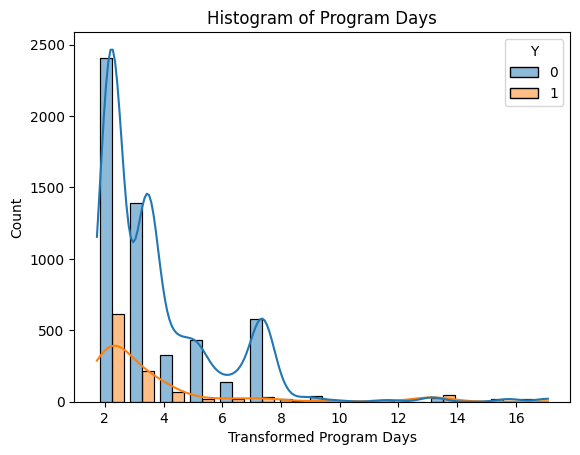

In [108]:


sns.histplot(data=Dataset, x=np.sqrt(Dataset['Program_Days']), hue='Y', bins=15, kde=True, multiple="dodge", shrink=.8)

plt.title('Histogram of Program Days')
plt.xlabel('Transformed Program Days')
plt.ylabel('Count')

## Employment_Status, Job_Type, Still_Working

In [109]:
print(f"Missing values in Employment Status is: {df_temp['Employment_Status'].isna().sum()}")
print(f"Missing values in Job Type is: {df_temp['Job_Type'].isna().sum()}")
print(f"Missing values in Still Working is: {df_temp['Still_Working'].isna().sum()}")
# We can notice a lot of missing values in Job_Type and Still_Working

Missing values in Employment Status is: 155

Missing values in Job Type is: 1132

Missing values in Still Working is: 1132


In [110]:
pd.crosstab(df_temp['Job_Type'], [df_temp['Employment_Status'], df_temp['Still_Working']], dropna= False)

Employment_Status خريج          طالب          عمل حر         غير موظف          موظف           موظف - طالب         NaN         
Still_Working       No Yes  NaN   No Yes  NaN     No Yes NaN       No Yes  NaN   No  Yes  NaN          No Yes NaN  No Yes  NaN
Job_Type                                                                                                                      
تدريب                0   0    0    5   0    0      0   0   0      119   0    0    0   23    0           0   0   0   0   0    0
تطوع                 0   0    0    2   0    0      0   0   0        6   0    0    0   10    0           0   6   0   0   0    0
دوام جزئي            0   0    0    1   0    0      0   0   0        8   0    0    0   10    0           0   2   0   0   0    0
دوام كامل            0   0    0    4   0    0      0   0   0       75   0    0    0  226    0           0  14   0   0   0    0
NaN                  0   0  267    0   0  227      0   0  16        0   0  128    0    0  339           0   0   0   0   0  155

In [111]:
#We want to see, if there is a pattern between completing the program with the Still Working and Job Type
pd.crosstab(df_temp['Y'], [df_temp['Job_Type'], df_temp['Still_Working'], df_temp['Employment_Status']])
#From the table, we can notice that these two columns not only they have a lot of missing values, but they also do not
#affect on completting the program. So, we gonna delete them.

Job_Type          تدريب               تطوع                           دوام جزئي                           دوام كامل                          
Still_Working        No           Yes   No           Yes                    No           Yes                    No           Yes            
Employment_Status  طالب غير موظف موظف طالب غير موظف موظف موظف - طالب      طالب غير موظف موظف موظف - طالب      طالب غير موظف موظف موظف - طالب
Y                                                                                                                                           
0                     4      110   21    2        6    8           6         0        6    9           2         4       65  210          11
1                     1        9    2    0        0    2           0         1        2    1           0         0       10   16           3

In [112]:
df_temp.drop(['Still_Working', 'Job_Type'], axis=1, inplace=True)
Dataset.drop(['Still_Working', 'Job_Type'], axis=1, inplace=True)

#### Checking if the columns have been deleted or not

In [113]:
df_temp.columns

Index(['Student_ID', 'Age', 'Gender', 'Home_Region', 'Program_ID', 'Program_Skill_Level', 'Program_Presentation_Method', 'Program_Start_Date', 'Program_End_Date', 'Program_Days', 'Completed_Degree', 'Level_of_Education', 'Education_Speaciality_Translated', 'College', 'University_Degree_Score', 'University_Degree_Score_System', 'University_Degree_Score_100', 'Employment_Status', 'Y', 'PCRF', 'GRST', 'CAUF', 'INFA', 'ABIR', 'SERU', 'TOSL', 'APMR', 'DTFH', 'QWLM', 'N/A', 'Total_Regestration', 'Cumulative_Completed_Programs', 'Withdrawals_scores', 'Is_ramadan', 'Is_summer', 'start_month', 'end_month', 'Full_Program_Category_Code'], dtype='object')

We see that the three afromentioned columns have sort of relationship. However, two of them have too many missing values (>50%), since we could not find a logical way to impute them using the 3rd one, we decided to delete these two and keep the other

In [114]:
Dataset["Employment_Status"].value_counts()

Employment_Status
موظف           2753
غير موظف       1100
طالب            952
خريج            943
موظف - طالب      87
عمل حر           64
Name: count, dtype: int64

In [115]:
# function7
def jobs(Dataset):
    # To English (Optional)
    Dataset['Employment_Status'].replace('موظف', 'Employee', inplace= True)
    Dataset['Employment_Status'].replace('غير موظف', 'Unemployed', inplace= True)
    Dataset['Employment_Status'].replace('طالب', 'Student', inplace= True)
    Dataset['Employment_Status'].replace('خريج', 'Graduate', inplace= True)
    # To oTher (Mandatory)
    Dataset['Employment_Status'].replace('موظف - طالب', 'Other', inplace= True)
    Dataset['Employment_Status'].replace('عمل حر', 'Other', inplace= True)
    return Dataset

In [116]:
Dataset = jobs(Dataset)
Dataset.sample(2)

,Student_ID,Age,Gender,Home_Region,Program_ID,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,College,University_Degree_Score,University_Degree_Score_System,University_Degree_Score_100,Employment_Status,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total_Regestration,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code
365,10550b28-4d37-45db-a1cd-8e015e259cee,20.0,أنثى,منطقة الرياض,f02dbb17-623e-4a07-8125-4ea43c793ba3,مبتدئ,حضوري,2022-06-12,2022-06-16,5,لا,الدبلوم,Computer Science,تكنولوجيا الاتصالات والمعلومات,4.35,5.0,91.33155,NaN,0,12,3,27,7,0,0,0,8,0,1,18,76,0,0.0,0,0,6,6,CAUF_SWPS
5767,e419e8fc-37d1-4c39-9ea1-05237952d9b1,29.0,أنثى,منطقة المدينة المنورة,f1836af7-20e4-4551-9571-68718889342f,متوسط,حضوري,2023-07-23,2023-09-14,54,نعم,البكالوريوس,Computer Science,NaN,3.67,5.0,82.26511,Graduate,0,0,0,4,0,0,0,0,1,0,0,0,5,0,0.0,0,1,7,9,CAUF_SWPS


In [117]:
# Check
Dataset["Employment_Status"].value_counts()

Employment_Status
Employee      2753
Unemployed    1100
Student        952
Graduate       943
Other          151
Name: count, dtype: int64

## University_Degree_Score

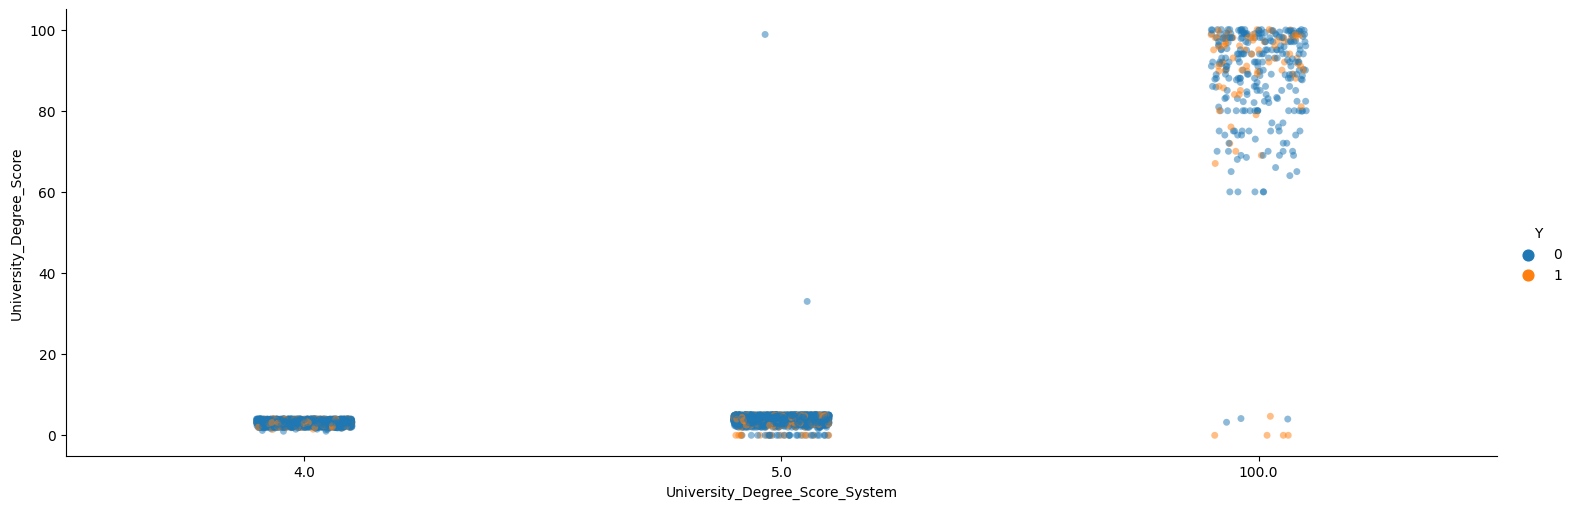

In [118]:
sns.catplot(x='University_Degree_Score_System', y='University_Degree_Score', 
            data=Dataset, hue="Y", kind="strip", alpha=0.5, aspect=3, sharex=False)

In [119]:
invalid_score_outoff_4=Dataset.loc[(Dataset.University_Degree_Score_System==4) & 
            ((Dataset.University_Degree_Score>4) | (Dataset.University_Degree_Score<1))]
invalid_score_outoff_4.shape

(0, 38)

In [120]:
invalid_score_outoff_5=Dataset.loc[(Dataset.University_Degree_Score_System==5) & 
            ((Dataset.University_Degree_Score>5) | (Dataset.University_Degree_Score<1))]
invalid_score_outoff_5.shape

(40, 38)

In [121]:
invalid_score_outoff_5.sample(3)
#invalid_outoff_5.loc((invalid_outoff_5.Level_of_Education=="ثانوي")&(invalid_outoff_5.Completed_Degree=="نعم"))

,Student_ID,Age,Gender,Home_Region,Program_ID,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,College,University_Degree_Score,University_Degree_Score_System,University_Degree_Score_100,Employment_Status,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total_Regestration,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code
3217,80c917c9-65ed-4223-8612-0b81db82e414,21.0,ذكر,منطقة الرياض,a2361bd7-8d8a-465c-a552-fcfcde587f0a,مبتدئ,حضوري,2023-03-05,2023-03-09,5,نعم,ثانوي,NaN,NaN,0.0,5.0,33.333,Unemployed,0,0,0,10,1,0,1,0,1,0,0,1,14,0,0.0,0,0,3,3,CAUF__
2962,76cb81cc-a998-48c5-8c6a-f2bf2136d443,20.0,ذكر,منطقة مكة المكرمة,451d680f-e067-41c0-a998-6b3da3963bca,متوسط,عن بعد,2023-10-08,2023-10-12,5,نعم,ثانوي,NaN,NaN,0.0,5.0,33.333,Student,0,0,0,3,0,0,0,0,7,0,0,1,11,0,0.0,0,0,10,10,CAUF_SWPS
1318,35e3e28f-68e3-4a86-b5fc-d81a31646059,21.0,ذكر,منطقة الرياض,b9089232-a3be-4fbf-b8fe-d29104d5f0dd,NaN,حضوري,2023-07-30,2023-08-10,12,نعم,ثانوي,NaN,NaN,0.0,5.0,33.333,NaN,0,1,0,1,0,0,0,0,0,0,0,1,3,0,0.0,0,1,7,8,CAUF_SWPS


In [122]:
invalid_score_outoff_100=Dataset.loc[(Dataset.University_Degree_Score_System==100) & 
            ((Dataset.University_Degree_Score>100) | (Dataset.University_Degree_Score<60))]
invalid_score_outoff_100.shape

(8, 38)

In [123]:
invalid_score_outoff_100

,Student_ID,Age,Gender,Home_Region,Program_ID,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,College,University_Degree_Score,University_Degree_Score_System,University_Degree_Score_100,Employment_Status,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total_Regestration,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code
516,15d0e903-05d4-4e86-a663-a2390d342e2a,20.0,ذكر,منطقة الرياض,fcfa11cb-7c8f-40af-8922-aa0e38b2ba63,مبتدئ,حضوري,2022-09-25,2022-09-29,5,لا,البكالوريوس,Other,NaN,4.69,100.0,4.69,Student,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0.0,0,0,9,9,CAUF_SWPS
2341,5d994eff-c241-4ebe-8674-9fd41e45252c,26.0,أنثى,منطقة تبوك,5ab61376-f20b-4e5a-bce4-22b8890bbc2e,مبتدئ,عن بعد,2023-09-10,2023-09-14,5,نعم,البكالوريوس,Computer Science,تكنولوجيا الاتصالات والمعلومات,3.21,100.0,3.21,NaN,0,3,0,2,0,0,1,0,5,0,0,2,13,0,0.0,0,0,9,9,APMR_SRTA
3588,8e1b9706-af42-45fa-86f6-3ad1e1407067,20.0,أنثى,منطقة الرياض,e6be9f1a-dffa-4662-a7d2-74a6e12ad4b2,مبتدئ,حضوري,2023-02-12,2023-02-21,10,نعم,ثانوي,Business Management,الأعمال والإدارة والقانون,0.00,100.0,0.00,Student,1,9,2,10,1,0,0,0,8,0,0,1,31,0,0.0,0,0,2,2,CAUF_SWPS
3589,8e1b9706-af42-45fa-86f6-3ad1e1407067,20.0,أنثى,منطقة الرياض,a09d8831-8bc0-43f9-8a83-1c164106155f,متوسط,حضوري,2023-05-14,2023-05-18,5,نعم,ثانوي,Business Management,الأعمال والإدارة والقانون,0.00,100.0,0.00,Student,1,9,2,10,1,0,0,0,8,0,0,1,31,0,2.0,0,0,5,5,PCRF_PCRF
3590,8e1b9706-af42-45fa-86f6-3ad1e1407067,20.0,أنثى,منطقة الرياض,0bb3d6e0-3492-44fb-ae31-9a9471438cda,متوسط,حضوري,2023-05-07,2023-08-10,96,نعم,ثانوي,Business Management,الأعمال والإدارة والقانون,0.00,100.0,0.00,Student,1,9,2,10,1,0,0,0,8,0,0,1,31,0,3.0,0,1,5,8,TOSL_TOSL
3591,8e1b9706-af42-45fa-86f6-3ad1e1407067,20.0,أنثى,منطقة الرياض,1dcb8c62-4789-4e37-80d3-affdc652522c,مبتدئ,حضوري,2022-09-04,2022-09-15,12,نعم,ثانوي,Business Management,الأعمال والإدارة والقانون,0.00,100.0,0.00,Student,1,9,2,10,1,0,0,0,8,0,0,1,31,0,4.0,0,0,9,9,CAUF_SWPS
3837,97bb5436-d606-4292-843c-227b101adbce,25.0,أنثى,المنطقة الشرقية,aab6e8f7-5f67-4691-b6a9-6b1004cb98cd,متوسط,عن بعد,2023-03-12,2023-03-16,5,نعم,البكالوريوس,Applied Mathematics,NaN,4.13,100.0,4.13,Employee,0,0,0,2,0,0,0,0,4,0,0,0,6,0,0.0,0,0,3,3,APMR_SRTA
3866,991dca6c-71f4-4217-ad27-72c6baffb536,34.0,ذكر,منطقة الرياض,ed858045-a991-4fac-842e-5ca7e5ee0fb3,متوسط,حضوري,2023-08-06,2023-08-10,5,نعم,البكالوريوس,Computer Networks & Computer Enigneering,تكنولوجيا الاتصالات والمعلومات,4.00,100.0,4.00,Employee,0,1,0,0,1,1,0,0,0,0,0,0,3,0,0.0,0,1,8,8,PCRF_PCRF


**in University_Degree_Score_System = 5**
<br>
- a student has score = 33.0 "maybe it's meant to be 3.3"
-  a student has score = 98.8 "can be consederd as it's out of 100"
-  there are 38 students have score = 0 "can't be true"

---
**in University_Degree_Score_System = 100**
<br>

- there are 2 students have score 4.13 and 4.69 "can be consederd as it's out of 5"
- there are 7 students have score between 0 and 4

---


In [124]:
Dataset.columns

Index(['Student_ID', 'Age', 'Gender', 'Home_Region', 'Program_ID', 'Program_Skill_Level', 'Program_Presentation_Method', 'Program_Start_Date', 'Program_End_Date', 'Program_Days', 'Completed_Degree', 'Level_of_Education', 'Education_Speaciality_Translated', 'College', 'University_Degree_Score', 'University_Degree_Score_System', 'University_Degree_Score_100', 'Employment_Status', 'Y', 'PCRF', 'GRST', 'CAUF', 'INFA', 'ABIR', 'SERU', 'TOSL', 'APMR', 'DTFH', 'QWLM', 'N/A', 'Total_Regestration', 'Cumulative_Completed_Programs', 'Withdrawals_scores', 'Is_ramadan', 'Is_summer', 'start_month', 'end_month', 'Full_Program_Category_Code'], dtype='object')

In [125]:
# there are some students have score = 0 "can't be true"
len(Dataset[Dataset['University_Degree_Score'] == 0.00])

42

In [126]:
Dataset['University_Degree_Score'].replace(0.00, np.NaN, inplace=True)

In [127]:
len(Dataset[Dataset['University_Degree_Score'] == 0.00])

0

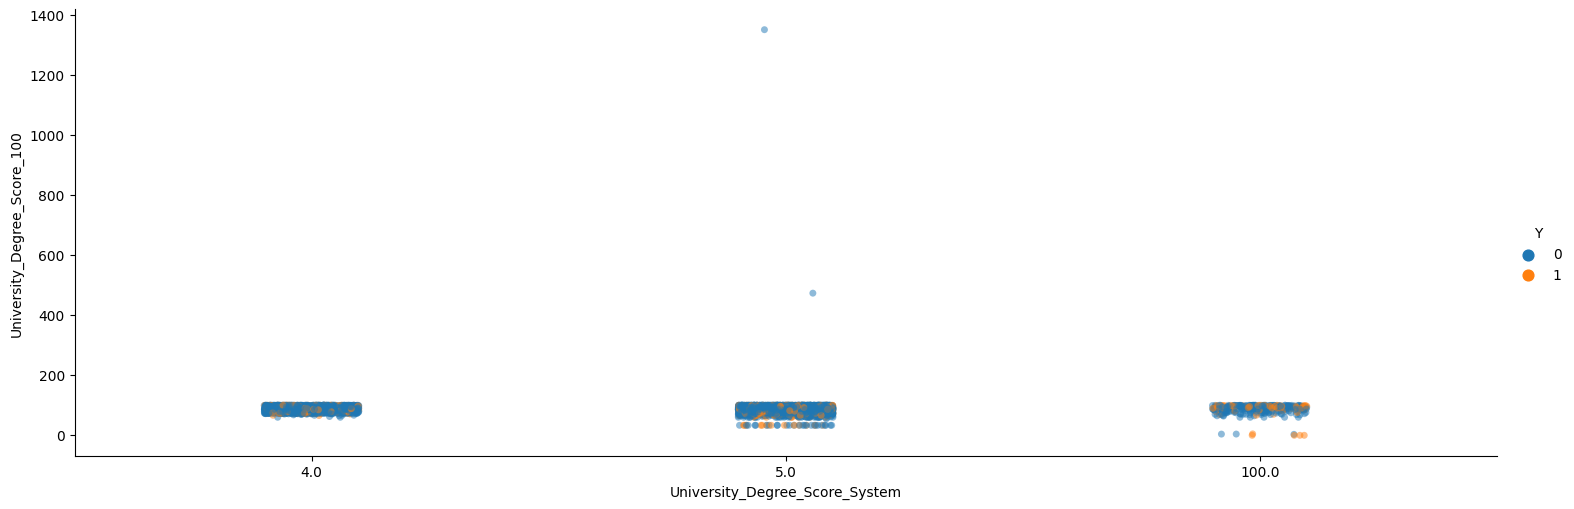

In [128]:
sns.catplot(x='University_Degree_Score_System', y='University_Degree_Score_100', 
            data=Dataset, hue="Y", kind="strip", alpha=0.5, aspect=3, sharex=False)

In [129]:
Dataset[Dataset["University_Degree_Score_100"] > 100]

,Student_ID,Age,Gender,Home_Region,Program_ID,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,College,University_Degree_Score,University_Degree_Score_System,University_Degree_Score_100,Employment_Status,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total_Regestration,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code
716,1d7432b5-52cb-450e-ab30-8390ad3bc129,20.0,أنثى,منطقة الرياض,1dcb8c62-4789-4e37-80d3-affdc652522c,مبتدئ,حضوري,2022-09-04,2022-09-15,12,نعم,ثانوي,NaN,NaN,98.8,5.0,1350.6334,Student,0,0,0,2,0,0,0,0,1,0,0,0,3,0,0.0,0,0,9,9,CAUF_SWPS
5234,cf3ef0d9-3763-4133-a6c8-31fb112ac5b4,26.0,أنثى,منطقة الرياض,3ec67853-6b57-48cc-9bc6-956e286a7c65,متوسط,حضوري,2023-04-02,2023-04-06,5,نعم,البكالوريوس,Information Technology,NaN,33.0,5.0,473.3220,Graduate,0,0,0,9,0,0,1,0,0,0,0,0,10,0,0.0,1,0,4,4,CAUF_ERST


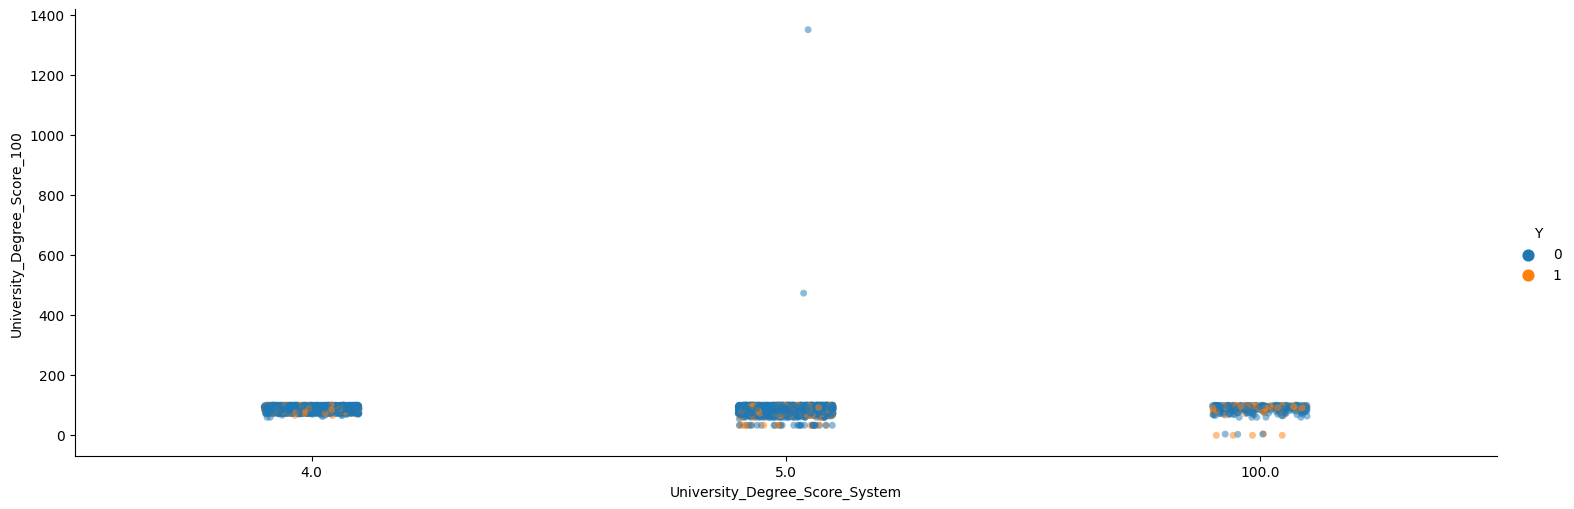

In [130]:
sns.catplot(x='University_Degree_Score_System', y='University_Degree_Score_100', 
            data=Dataset, hue="Y", kind="strip", alpha=0.5, aspect=3, sharex=False)

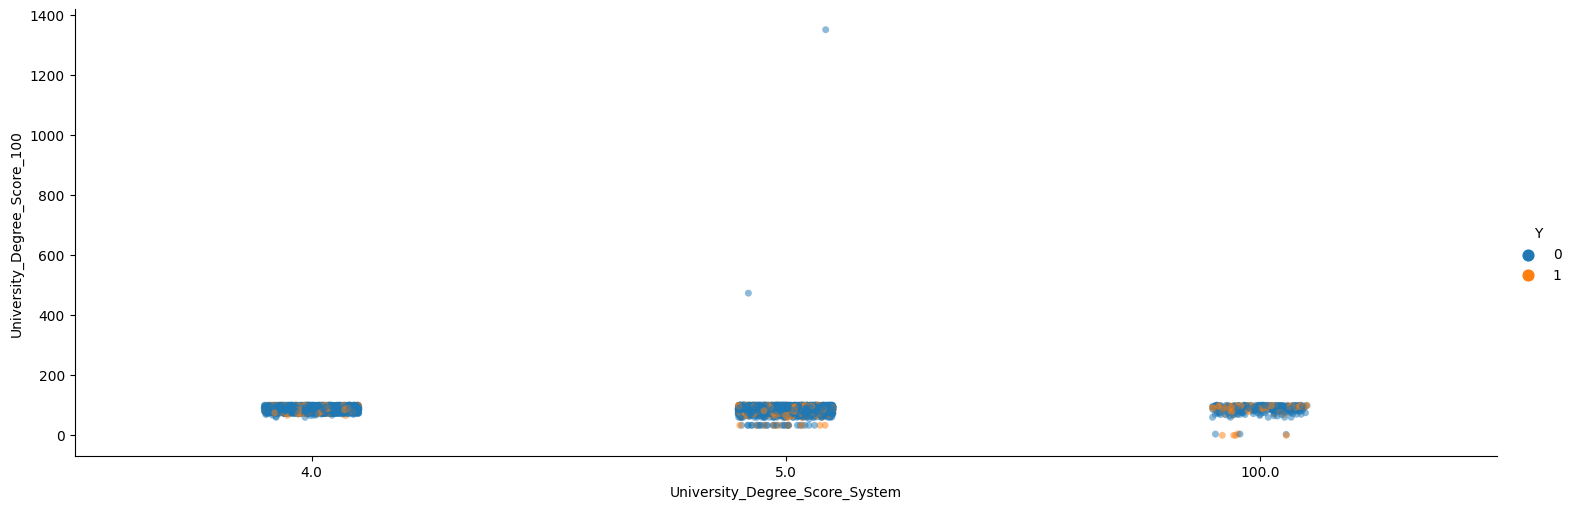

In [131]:
sns.catplot(x='University_Degree_Score_System', y='University_Degree_Score_100', 
            data=Dataset, hue="Y", kind="strip", alpha=0.5, aspect=3, sharex=False)

**It is better now, but we stil have some illogical outliers "the zeros out of 5 and the scores less than 60 out of 100"**

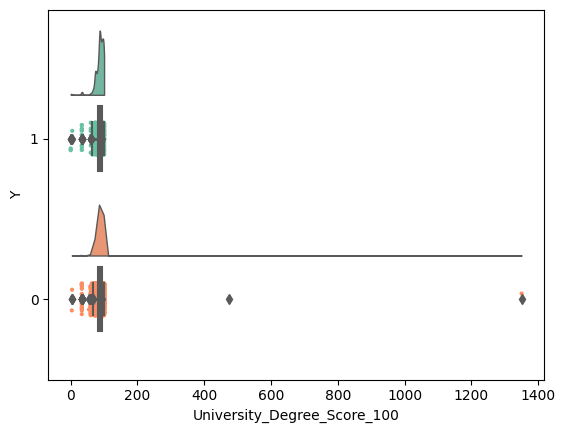

In [132]:
ax = pt.RainCloud(y = Dataset['University_Degree_Score_100'], x = Dataset['Y'].astype('str'), 
                  width_viol = .8,
                  width_box = .4,
                  orient = 'h',
                  move = .0)

In [133]:

Dataset['University_Degree_Score_100'].isna().sum()

76

In [134]:
Dataset.sample(1)

,Student_ID,Age,Gender,Home_Region,Program_ID,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,College,University_Degree_Score,University_Degree_Score_System,University_Degree_Score_100,Employment_Status,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total_Regestration,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code
5049,c8e526a4-24d6-4a9c-a1f9-939cec099ae2,22.0,أنثى,منطقة عسير,46e7d55e-f11d-47c3-8310-a907c1584671,مبتدئ,عن بعد,2022-07-03,2022-07-07,5,نعم,البكالوريوس,Information Systems,تكنولوجيا الاتصالات والمعلومات,5.0,5.0,99.998,NaN,0,0,0,4,0,0,0,0,2,0,0,5,11,0,0.0,0,0,7,7,ABIR__


In [135]:
Dataset["University_Degree_Score_100"].describe()

count    6374.000000
mean       87.518723
std        19.415393
min         0.000000
25%        82.799430
50%        87.538311
75%        94.664800
max      1350.633400
Name: University_Degree_Score_100, dtype: float64

In [136]:
#helper for function8
def University_score_outof_100(Dataset):

    def calculate_score_100(row):
    
        # Score out of 4
        
        x1 = 1	
        y1 = 60
        
        x2 = 1.01	
        y2 = 60.13333334
        
        
        # slop: m = (y1 - y2) / (x1 - x2)
        m4 = (y1 - y2) / (x1 - x2)
        
        # (y-y1) = m(x-x1)  --> y = mx + (-mx1 + y1)  --> y =mx+b
        b4 = -m4*x1 + y1
        
        #print("score4 equation is: score100 =", round(m,3), "University Degree Score +", round(b,3))
        
        # ---------------------------
        # Score out of 5
        
        x1 = 2	
        y1 = 60
        
        x2 = 2.01	
        y2 = 60.13333334
        
        
        # slop: m = (y1 - y2) / (x1 - x2)
        m5 = (y1 - y2) / (x1 - x2)
        
        # (y-y1) = m(x-x1)  --> y = mx + (-mx1 + y1)  --> y =mx+b
        b5 = -m5*x1 + y1
        
        #print("score5 equation is: score100 =", round(m,3), "University Degree Score +", round(b,3))
        
        # ---------------------------
        # Score out of 100
        
        x1 = 60	
        y1 = 60
        
        x2 = 60.1	
        y2 = 60.1
        
        
        # slop: m = (y1 - y2) / (x1 - x2)
        m100 = (y1 - y2) / (x1 - x2)
        
        # (y-y1) = m(x-x1)  --> y = mx + (-mx1 + y1)  --> y =mx+b
        b100 = -m100*x1 + y1
        
        #print("score100 equation is: score100 =", round(m,3), "University Degree Score +", round(b,3))
        
        # ---------------------------
        
        if row['University_Degree_Score_System'] == 4:
            return m4 * row['University_Degree_Score'] + b4
        elif row['University_Degree_Score_System'] == 5:
            return m5 * row['University_Degree_Score'] + b5
        elif row['University_Degree_Score_System'] == 100:
            return row['University_Degree_Score']
        else:
            return None  # or any default value you prefer
    
    def University(Dataset):
        Dataset['University_Degree_Score_100'] = Dataset.apply(calculate_score_100, axis=1)
        Dataset['University_Degree_Score_100'] = round(Dataset['University_Degree_Score_100'],2)

        return Dataset
    
    return University(Dataset)

In [137]:
# function8

def University_Score_Cleaning(Dataset):
    Dataset['University_Degree_Score'].replace(0.00, np.NaN, inplace=True)
    #-------------------------
    
    # This function update University_Degree_Score_System using University_Degree_Score to make it make sense
    def fix_score(Dataset):
        # update scors between 4 and 5 which is not out of 5
        to_update_Score_System_to_5 = Dataset.loc[(
            (Dataset.University_Degree_Score>4) 
            & (Dataset.University_Degree_Score<=5) 
            & (Dataset.University_Degree_Score_System != 5.0))]
        
        for index, student in to_update_Score_System_to_5.iterrows():
            index = Dataset.index[Dataset['Student_ID'] == student.Student_ID]
            Dataset.loc[index, ['University_Degree_Score_System']] = [5]
    
        
        # update scors between 5 and 100 which is not out of 100
        to_update_Score_System_to_100 = Dataset.loc[(
            (Dataset.University_Degree_Score>5) 
            & (Dataset.University_Degree_Score<=100) 
            & (Dataset.University_Degree_Score_System != 100))]
        
        for index, student in to_update_Score_System_to_100.iterrows():
            index = Dataset.index[Dataset['Student_ID'] == student.Student_ID]
            Dataset.loc[index, ['University_Degree_Score_System']] = [100]
    #------------------------- use the help function that was defined in the above function 
       
    Dataset = University_score_outof_100(Dataset)
    
    #-------------------------
    Dataset["University_Degree_Score_100"] = np.where(Dataset["University_Degree_Score_100"] < 60, np.nan, Dataset["University_Degree_Score_100"])
    Dataset["University_Degree_Score_100"] = np.where(Dataset["University_Degree_Score_100"] > 100, np.nan, Dataset["University_Degree_Score_100"])

    #-------------------------
    Dataset.drop(['University_Degree_Score_System','University_Degree_Score'], inplace=True, axis=1)

    return Dataset

In [138]:
Dataset = University_Score_Cleaning(Dataset)

# Check min & max
Dataset.describe()

,Age,Program_Start_Date,Program_End_Date,Program_Days,University_Degree_Score_100,Y,PCRF,GRST,CAUF,INFA,ABIR,SERU,TOSL,APMR,DTFH,QWLM,N/A,Total_Regestration,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month
count,6364.000000,6450,6450,6450.000000,6326.000000,6450.000000,6450.000000,6450.000000,6450.000000,6450.00000,6450.000000,6450.000000,6450.0,6450.000000,6450.000000,6450.000000,6450.000000,6450.000000,6450.000000,6450.000000,6450.000000,6450.000000,6450.000000,6450.000000
mean,26.801540,2023-04-17 11:45:42.697674240,2023-05-06 02:50:47.441860352,19.628527,87.700177,0.161085,1.840930,0.282791,2.951008,0.91969,0.110078,0.076744,0.0,1.657364,0.004186,0.012403,1.905116,9.821705,0.168992,0.064948,0.097364,0.142171,6.526202,6.724806
min,18.000000,2022-06-05 00:00:00,2022-06-09 00:00:00,3.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,23.000000,2023-01-08 00:00:00,2023-01-26 00:00:00,5.000000,83.200000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000
50%,25.000000,2023-04-02 00:00:00,2023-04-13 00:00:00,12.000000,87.730000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,7.000000,7.000000
75%,29.000000,2023-07-23 00:00:00,2023-08-31 00:00:00,19.000000,94.670000,0.000000,2.000000,0.000000,4.000000,1.00000,0.000000,0.000000,0.0,2.000000,0.000000,0.000000,2.000000,13.000000,0.000000,0.000000,0.000000,0.000000,10.000000,10.000000
max,55.000000,2024-01-15 00:00:00,2024-01-25 00:00:00,292.000000,100.000000,1.000000,27.000000,4.000000,45.000000,13.00000,4.000000,2.000000,0.0,19.000000,2.000000,1.000000,47.000000,109.000000,8.000000,4.800000,1.000000,1.000000,12.000000,12.000000
std,5.490585,NaN,NaN,32.222031,8.773093,0.367638,3.348169,0.614876,4.467462,1.63589,0.395322,0.279837,0.0,2.634350,0.073550,0.110685,4.113484,11.893809,0.489904,0.365566,0.296476,0.349252,3.542097,3.528203


## Student ID

We will drop it later

In [139]:
#Dataset.drop(columns=['Student_ID'], inplace = True)


## Completed Degree

In [140]:
CompletedDegree = pd.crosstab(Dataset["Completed_Degree"], Dataset["Y"]).T
CompletedDegree

Completed_Degree,لا,نعم
Y,,
0,639,4772
1,700,339


In [141]:
percentage_distribution = CompletedDegree.div(CompletedDegree.sum(axis=0), axis=1) * 100

# Display the percentage distribution
percentage_distribution

Completed_Degree,لا,نعم
Y,,
0,47.722181,93.367247
1,52.277819,6.632753


This seemd to be a very important feature since the student with completed degree associated with very high percentage of completing programs. On the other hand, more than half of the  students with no completed degree withdrawal from the program

## Registration columns

In [142]:
Dataset.drop(columns=["Total_Regestration",'PCRF', 'GRST', 'CAUF', 'INFA', 'ABIR', 'SERU', 'TOSL', 'APMR', 'DTFH', 'QWLM', 'N/A'], inplace= True)

In [143]:
Dataset.columns

Index(['Student_ID', 'Age', 'Gender', 'Home_Region', 'Program_ID', 'Program_Skill_Level', 'Program_Presentation_Method', 'Program_Start_Date', 'Program_End_Date', 'Program_Days', 'Completed_Degree', 'Level_of_Education', 'Education_Speaciality_Translated', 'College', 'University_Degree_Score_100', 'Employment_Status', 'Y', 'Cumulative_Completed_Programs', 'Withdrawals_scores', 'Is_ramadan', 'Is_summer', 'start_month', 'end_month', 'Full_Program_Category_Code'], dtype='object')

In [144]:
display(Dataset.sample(2))
print(Dataset.shape)

,Student_ID,Age,Gender,Home_Region,Program_ID,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,College,University_Degree_Score_100,Employment_Status,Y,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code
856,23291eb6-f188-4582-8abf-c15a5961ac5b,23.0,أنثى,منطقة الرياض,71232fc2-3531-4297-a355-d83628f945bb,NaN,حضوري,2023-03-05,2023-03-09,5,نعم,البكالوريوس,Computer Science,NaN,98.8,Other,0,0,0.0,0,0,3,3,APMR_SWPS
4585,b63ad04d-0399-422c-918e-bd9b43578274,26.0,أنثى,منطقة الرياض,28730cba-4bc2-4eb8-84ce-3002895e600d,متوسط,حضوري,2023-07-09,2023-08-03,26,نعم,البكالوريوس,Information Systems,NaN,95.6,Unemployed,0,0,0.0,0,1,7,8,APMR_KLTM


(6450, 24)


We think that using the registration is not logical since there is no date referes to when these stat was taken. 
<br>
Therfore, we will also drop the column we created from the registration file


In [145]:
#Dataset.drop(columns=["is_it_this program"], inplace= True)

# Dealing with missing values

In [146]:
# missing values
Dataset.isnull().sum().sort_values(ascending=False).head(10)

College                             3831
Program_Skill_Level                 1643
Employment_Status                    551
Education_Speaciality_Translated     271
University_Degree_Score_100          124
Age                                   86
Level_of_Education                    21
Home_Region                            2
end_month                              0
start_month                            0
dtype: int64

### Level_of_Education

In [147]:
Dataset['Level_of_Education'].value_counts()

Level_of_Education
البكالوريوس    5349
الماجستير       477
الدبلوم         308
ثانوي           265
الدكتوراه        30
Name: count, dtype: int64

In [148]:
Dataset["Level_of_Education"].isnull().sum()

21

**The percentage of classes after adding the missing values to the most frequent class increased less than 1%, so there is no much harm of replacing the missing values to the "البكالوريوس"**
- 83.20%
- 83.25%

In [149]:
Bachelor = Dataset[['Level_of_Education']].value_counts().iloc[0] 
Master = Dataset[['Level_of_Education']].value_counts().iloc[1] 
Diplom = Dataset[['Level_of_Education']].value_counts().iloc[2] 
Secondary = Dataset[['Level_of_Education']].value_counts().iloc[3] 
phd = Dataset[['Level_of_Education']].value_counts().iloc[4] 
missing = Dataset['Level_of_Education'].isnull().sum()

print(Bachelor/ (Bachelor+Master+Diplom+Secondary+phd))
print((Bachelor+missing)/ (Bachelor+missing+Master+Diplom+Secondary+phd))


0.8320111992533831

0.8325581395348837


In [150]:
Dataset["Level_of_Education"].fillna(Dataset[['Level_of_Education']].value_counts().index[0][0], inplace=True)
Dataset["Level_of_Education"].isnull().sum()

0

In [151]:
Dataset[['Level_of_Education']].value_counts().index[0][0]

'البكالوريوس'

In [152]:
### Creating a pie chart later

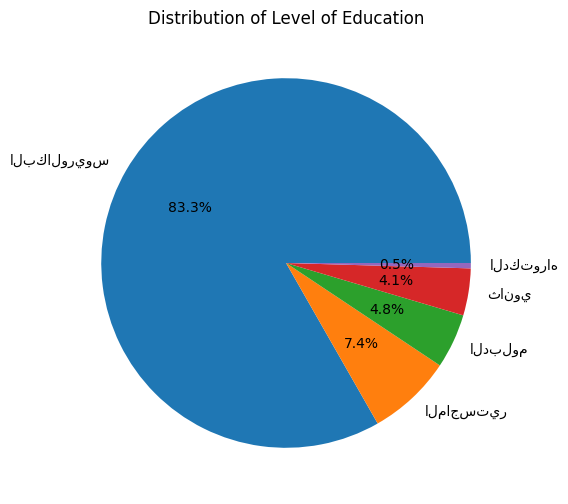

In [153]:
level_counts = Dataset['Level_of_Education'].value_counts()

# Set the figure size
fig, ax = plt.subplots(figsize=(10,6))

# Create the pie chart
ax.pie(level_counts, labels=level_counts.index, autopct='%1.1f%%')

# Set the title
ax.set_title('Distribution of Level of Education')

# Show the chart
plt.show()

### Age

In [154]:
Dataset["Age"].isnull().sum()

86

**We decided to try filling the few missing values of Age by the median because:**
- There are not to many missingness
- Median not the mean because it is right skewed not bell curve 

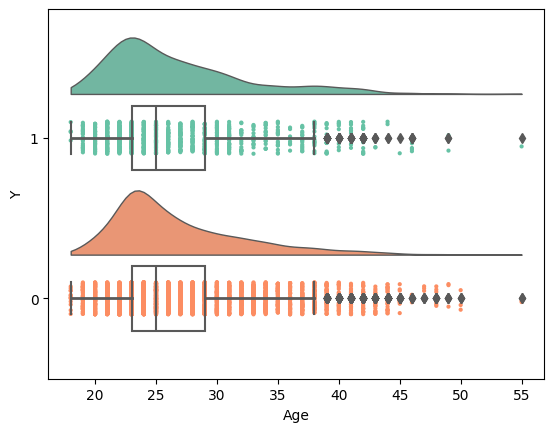

In [155]:
import ptitprince as pt

ax = pt.RainCloud(y = Dataset['Age'], x = Dataset['Y'].astype('str'), 
                  width_viol = .8,
                  width_box = .4,
                  orient = 'h',
                  move = .0)

- To make the imputation more realstic, we will impute by the help of Level_of_Education

In [156]:
Dataset['Age'].describe()

count    6364.000000
mean       26.801540
std         5.490585
min        18.000000
25%        23.000000
50%        25.000000
75%        29.000000
max        55.000000
Name: Age, dtype: float64

In [157]:
 Dataset.groupby('Level_of_Education')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Level_of_Education,,,,,,,,
البكالوريوس,5306.0,26.391632,4.940669,18.0,23.0,25.0,29.00,55.0
الدبلوم,304.0,26.269737,6.472557,18.0,22.0,24.0,29.00,45.0
الدكتوراه,30.0,37.266667,6.715568,23.0,34.0,38.5,41.75,50.0
الماجستير,472.0,33.677966,5.036818,20.0,30.0,33.0,37.00,50.0
ثانوي,252.0,21.948413,3.920693,18.0,20.0,21.0,22.00,41.0


In [158]:
import pandas as pd

# Assuming Dataset is your DataFrame
# Replace 'Level_of_Education' and 'Age' with actual column names from your DataFrame

# Calculate median age for each category of Level_of_Education
median_age_by_education = Dataset.groupby('Level_of_Education')['Age'].transform('median')

# Fill missing values in Age column with the calculated median age based on Level_of_Education
Dataset['Age'] = Dataset['Age'].fillna(median_age_by_education)

# Describe the filled Age column
Dataset['Age'].describe()



count    6450.000000
mean       26.775039
std         5.466125
min        18.000000
25%        23.000000
50%        25.000000
75%        29.000000
max        55.000000
Name: Age, dtype: float64

In [159]:
Dataset['Age'].isna().sum()

0

In [160]:
Dataset[Dataset['Age'].isna() == True]

,Student_ID,Age,Gender,Home_Region,Program_ID,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,College,University_Degree_Score_100,Employment_Status,Y,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code


### University_Degree_Score_100

In [161]:
Dataset['University_Degree_Score_100'].isna().sum()

124

In [162]:
Dataset['University_Degree_Score_100'].fillna(Dataset['University_Degree_Score_100'].median(), inplace=True)

In [163]:
Dataset['University_Degree_Score_100'].isna().sum()

0

In [164]:
Dataset["University_Degree_Score_100"].describe()

count    6450.000000
mean       87.700750
std         8.688341
min        60.000000
25%        83.330000
50%        87.730000
75%        94.670000
max       100.000000
Name: University_Degree_Score_100, dtype: float64

In [165]:
#To replace any values greater than 100 or equal to 0 in the “University_Degree_Score_100” dataset with the median

# Calculate the median
median_value = Dataset["University_Degree_Score_100"].median()

# Replace values greater than 100 with the median
Dataset.loc[Dataset["University_Degree_Score_100"] > 100, "University_Degree_Score_100"] = median_value

# Replace values equal to 0 with the median
Dataset.loc[Dataset["University_Degree_Score_100"] < 40, "University_Degree_Score_100"] = median_value

#check
Dataset["University_Degree_Score_100"].describe()

count    6450.000000
mean       87.700750
std         8.688341
min        60.000000
25%        83.330000
50%        87.730000
75%        94.670000
max       100.000000
Name: University_Degree_Score_100, dtype: float64

### Education_Speaciality_Translated

In [166]:
Dataset['College'].value_counts()

College
تكنولوجيا الاتصالات والمعلومات         2277
الأعمال والإدارة والقانون               150
العلوم الطبيعية والرياضيات والإحصاء      62
الهندسة والتصنيع والبناء                 43
الفنون والعلوم الإنسانية                 37
العلوم الاجتماعية والصحافة والإعلام      25
التعليم                                  19
الصحة والرفاة                             4
البرامج والمؤهلات العامة                  2
Name: count, dtype: int64

In [167]:
# We can conclude that we can not use the college to fill in the EDU SPEC, because whenever EDU SPEC is missing
# the college is missing as well.


data =  Dataset.loc[:, ['Education_Speaciality_Translated', 'College']]


data[data['Education_Speaciality_Translated'].isna()]


,Education_Speaciality_Translated,College
23,NaN,NaN
48,NaN,NaN
73,NaN,NaN
79,NaN,NaN
80,NaN,NaN
...,...,...
6372,NaN,NaN
6373,NaN,NaN
6436,NaN,NaN
6437,NaN,NaN


In [168]:
Dataset['Education_Speaciality_Translated'].value_counts()

Education_Speaciality_Translated
Computer Science                               2036
Information Technology                         1074
Information Systems                             951
Other                                           392
Management Information Systems                  271
Software Engineering                            247
Computer Networks & Computer Enigneering        216
Computer Engineering                            170
Cyber Security                                  135
Computer Science And Information Technology     120
Electricity Engineering & Electronics           114
Applied Mathematics                              91
Business Management                              82
Product Design                                   69
Non-Specialist                                   55
English Language                                 54
Media                                            51
Mechanical Engineering                           51
Name: count, dtype: int64

In [169]:
# For temporary
# we delete almost 171 rows
# Many rows with missing value already deleted after deleting the university rate feature

Dataset.dropna(subset=['Education_Speaciality_Translated'],inplace=True)
Dataset['Education_Speaciality_Translated'].isna().sum()

0

### Collegue

In [170]:
# College is similar to Education Specialty but more general. 
# Also, it has too many missing values, therefore, we will drop it.
Dataset.drop("College", axis =1, inplace=True)

### Program_Skill_Level 

In [171]:
Dataset.isnull().sum().sort_values()

Student_ID                             0
start_month                            0
Is_summer                              0
Is_ramadan                             0
Withdrawals_scores                     0
Cumulative_Completed_Programs          0
Y                                      0
University_Degree_Score_100            0
Education_Speaciality_Translated       0
end_month                              0
Level_of_Education                     0
Program_Days                           0
Program_End_Date                       0
Program_Start_Date                     0
Program_Presentation_Method            0
Program_ID                             0
Gender                                 0
Age                                    0
Completed_Degree                       0
Full_Program_Category_Code             0
Home_Region                            1
Employment_Status                    473
Program_Skill_Level                 1589
dtype: int64

**WE will use RFclassfier to impute thw 1590 values** <br>
We will train a model using the non null values, thin predict the Null values.

In [172]:
Dataset.Program_Skill_Level.describe()

count      4590
unique        3
top       متوسط
freq       2033
Name: Program_Skill_Level, dtype: object

In [173]:
total = Dataset.Program_Skill_Level.describe()[0]
most_frequent = Dataset.Program_Skill_Level.describe()[-1]

In [174]:
print("We need a model that of accuracy at least higher than %",round(most_frequent/ total*100,2))

We need a model that of accuracy at least higher than % 44.29


In [175]:
print("Full number of rows: ",Dataset.shape[0])
pro_skill_df = Dataset.dropna(subset=["Program_Skill_Level"])
print("filtered number of rows: ", pro_skill_df.shape[0])

Full number of rows:  6179

filtered number of rows:  4590


In [176]:
pro_skill_df.columns

Index(['Student_ID', 'Age', 'Gender', 'Home_Region', 'Program_ID', 'Program_Skill_Level', 'Program_Presentation_Method', 'Program_Start_Date', 'Program_End_Date', 'Program_Days', 'Completed_Degree', 'Level_of_Education', 'Education_Speaciality_Translated', 'University_Degree_Score_100', 'Employment_Status', 'Y', 'Cumulative_Completed_Programs', 'Withdrawals_scores', 'Is_ramadan', 'Is_summer', 'start_month', 'end_month', 'Full_Program_Category_Code'], dtype='object')

In [177]:
X = pro_skill_df.drop(columns=["Employment_Status", "Program_Skill_Level", "Y",  'Program_Start_Date', 'Program_End_Date', "Student_ID","Program_ID",
                              "Withdrawals_scores", "Cumulative_Completed_Programs"])
y = pro_skill_df["Program_Skill_Level"]


In [178]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

In [179]:
cat_onehot = X_train.select_dtypes('O').columns

In [180]:
cat_onehot = ['Gender', 'Home_Region', 'Full_Program_Category_Code','Program_Presentation_Method',
              'Completed_Degree', 'Level_of_Education', 'Education_Speaciality_Translated',
              'Is_ramadan', 'Is_summer']


In [181]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler

column_trans = make_column_transformer(
                        (OneHotEncoder(handle_unknown="ignore", sparse=False, drop = "if_binary"), cat_onehot),
                         remainder=StandardScaler(),
                         verbose_feature_names_out=False) # MinMaxScaler()

column_trans=column_trans.set_output(transform="pandas")

In [182]:

from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier


operations = [("encoder", column_trans),
              ("RF_model", RandomForestClassifier(random_state=101, class_weight="balanced"))]  


RF_pipe_model = Pipeline(steps=operations)

RF_pipe_model.fit(X_train, y_train)

Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Gender', 'Home_Region',
                                                   'Full_Program_Category_Code',
                                                   'Program_Presentation_Method',
                                                   'Completed_Degree',
                                                   'Level_of_Education',
                                                   'Education_Speaciality_Translated',
                                                   'Is_ramadan',
                                                   'Is_summer'])],
                                   verbose_feature_names_out=False)),
                ('RF_model',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=101))])

In [183]:
# This function will be used frequently
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [184]:
eval_metric(RF_pipe_model, X_train, y_train, X_test, y_test)

Test_Set

[[372   3   4]

 [  9 123   1]

 [ 19   3 384]]

              precision    recall  f1-score   support



       مبتدئ       0.93      0.98      0.96       379

       متقدم       0.95      0.92      0.94       133

       متوسط       0.99      0.95      0.97       406



    accuracy                           0.96       918

   macro avg       0.96      0.95      0.95       918

weighted avg       0.96      0.96      0.96       918





Train_Set

[[1513    0    1]

 [   0  531    0]

 [   0    2 1625]]

              precision    recall  f1-score   support



       مبتدئ       1.00      1.00      1.00      1514

       متقدم       1.00      1.00      1.00       531

       متوسط       1.00      1.00      1.00      1627



    accuracy                           1.00      3672

   macro avg       1.00      1.00      1.00      3672

weighted avg       1.00      1.00      1.00      3672




In [185]:
RF_pipe_model = Pipeline(steps=operations)

scores = cross_validate(RF_pipe_model,
                        X_train,
                        y_train,
                        cv = 10,
                        return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_score     0.944989
train_score    0.999274
dtype: float64

In [186]:
# start with these, if the best result is on the edge, we may investigate more on that area

# start with these, if the best result is on the edge, we may investigate more on that area

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_dist = {
    'RF_model__n_estimators': randint(20, 100),
    'RF_model__max_features': [2, 4, 'sqrt'],
    'RF_model__max_depth': randint(2, 6),
    'RF_model__min_samples_split': randint(2, 6),
    'RF_model__min_samples_leaf': randint(2, 6),
    'RF_model__max_samples': [0.2,0.3,0.4, 0.5, 0.8, 1]
}

In [189]:
my_n_iter = 500
RF_pro_skill_model = Pipeline(steps=operations)

RF_pro_skill_grid = RandomizedSearchCV(
    RF_pro_skill_model, param_distributions=param_dist, n_iter=120, n_jobs=-1,
 cv=5,verbose=1, return_train_score=True)

In [190]:
RF_pro_skill_grid.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('encoder',
                                              ColumnTransformer(remainder=StandardScaler(),
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(drop='if_binary',
                                                                                             handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['Gender',
                                                                                'Home_Region',
                                                                                'Full_Program_Category_Code',
                                                                                'Program_Presentation_Method',
                                                                                'Completed_Degree',
                                                                                'Level_of_Education',
                                                                                'Education_Speacialit...
                                        'RF_model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000025778FBBE50>,
                                        'RF_model__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002577CDE50D0>,
                                        'RF_model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000257790D7670>},
                   return_train_score=True, verbose=1)

In [191]:
eval_metric(RF_pro_skill_grid, X_train, y_train, X_test, y_test)

Test_Set

[[258 111  10]

 [  4 129   0]

 [ 38  89 279]]

              precision    recall  f1-score   support



       مبتدئ       0.86      0.68      0.76       379

       متقدم       0.39      0.97      0.56       133

       متوسط       0.97      0.69      0.80       406



    accuracy                           0.73       918

   macro avg       0.74      0.78      0.71       918

weighted avg       0.84      0.73      0.75       918





Train_Set

[[1045  416   53]

 [  32  499    0]

 [ 135  336 1156]]

              precision    recall  f1-score   support



       مبتدئ       0.86      0.69      0.77      1514

       متقدم       0.40      0.94      0.56       531

       متوسط       0.96      0.71      0.82      1627



    accuracy                           0.74      3672

   macro avg       0.74      0.78      0.71      3672

weighted avg       0.84      0.74      0.76      3672




In [192]:
RF_pro_skill_grid.best_params_

{'RF_model__max_depth': 5,
 'RF_model__max_features': 'sqrt',
 'RF_model__max_samples': 0.8,
 'RF_model__min_samples_leaf': 3,
 'RF_model__min_samples_split': 2,
 'RF_model__n_estimators': 99}

In [193]:

# from sklearn.pipeline import Pipeline
# from xgboost import XGBClassifier


# operations = [("encoder", column_trans),
#               ("RF_model", RandomForestClassifier(random_state=101, class_weight="balanced",
#                                                  max_depth=4, max_features=2,
#                                                  max_samples=0.5, min_samples_leaf = 2,
#                                                  min_samples_split=2, n_estimators=200))]  


# RF_pipe_model = Pipeline(steps=operations)

# RF_pipe_model.fit(X_train, y_train)

In [194]:
# eval_metric(RF_pipe_model, X_train, y_train, X_test, y_test)

In [195]:
PS_NAN_df = Dataset[Dataset["Program_Skill_Level"].isnull() == True]
PS_NAN_df = PS_NAN_df.drop(columns=["Y", "Program_Skill_Level", "Employment_Status"])
PS_NAN_df.sample(2)

,Student_ID,Age,Gender,Home_Region,Program_ID,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,University_Degree_Score_100,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code
3517,8b85935a-0ba6-4df9-96b9-ccebad2d08cc,25.0,أنثى,منطقة القصيم,bc72074a-cac8-4dab-9530-018072bbbcd2,حضوري,2023-06-11,2023-06-22,12,نعم,البكالوريوس,Computer Science,94.27,0,0.0,0,0,6,6,APMR_SRTA
4901,c28ca3eb-231c-4d5d-bf15-c1089d1f17d9,24.0,أنثى,منطقة الرياض,b73a41c2-ca0b-4514-a3fc-98e2141a6cea,عن بعد,2023-01-08,2023-01-12,5,لا,البكالوريوس,Other,86.67,0,0.0,0,0,1,1,PCRF_PCRF


In [196]:
import pandas as pd

# 4. Predict on the new data (assuming it's in a DataFrame named 'ES_NAN_df')
new_data_predictions = RF_pro_skill_grid.predict(PS_NAN_df)

# 5. Create a new DataFrame with predictions and corresponding indices
predictions_df = pd.DataFrame({"Program_Skill_Level_Predicted": new_data_predictions}, index=PS_NAN_df.index)

# 6. Concatenate the predictions DataFrame with the original DataFrame
Dataset = pd.concat([Dataset, predictions_df], axis=1)

# Now, Dataset will have a new column "Employment_Status_Predicted" with predictions


In [197]:
Dataset.loc[:,["Program_Skill_Level","Program_Skill_Level_Predicted"]].sample(5)

,Program_Skill_Level,Program_Skill_Level_Predicted
6399,متوسط,NaN
3784,مبتدئ,NaN
602,متوسط,NaN
5903,مبتدئ,NaN
4226,متوسط,NaN


In [198]:
import numpy as np

# Assuming "Employment_Status" and "Employment_Status_Predicted" are your column names
Dataset["Merged_Program_Skill_Level"] = Dataset["Program_Skill_Level"].combine_first(Dataset["Program_Skill_Level_Predicted"])

# If you want to ensure that there are no NaN values in the merged column
Dataset["Merged_Program_Skill_Level"].fillna(Dataset["Program_Skill_Level_Predicted"], inplace=True)
Dataset["Merged_Program_Skill_Level"].fillna(Dataset["Program_Skill_Level"], inplace=True)

# Drop the original columns if needed
Dataset.drop(["Program_Skill_Level", "Program_Skill_Level_Predicted"], axis=1, inplace=True)

Dataset.sample(4)

,Student_ID,Age,Gender,Home_Region,Program_ID,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,University_Degree_Score_100,Employment_Status,Y,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code,Merged_Program_Skill_Level
1372,3850c65a-f861-4955-a254-f60d5c101cbd,27.0,ذكر,المنطقة الشرقية,a342d46f-2357-4398-958c-a0a759f5d5eb,عن بعد,2023-09-17,2023-09-28,12,لا,البكالوريوس,Electricity Engineering & Electronics,85.33,Employee,0,0,0.0,0,0,9,9,APMR_SRTA,متوسط
4090,a26d21bd-93a0-49db-bd25-aa0488205e4c,24.0,أنثى,منطقة الرياض,f4781655-baa0-421c-af96-8bb8df6590c4,حضوري,2023-06-11,2023-06-15,5,نعم,البكالوريوس,Computer Science,73.33,Employee,0,0,0.0,0,0,6,6,PCRF_PCRF,مبتدئ
3098,7c0ec10d-e024-48d2-abb6-bbe3574ceef7,26.0,أنثى,منطقة الرياض,32bce2ad-426a-4096-b7d0-78b5f30bd8a0,حضوري,2023-05-14,2023-05-25,12,نعم,البكالوريوس,Software Engineering,94.67,Employee,0,0,0.0,0,0,5,5,ABIR_INFA,مبتدئ
2232,58fdeb34-e272-4df6-a9ec-66538d3f4a48,24.0,ذكر,منطقة الرياض,53efebf0-6779-48c2-9c72-2e0e7c2bf175,حضوري,2023-01-15,2023-01-19,5,نعم,البكالوريوس,Cyber Security,90.00,Graduate,0,0,0.0,0,0,1,1,PCRF_PCRF,متقدم


In [199]:
Dataset = Dataset.rename({"Merged_Program_Skill_Level": "Program_Skill_Level"}, axis=1)
Dataset.isnull().sum().sort_values(ascending=False)

Employment_Status                   473
Home_Region                           1
Student_ID                            0
University_Degree_Score_100           0
Full_Program_Category_Code            0
end_month                             0
start_month                           0
Is_summer                             0
Is_ramadan                            0
Withdrawals_scores                    0
Cumulative_Completed_Programs         0
Y                                     0
Education_Speaciality_Translated      0
Age                                   0
Level_of_Education                    0
Completed_Degree                      0
Program_Days                          0
Program_End_Date                      0
Program_Start_Date                    0
Program_Presentation_Method           0
Program_ID                            0
Gender                                0
Program_Skill_Level                   0
dtype: int64

### Employment_Status

In [200]:
Dataset.isnull().sum().sort_values()

Student_ID                            0
end_month                             0
start_month                           0
Is_summer                             0
Is_ramadan                            0
Withdrawals_scores                    0
Cumulative_Completed_Programs         0
Y                                     0
University_Degree_Score_100           0
Full_Program_Category_Code            0
Education_Speaciality_Translated      0
Completed_Degree                      0
Program_Days                          0
Program_End_Date                      0
Program_Start_Date                    0
Program_Presentation_Method           0
Program_ID                            0
Gender                                0
Age                                   0
Level_of_Education                    0
Program_Skill_Level                   0
Home_Region                           1
Employment_Status                   473
dtype: int64

**WE will use RFclassfier to impute thw 478 values** <br>
We will train a model using the non null values, thin predict the Null values.

In [201]:
Dataset.Employment_Status.describe()

count         5706
unique           5
top       Employee
freq          2732
Name: Employment_Status, dtype: object

In [202]:
total = Dataset.Employment_Status.describe()[0]
most_frequent = Dataset.Employment_Status.describe()[-1]


In [203]:
print("We need a model that of accuracy at least higher than",round(most_frequent/total*100,2))

We need a model that of accuracy at least higher than 47.88


In [204]:
print("Full number of rows: ",Dataset.shape[0])
emp_sta_df = Dataset.dropna(subset=["Employment_Status"])
print("filtered number of rows: ", emp_sta_df.shape[0])

Full number of rows:  6179

filtered number of rows:  5706


In [205]:
emp_sta_df.columns

Index(['Student_ID', 'Age', 'Gender', 'Home_Region', 'Program_ID', 'Program_Presentation_Method', 'Program_Start_Date', 'Program_End_Date', 'Program_Days', 'Completed_Degree', 'Level_of_Education', 'Education_Speaciality_Translated', 'University_Degree_Score_100', 'Employment_Status', 'Y', 'Cumulative_Completed_Programs', 'Withdrawals_scores', 'Is_ramadan', 'Is_summer', 'start_month', 'end_month', 'Full_Program_Category_Code', 'Program_Skill_Level'], dtype='object')

In [206]:
X = emp_sta_df.drop(columns=["Employment_Status", "Y",  'Program_Start_Date', 'Program_End_Date', "Student_ID","Program_ID"])
y = emp_sta_df["Employment_Status"]

In [207]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify = y)

In [208]:
cat_onehot = X_train.select_dtypes('O').columns

In [209]:
cat_onehot = ['Gender', 'Home_Region', 'Full_Program_Category_Code','Program_Presentation_Method',
              'Completed_Degree', 'Level_of_Education', 'Education_Speaciality_Translated',
               "Program_Skill_Level"]


In [210]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler

column_trans = make_column_transformer(
                        (OneHotEncoder(handle_unknown="ignore", sparse=False), cat_onehot),
                         remainder=StandardScaler(),
                         verbose_feature_names_out=False) # MinMaxScaler()

column_trans=column_trans.set_output(transform="pandas")

In [211]:

from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier


operations = [("encoder", column_trans),
              ("RF_model", RandomForestClassifier(random_state=101, class_weight="balanced"))]  


RF_pipe_model = Pipeline(steps=operations)

RF_pipe_model.fit(X_train, y_train)

Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Gender', 'Home_Region',
                                                   'Full_Program_Category_Code',
                                                   'Program_Presentation_Method',
                                                   'Completed_Degree',
                                                   'Level_of_Education',
                                                   'Education_Speaciality_Translated',
                                                   'Program_Skill_Level'])],
                                   verbose_feature_names_out=False)),
                ('RF_model',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=101))])

In [212]:
# This function will be used frequently
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [213]:
eval_metric(RF_pipe_model, X_train, y_train, X_test, y_test)

Test_Set

[[480  24   0  10  33]

 [ 80  60   0  22  24]

 [ 17   2   3   6   1]

 [ 18  20   0 112  13]

 [116  30   1  13  57]]

              precision    recall  f1-score   support



    Employee       0.68      0.88      0.76       547

    Graduate       0.44      0.32      0.37       186

       Other       0.75      0.10      0.18        29

     Student       0.69      0.69      0.69       163

  Unemployed       0.45      0.26      0.33       217



    accuracy                           0.62      1142

   macro avg       0.60      0.45      0.47      1142

weighted avg       0.60      0.62      0.59      1142





Train_Set

[[2185    0    0    0    0]

 [   0  744    0    0    0]

 [   0    0  117    0    0]

 [   0    0    0  649    0]

 [   0    0    0    0  869]]

              precision    recall  f1-score   support



    Employee       1.00      1.00      1.00      2185

    Graduate       1.00      1.00      1.00       744

       Other       1.00      1.00      1.0

In [214]:
RF_pipe_model = Pipeline(steps=operations)

scores = cross_validate(RF_pipe_model,
                        X_train,
                        y_train,
                        cv = 10,
                        return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_score     0.626434
train_score    1.000000
dtype: float64

In [215]:
# start with these, if the best result is on the edge, we may investigate more on that area

# start with these, if the best result is on the edge, we may investigate more on that area

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_dist = {
    'RF_model__n_estimators': randint(20, 150),
    'RF_model__max_features': [2, 4, 6, 8, 10, 12, 14, 16, 'sqrt'],
    'RF_model__max_depth': randint(2, 6),
    'RF_model__min_samples_split': randint(2, 6),
    'RF_model__min_samples_leaf': randint(2, 6),
    'RF_model__max_samples': [0.2,0.3,0.4, 0.5,0.6,0.7, 0.8, 1]
}

In [216]:


Knn_emp_sta_model = Pipeline(steps=operations)

Knn_emp_sta_model_grid = RandomizedSearchCV(
    Knn_emp_sta_model, param_distributions=param_dist, n_iter=my_n_iter, n_jobs=-1,
 cv=5,verbose=1, return_train_score=True)

In [217]:
Knn_emp_sta_model_grid.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('encoder',
                                              ColumnTransformer(remainder=StandardScaler(),
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['Gender',
                                                                                'Home_Region',
                                                                                'Full_Program_Category_Code',
                                                                                'Program_Presentation_Method',
                                                                                'Completed_Degree',
                                                                                'Level_of_Education',
                                                                                'Education_Speaciality_Translated',
                                                                                'Pr...
                                        'RF_model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002577D4C2250>,
                                        'RF_model__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002577D4B4340>,
                                        'RF_model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002577D406580>},
                   return_train_score=True, verbose=1)

In [218]:
eval_metric(Knn_emp_sta_model_grid, X_train, y_train, X_test, y_test)

Test_Set

[[388  62   2  15  80]

 [ 37  92   0  30  27]

 [ 12   3   0   8   6]

 [  6  27   0 117  13]

 [ 62  49   0  27  79]]

              precision    recall  f1-score   support



    Employee       0.77      0.71      0.74       547

    Graduate       0.39      0.49      0.44       186

       Other       0.00      0.00      0.00        29

     Student       0.59      0.72      0.65       163

  Unemployed       0.39      0.36      0.37       217



    accuracy                           0.59      1142

   macro avg       0.43      0.46      0.44      1142

weighted avg       0.59      0.59      0.59      1142





Train_Set

[[1595  254    3   66  267]

 [ 145  351    1  129  118]

 [  52    6    7   34   18]

 [  52   76    0  481   40]

 [ 281  190    0   77  321]]

              precision    recall  f1-score   support



    Employee       0.75      0.73      0.74      2185

    Graduate       0.40      0.47      0.43       744

       Other       0.64      0.06      0.1

In [219]:
# Create the table that has all folds results
overfit = pd.DataFrame(Knn_emp_sta_model_grid.cv_results_)

# create a new column that has the difference between mean training and testing scores of a combination
# Then, round it to 3 digits
overfit["diff"] = round(abs(overfit["mean_test_score"] -  overfit["mean_train_score"]),3)

# We don t want time or std or a spicific fold score, so wi will filter our columns
# Then, we will sort the values based on the best scores
df_overfit = overfit.loc[
   :,["params","mean_test_score", "mean_train_score", "diff", "rank_test_score"]
].sort_values([ "rank_test_score"], ascending=True)
df_overfit.head(20)

,params,mean_test_score,mean_train_score,diff,rank_test_score
41,"{'RF_model__max_depth': 5, 'RF_model__max_feat...",0.592463,0.613113,0.021,1
99,"{'RF_model__max_depth': 5, 'RF_model__max_feat...",0.589176,0.611908,0.023,2
16,"{'RF_model__max_depth': 3, 'RF_model__max_feat...",0.582384,0.591860,0.009,3
35,"{'RF_model__max_depth': 2, 'RF_model__max_feat...",0.579973,0.587533,0.008,4
94,"{'RF_model__max_depth': 3, 'RF_model__max_feat...",0.579095,0.593996,0.015,5
1,"{'RF_model__max_depth': 5, 'RF_model__max_feat...",0.577998,0.606869,0.029,6
51,"{'RF_model__max_depth': 2, 'RF_model__max_feat...",0.576472,0.582000,0.006,7
90,"{'RF_model__max_depth': 3, 'RF_model__max_feat...",0.576249,0.591806,0.016,8
85,"{'RF_model__max_depth': 2, 'RF_model__max_feat...",0.574932,0.576468,0.002,9
21,"{'RF_model__max_depth': 4, 'RF_model__max_feat...",0.574714,0.600515,0.026,10


In [220]:
Knn_emp_sta_model_grid.best_params_

{'RF_model__max_depth': 5,
 'RF_model__max_features': 14,
 'RF_model__max_samples': 0.2,
 'RF_model__min_samples_leaf': 3,
 'RF_model__min_samples_split': 3,
 'RF_model__n_estimators': 144}

In [221]:

# from sklearn.pipeline import Pipeline
# from xgboost import XGBClassifier


# operations = [("encoder", column_trans),
#               ("RF_model", RandomForestClassifier(random_state=101, class_weight="balanced",
#                                                  max_depth=3, max_features="sqrt",
#                                                  max_samples=0.2, min_samples_leaf = 2,
#                                                  min_samples_split=2, n_estimators=200))]  


# RF_pipe_model = Pipeline(steps=operations)

# RF_pipe_model.fit(X_train, y_train)

In [222]:
# eval_metric(RF_pipe_model, X_train, y_train, X_test, y_test)

In [223]:
ES_NAN_df = Dataset[Dataset["Employment_Status"].isnull() == True]
ES_NAN_df = ES_NAN_df.drop(columns=["Y",  "Employment_Status"])
ES_NAN_df.sample(2)

,Student_ID,Age,Gender,Home_Region,Program_ID,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,University_Degree_Score_100,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code,Program_Skill_Level
3077,7b1537da-eb56-45eb-8408-071ddac167d7,23.0,أنثى,منطقة الرياض,555795c5-5a97-43ae-ae84-cba8e6848fd7,حضوري,2023-07-16,2023-07-20,5,نعم,البكالوريوس,Applied Mathematics,86.67,0,0.0,0,1,7,7,APMR__,مبتدئ
5287,d0f076b3-a406-493e-bf46-68a4f229e5ac,27.0,ذكر,منطقة الرياض,8f595e68-1027-462b-85fd-bac14b4f7b70,حضوري,2023-10-08,2023-10-12,5,نعم,البكالوريوس,Computer Science,100.00,0,0.0,0,0,10,10,CAUF_SWPS,متقدم


In [224]:
import pandas as pd

# 4. Predict on the new data (assuming it's in a DataFrame named 'ES_NAN_df')
new_data_predictions = RF_pipe_model.predict(ES_NAN_df)

# 5. Create a new DataFrame with predictions and corresponding indices
predictions_df = pd.DataFrame({"Employment_Status_Predicted": new_data_predictions}, index=ES_NAN_df.index)

# 6. Concatenate the predictions DataFrame with the original DataFrame
Dataset = pd.concat([Dataset, predictions_df], axis=1)

# Now, Dataset will have a new column "Employment_Status_Predicted" with predictions


In [225]:
Dataset.sample(1)

,Student_ID,Age,Gender,Home_Region,Program_ID,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,University_Degree_Score_100,Employment_Status,Y,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code,Program_Skill_Level,Employment_Status_Predicted
1816,488ea1ca-6268-4e38-9da8-97fe7606834e,29.0,أنثى,المنطقة الشرقية,a342d46f-2357-4398-958c-a0a759f5d5eb,عن بعد,2023-09-17,2023-09-28,12,نعم,البكالوريوس,Computer Science,91.6,Employee,0,0,0.0,0,0,9,9,APMR_SRTA,متوسط,NaN


In [226]:
import numpy as np

# Assuming "Employment_Status" and "Employment_Status_Predicted" are your column names
Dataset["Merged_Employment_Status"] = Dataset["Employment_Status"].combine_first(Dataset["Employment_Status_Predicted"])

# If you want to ensure that there are no NaN values in the merged column
Dataset["Merged_Employment_Status"].fillna(Dataset["Employment_Status_Predicted"], inplace=True)
Dataset["Merged_Employment_Status"].fillna(Dataset["Employment_Status"], inplace=True)

# Drop the original columns if needed
Dataset.drop(["Employment_Status", "Employment_Status_Predicted"], axis=1, inplace=True)

Dataset.sample(1)

,Student_ID,Age,Gender,Home_Region,Program_ID,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,University_Degree_Score_100,Y,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code,Program_Skill_Level,Merged_Employment_Status
2027,50e8bf7b-8311-471e-b99a-f27e772462be,27.0,ذكر,منطقة مكة المكرمة,297e0bca-74b1-4533-86f9-2547b128c5d3,حضوري,2023-03-30,2023-12-02,248,نعم,البكالوريوس,Information Systems,86.4,0,0,0.0,1,0,3,12,TOSL_TOSL,متوسط,Unemployed


In [227]:
Dataset.rename({"Merged_Employment_Status": "Employment_Status"}, inplace= True, axis =1 )
Dataset.isnull().sum()

Student_ID                          0
Age                                 0
Gender                              0
Home_Region                         1
Program_ID                          0
Program_Presentation_Method         0
Program_Start_Date                  0
Program_End_Date                    0
Program_Days                        0
Completed_Degree                    0
Level_of_Education                  0
Education_Speaciality_Translated    0
University_Degree_Score_100         0
Y                                   0
Cumulative_Completed_Programs       0
Withdrawals_scores                  0
Is_ramadan                          0
Is_summer                           0
start_month                         0
end_month                           0
Full_Program_Category_Code          0
Program_Skill_Level                 0
Employment_Status                   0
dtype: int64

In [228]:
Dataset[['Home_Region']].value_counts().index[0][0]

'منطقة الرياض'

In [229]:
Dataset["Gender"].value_counts()

Gender
أنثى    3489
ذكر     2690
Name: count, dtype: int64

## Imputation Function

In [230]:
# Function9
# ALL imputations should be based on training dataset to prevent data leakage
def Imputation(train_df, to_impute_df, program_skill_model = None, Employment_Status_model =None ):
        
    # 1_Age 
    ## filled by the median of age based on the level of education
    if ("Age" in to_impute_df.columns) & ("Level_of_Education" in to_impute_df.columns):
        median_age_by_education = train_df.groupby('Level_of_Education')['Age'].transform('median')
        to_impute_df['Age'] = to_impute_df['Age'].fillna(median_age_by_education)
    
    # ------------------------------------------------------------------------------------------------------
    # 4 for categrical (most frequent) AND  For numerical (median)
     # Separating numeric and categorical columns

    drop_columns = ['Home_City', 'Technology_Type', 'Education_Speaciality', 'College', 'Job_Type', 'Still_Working']
    to_impute_df = to_impute_df.drop(columns=drop_columns)
    
    numeric_cols = to_impute_df.select_dtypes(include=['number']).columns 
    categorical_cols = to_impute_df.select_dtypes(include=['object', 'category']).columns
    
    # Exclude unwanted columns
    categorical_cols = [col for col in categorical_cols if col not in ['Program_Skill_Level', 'Employment_Status']]

    
    # Fill missing values in numeric columns with median
    to_impute_df[numeric_cols] = to_impute_df[numeric_cols].fillna(train_df[numeric_cols].median())
    
    # Fill missing values in categorical columns with most frequent value
    to_impute_df[categorical_cols] = to_impute_df[categorical_cols].fillna(train_df[categorical_cols].mode().iloc[0])
    # ------------------------------------------------------------------------------------------------------

    # 2_Program_Skill_Level
    if "Program_Skill_Level" in to_impute_df.columns:
        # columns = ["Student_ID","start_month", "Is_summer", "Is_ramadan", "Withdrawals_scores", "Cumulative_Completed_Programs", "Y",
        #            "University_Degree_Score_100", "Education_Speaciality_Translated", "end_month", "Level_of_Education", "Program_Days",
        #            "Program_End_Date", "Program_Start_Date", "Program_Presentation_Method", "Program_ID", "Gender", "Age", "Completed_Degree",
        #            "Full_Program_Category_Code", "Home_Region", "Employment_Status", "Program_Skill_Level"]
        # to_impute_df = to_impute_df.drop(columns=[columns])


        PS_NAN_df2 = to_impute_df[to_impute_df["Program_Skill_Level"].isnull() == True]
        PS_NAN_df2 = PS_NAN_df2.drop(columns=["Program_Skill_Level", "Employment_Status"])
        ## 4. Predict on the new data (assuming it's in a DataFrame named 'ES_NAN_df')
        new_data_predictions2 = program_skill_model.predict(PS_NAN_df2)
        
        ## 5. Create a new DataFrame with predictions and corresponding indices
        predictions_df2 = pd.DataFrame({"Program_Skill_Level_Predicted2": new_data_predictions2}, index=PS_NAN_df2.index)
        
        ## 6. Concatenate the predictions DataFrame with the original DataFrame
        to_impute_df = pd.concat([to_impute_df, predictions_df2], axis=1)
        
        ## Now, Dataset will have a new column "Employment_Status_Predicted" with predictions
        
        ## Assuming "Employment_Status" and "Employment_Status_Predicted" are your column names
        to_impute_df["Merged_Program_Skill_Level"] = to_impute_df["Program_Skill_Level"].combine_first(to_impute_df["Program_Skill_Level_Predicted2"])
        
        ## If you want to ensure that there are no NaN values in the merged column
        to_impute_df["Merged_Program_Skill_Level"].fillna(to_impute_df["Program_Skill_Level_Predicted2"], inplace=True)
        to_impute_df["Merged_Program_Skill_Level"].fillna(to_impute_df["Program_Skill_Level"], inplace=True)
        
        ## Drop the original columns if needed
        to_impute_df.drop(["Program_Skill_Level", "Program_Skill_Level_Predicted2"], axis=1, inplace=True)
        
        to_impute_df = to_impute_df.rename({"Merged_Program_Skill_Level": "Program_Skill_Level"}, axis=1)
    # ------------------------------------------------------------------------------------------------------
    
    # 3_Employment_Status
    if "Employment_Status" in to_impute_df.columns:
        ES_NAN_df2 = to_impute_df[to_impute_df["Employment_Status"].isnull() == True]
        ES_NAN_df2 = to_impute_df.drop(columns=["Employment_Status"])
        
        
        # 4. Predict on the new data (assuming it's in a DataFrame named 'ES_NAN_df')
        new_data_predictions2 = Employment_Status_model.predict(ES_NAN_df2)
        
        # # 5. Create a new DataFrame with predictions and corresponding indices
        predictions_df2 = pd.DataFrame({"Employment_Status_Predicted": new_data_predictions2}, index=ES_NAN_df2.index)
        
        # # 6. Concatenate the predictions DataFrame with the original DataFrame
        to_impute_df = pd.concat([to_impute_df, predictions_df2], axis=1)
        
        # Now, Dataset will have a new column "Employment_Status_Predicted" with predictions
        
        # Assuming "Employment_Status" and "Employment_Status_Predicted" are your column names
        to_impute_df["Merged_Employment_Status"] = to_impute_df["Employment_Status"].combine_first(to_impute_df["Employment_Status_Predicted"])
        
        # If you want to ensure that there are no NaN values in the merged column
        to_impute_df["Merged_Employment_Status"].fillna(to_impute_df["Employment_Status_Predicted"], inplace=True)
        to_impute_df["Merged_Employment_Status"].fillna(to_impute_df["Employment_Status"], inplace=True)
        
        # Drop the original columns if needed
        to_impute_df.drop(["Employment_Status", "Employment_Status_Predicted"], axis=1, inplace=True)
        
        to_impute_df.rename({"Merged_Employment_Status": "Employment_Status"}, inplace= True, axis =1 )
        
    # ------------------------------------------------------------------------------------------------------
    

    return (to_impute_df)

In [231]:
# Dataset = Imputation(Dataset, Dataset, program_skill_model = RF_pro_skill_grid, Employment_Status_model =Knn_emp_sta_model_grid )

In [235]:
categorical_cols = Dataset.select_dtypes(include=['object', 'category']).columns

# Exclude unwanted columns
categorical_cols = [col for col in categorical_cols if col not in ['Program_Skill_Level', 'Employment_Status']]


# Fill missing values in categorical columns with most frequent value
Dataset[categorical_cols] = Dataset[categorical_cols].fillna(Dataset[categorical_cols].mode().iloc[0])
Dataset.isnull().sum()

Student_ID                          0
Age                                 0
Gender                              0
Home_Region                         0
Program_ID                          0
Program_Presentation_Method         0
Program_Start_Date                  0
Program_End_Date                    0
Program_Days                        0
Completed_Degree                    0
Level_of_Education                  0
Education_Speaciality_Translated    0
University_Degree_Score_100         0
Y                                   0
Cumulative_Completed_Programs       0
Withdrawals_scores                  0
Is_ramadan                          0
Is_summer                           0
start_month                         0
end_month                           0
Full_Program_Category_Code          0
Program_Skill_Level                 0
Employment_Status                   0
dtype: int64

# Save & Load imputation Models & Dataset

In [ ]:
# import pickle

# #
# # Create your model here (same as above)
# #

# # Save to file in the current working directory
# pkl_filename = "Emp_Status_withdraw_adj_model.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(Knn_emp_sta_model_grid, file)



In [ ]:
# import pickle

# # Load from file
# pkl_filename = "Prog_Skill_withdraw_model.pkl"
# with open(pkl_filename, 'rb') as file:
#     Prog_Skill_imputation = pickle.load(file)
    

In [ ]:
# import pickle
# pkl_filename = "Emp_Status_withdraw_model.pkl"
# with open(pkl_filename, 'rb') as file:
#     Emp_Status_imputation = pickle.load(file)
    

In [ ]:
# import pickle

# #
# # Create your model here (same as above)
# #

# # Save to file in the current working directory
# pkl_filename = "Prog_Skill_withdraw_adj_model.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(RF_pro_skill_grid, file)



In [236]:
Dataset.to_csv("31_1_attempt.csv", index= False)

# Modelling

In [388]:
Dataset = pd.read_csv("31_1_attempt.csv")

In [389]:
Dataset.sample(3)

,Student_ID,Age,Gender,Home_Region,Program_ID,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,University_Degree_Score_100,Y,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code,Program_Skill_Level,Employment_Status
3035,7f3cae9f-e128-4adf-bd01-1b92998b46a3,33.0,أنثى,منطقة الرياض,f02dbb17-623e-4a07-8125-4ea43c793ba3,حضوري,2022-06-12,2022-06-16,5,نعم,البكالوريوس,Business Management,73.33,0,0,0.0,0,0,6,6,CAUF_SWPS,مبتدئ,Unemployed
1889,4e87e353-9d10-4533-a46e-1ac6547e4563,25.0,ذكر,منطقة الرياض,30643e26-1fcf-43f7-bc07-4cde49ecd276,حضوري,2022-11-06,2022-11-10,5,لا,البكالوريوس,Computer Science,86.00,0,0,0.0,0,0,11,11,CAUF_SWPS,مبتدئ,Unemployed
4748,c5316d11-38bb-450c-9372-26cd8aab05e2,24.0,أنثى,منطقة مكة المكرمة,cc8e4e42-65d5-4fa1-82f9-6c6c2d508b60,حضوري,2023-04-02,2023-04-06,5,نعم,البكالوريوس,Information Systems,91.47,0,0,0.0,1,0,4,4,APMR_SWPS,متوسط,Unemployed


In [390]:
#X = Dataset.drop(columns=["Y", "Program_Start_Date", "Program_End_Date", "Student_ID","Program_ID"])
X = Dataset.drop(columns=["Y", "Program_Start_Date", "Program_End_Date", "Student_ID"])

y = Dataset.Y
y = y.astype("int64")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

In [391]:
X.head()

,Age,Gender,Home_Region,Program_ID,Program_Presentation_Method,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,University_Degree_Score_100,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code,Program_Skill_Level,Employment_Status
0,29.0,ذكر,منطقة الرياض,e94942dd-8684-4746-97ae-df567b9b0a4a,حضوري,12,لا,البكالوريوس,Electricity Engineering & Electronics,84.27,0,0.0,0,0,5,5,PCRF_PCRF,مبتدئ,Employee
1,20.0,أنثى,منطقة الرياض,cbbba769-bb8f-43f2-a24d-8ac13a74caff,حضوري,5,لا,الدبلوم,Management Information Systems,91.60,0,0.0,0,1,7,7,CAUF_CRDP,مبتدئ,Graduate
2,20.0,أنثى,منطقة الرياض,28730cba-4bc2-4eb8-84ce-3002895e600d,حضوري,26,نعم,البكالوريوس,Information Technology,100.00,0,0.0,0,1,7,8,APMR_KLTM,متوسط,Student
3,34.0,أنثى,منطقة الرياض,6432991a-ddb5-45ca-95fc-d9e8d696be85,عن بعد,5,نعم,البكالوريوس,Information Systems,92.00,0,0.0,0,0,10,10,CAUF_SWPS,مبتدئ,Employee
4,34.0,أنثى,منطقة الرياض,0a189924-a682-4deb-80c9-5525ebd2b9da,عن بعد,19,نعم,البكالوريوس,Information Systems,92.00,0,2.0,0,0,12,12,CAUF_SWPS,مبتدئ,Employee


In [392]:
X.isnull().sum()

Age                                 0
Gender                              0
Home_Region                         0
Program_ID                          0
Program_Presentation_Method         0
Program_Days                        0
Completed_Degree                    0
Level_of_Education                  0
Education_Speaciality_Translated    0
University_Degree_Score_100         0
Cumulative_Completed_Programs       0
Withdrawals_scores                  0
Is_ramadan                          0
Is_summer                           0
start_month                         0
end_month                           0
Full_Program_Category_Code          0
Program_Skill_Level                 0
Employment_Status                   0
dtype: int64

In [393]:
print('The shape of X_train: ', X_train.shape)
print('The shape of X_test: ', X_test.shape)
print('The shape of y_train: ', y_train.shape)
print('The shape of y_test: ', y_test.shape)

The shape of X_train:  (4943, 19)

The shape of X_test:  (1236, 19)

The shape of y_train:  (4943,)

The shape of y_test:  (1236,)


In [394]:
y

0       1
1       1
2       0
3       1
4       0
       ..
6174    0
6175    0
6176    0
6177    0
6178    0
Name: Y, Length: 6179, dtype: int64

In [395]:
my_n_iter = 250


# This function will be used frequently
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [396]:
f1_1 = make_scorer(f1_score, average=None, labels=[1])
precision_1 = make_scorer(precision_score, average=None, labels=[1])
recall_1 = make_scorer(recall_score, average=None, labels=[1])


scoring = {
    "f1": f1_1,
    "precision": precision_1,
    "recall": recall_1,
}

In [311]:


from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler

cat_onehot = [ 'Gender', 'Home_Region', 'Full_Program_Category_Code','Program_Presentation_Method', 'Level_of_Education', 'Education_Speaciality_Translated',
              'Is_ramadan', 'Is_summer', 'Completed_Degree','Program_Skill_Level',  "Program_ID"]
cat_ordinal = [ 'Employment_Status']
cat_for_emp = ['Employee', 'Graduate', 'Unemployed', 'Student', 'Other']





column_trans = make_column_transformer(
                        (OneHotEncoder(handle_unknown="ignore", sparse=False, drop = 'if_binary'), cat_onehot),
    (OrdinalEncoder(categories= [cat_for_emp],handle_unknown= "use_encoded_value", unknown_value =-1 ),cat_ordinal),
                         remainder=StandardScaler(),
                         verbose_feature_names_out=False) # MinMaxScaler()

column_trans=column_trans.set_output(transform="pandas")


### 1- Logistic model

#### Vanilla LR

In [312]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler



lr = LogisticRegression(random_state=101, class_weight="balanced")

operations = [("encoder", column_trans), ("logistic", lr)]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Gender', 'Home_Region',
                                                   'Full_Program_Category_Code',
                                                   'Program_Presentation_Method',
                                                   'Level_of_Education',
                                                   'Education_Speaciality_Translated',
                                                   'Is_ramadan', 'Is_summer',
                                                   'Completed_Degree',
                                                   'Program_Skill_Level',
                                                   'Program_ID']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Employee',
                                                                              'Graduate',
                                                                              'Unemployed',
                                                                              'Student',
                                                                              'Other']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Employment_Status'])],
                                   verbose_feature_names_out=False)),
                ('logistic',
                 LogisticRegression(class_weight='balanced',
                                    random_state=101))])

In [313]:
eval_metric(pipe_model, X_train, y_train, X_test, y_test)

Test_Set

[[895 144]

 [ 42 155]]

              precision    recall  f1-score   support



           0       0.96      0.86      0.91      1039

           1       0.52      0.79      0.62       197



    accuracy                           0.85      1236

   macro avg       0.74      0.82      0.77      1236

weighted avg       0.89      0.85      0.86      1236





Train_Set

[[3528  627]

 [ 143  645]]

              precision    recall  f1-score   support



           0       0.96      0.85      0.90      4155

           1       0.51      0.82      0.63       788



    accuracy                           0.84      4943

   macro avg       0.73      0.83      0.76      4943

weighted avg       0.89      0.84      0.86      4943




#### CV LR

In [314]:
from sklearn.model_selection import cross_val_score, cross_validate

operations = [("encoder", column_trans), ("logistic", lr)]

pipe_model = Pipeline(steps=operations)

scores = cross_validate(
    pipe_model, X_train, y_train, scoring=scoring, cv=5, return_train_score=True
)
df_scores = pd.DataFrame(scores, index=range(1, 6))
df_scores.mean()

fit_time           0.147749
score_time         0.021324
test_f1            0.590201
train_f1           0.628955
test_precision     0.479081
train_precision    0.509306
test_recall        0.772773
train_recall       0.822331
dtype: float64

#### GS LR

In [315]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

lr = LogisticRegression(random_state=101)

operations = [("encoder", column_trans), ("logistic", lr)]
pipe_model = Pipeline(steps=operations)

# Setting the class weight range
weights = np.linspace(0.0, 0.5, num=50)

param_dist = {
    "logistic__C": uniform(0.001, 1000),  # Adjust the range as needed
    "logistic__penalty": ["l1", "l2"],
    "logistic__solver": ["liblinear", "saga"],
    "logistic__class_weight": [{0: x, 1: 1.0 - x} for x in weights],
}

# Constructing a dictionary grid for random search
random_search_LR = RandomizedSearchCV(
    pipe_model, param_distributions=param_dist, n_iter=my_n_iter, cv=5, verbose=2, return_train_score=True, scoring = f1_1,  n_jobs=-1
)
random_search_LR.fit(X_train, y_train)


Fitting 5 folds for each of 250 candidates, totalling 1250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('encoder',
                                              ColumnTransformer(remainder=StandardScaler(),
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(drop='if_binary',
                                                                                             handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['Gender',
                                                                                'Home_Region',
                                                                                'Full_Program_Category_Code',
                                                                                'Program_Presentation_Method',
                                                                                'Level_of_Education',
                                                                                'Education_Speaciality_Translated',
                                                                                'Is_r...
                                                                    1: 0.7448979591836735},
                                                                   {0: 0.26530612244897955,
                                                                    1: 0.7346938775510204},
                                                                   {0: 0.2755102040816326,
                                                                    1: 0.7244897959183674},
                                                                   {0: 0.2857142857142857,
                                                                    1: 0.7142857142857143},
                                                                   {0: 0.29591836734693877,
                                                                    1: 0.7040816326530612}, ...],
                                        'logistic__penalty': ['l1', 'l2'],
                                        'logistic__solver': ['liblinear',
                                                             'saga']},
                   return_train_score=True,
                   scoring=make_scorer(f1_score, average=None, labels=[1]),
                   verbose=2)

In [316]:
eval_metric_LR = eval_metric(random_search_LR, X_train, y_train, X_test, y_test)
eval_metric_LR

Test_Set

[[970  69]

 [ 80 117]]

              precision    recall  f1-score   support



           0       0.92      0.93      0.93      1039

           1       0.63      0.59      0.61       197



    accuracy                           0.88      1236

   macro avg       0.78      0.76      0.77      1236

weighted avg       0.88      0.88      0.88      1236





Train_Set

[[3909  246]

 [ 243  545]]

              precision    recall  f1-score   support



           0       0.94      0.94      0.94      4155

           1       0.69      0.69      0.69       788



    accuracy                           0.90      4943

   macro avg       0.82      0.82      0.82      4943

weighted avg       0.90      0.90      0.90      4943




In [317]:
random_search_LR.best_params_

{'logistic__C': 64.83878848146249,
 'logistic__class_weight': {0: 0.3571428571428571, 1: 0.6428571428571429},
 'logistic__penalty': 'l1',
 'logistic__solver': 'liblinear'}

In [423]:
# Create the table that has all folds results
overfit = pd.DataFrame(random_search_LR.cv_results_)

# create a new column that has the difference between mean training and testing scores of a combination
# Then, round it to 3 digits
overfit["diff"] = round(abs(overfit["mean_test_score"] -  overfit["mean_train_score"]),3)

# We don t want time or std or a spicific fold score, so wi will filter our columns
# Then, we will sort the values based on the best scores
df_overfit = overfit.loc[
   :,["params","mean_test_score", "mean_train_score", "std_train_score", "diff", "rank_test_score"]
].sort_values(["rank_test_score", "diff"], ascending=True).query("diff < 0.02")
df_overfit.head(20)

,params,mean_test_score,mean_train_score,std_train_score,diff,rank_test_score
100,"{'logistic__C': 781.1199918704253, 'logistic__...",0.599251,0.617674,0.011812,0.018,132
128,"{'logistic__C': 562.7141128992831, 'logistic__...",0.599251,0.617674,0.011812,0.018,132
171,"{'logistic__C': 537.9270924649811, 'logistic__...",0.599251,0.617674,0.011812,0.018,132
200,"{'logistic__C': 510.60524067947915, 'logistic_...",0.599251,0.617674,0.011812,0.018,132
56,"{'logistic__C': 695.062101420932, 'logistic__c...",0.595342,0.613167,0.011572,0.018,145
218,"{'logistic__C': 303.3245039176717, 'logistic__...",0.595342,0.613167,0.011572,0.018,145
70,"{'logistic__C': 580.207755946218, 'logistic__c...",0.375308,0.387891,0.010288,0.013,239
240,"{'logistic__C': 331.5813253409545, 'logistic__...",0.375131,0.387842,0.010283,0.013,240
49,"{'logistic__C': 109.35381818061704, 'logistic_...",0.374348,0.387109,0.010117,0.013,241
130,"{'logistic__C': 450.0667757024142, 'logistic__...",0.322361,0.330150,0.008880,0.008,242


In [318]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import uniform


# operations = [("encoder", column_trans),
#               ("logistic", LogisticRegression(C= 576.1973269379811,
#  class_weight= {0: 0.01020408163265306, 1: 0.9897959183673469},
#  penalty= 'l2',
#  solver= 'liblinear'))]
# pipe_model_LR = Pipeline(steps=operations)


# pipe_model_LR.fit(X_train, y_train)
# eval_metric_LR = eval_metric(pipe_model_LR, X_train, y_train, X_test, y_test)
# eval_metric_LR

In [319]:
# import pickle

# #
# # Create your model here (same as above)
# #

# # Save to file in the current working directory
# pkl_filename = "main_model_LR_adj.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(random_search_LR, file)



In [320]:
# # %matplotlib inline

# # (pd.Series(pipe_model_LR.feature_importances_, index=X.columns)
# #    .nlargest(25)   .plot(kind='barh'))
# #Creating the features to use them in the visualizing
# features = pipe_model_LR["encoder"].get_feature_names_out()
# features

In [321]:
# #Creating a dataframe of the features
# LR_feature_imp = pd.DataFrame(data=pipe_model_LR["logistic"].feature_importances_,
#                               index = features,
#                               columns=["Feature Importance"])

# LR_feature_imp = rf_feature_imp.sort_values("Feature Importance", ascending=False)
# LR_feature_imp

### 2- SVC

#### Vanilla SVC

In [322]:
from sklearn.svm import SVC

operations = [("encoder", column_trans), ("SVC", SVC())]

SVM_pipe_model = Pipeline(steps=operations)

SVM_pipe_model.fit(X_train, y_train)

eval_metric(SVM_pipe_model, X_train, y_train, X_test, y_test)

Test_Set

[[1003   36]

 [ 101   96]]

              precision    recall  f1-score   support



           0       0.91      0.97      0.94      1039

           1       0.73      0.49      0.58       197



    accuracy                           0.89      1236

   macro avg       0.82      0.73      0.76      1236

weighted avg       0.88      0.89      0.88      1236





Train_Set

[[4039  116]

 [ 309  479]]

              precision    recall  f1-score   support



           0       0.93      0.97      0.95      4155

           1       0.81      0.61      0.69       788



    accuracy                           0.91      4943

   macro avg       0.87      0.79      0.82      4943

weighted avg       0.91      0.91      0.91      4943




#### CV SVC

In [323]:
SVM_pipe_model = Pipeline(steps=operations)

scores = cross_validate(SVM_pipe_model,
                        X_train,
                        y_train,
                        scoring=scoring,
                        cv = 5,
                        return_train_score=True)

df_scores = pd.DataFrame(scores, index = range(1, 6))
df_scores.mean()[2:]

test_f1            0.597302
train_f1           0.692965
test_precision     0.713149
train_precision    0.812395
test_recall        0.516423
train_recall       0.604377
dtype: float64

#### GS SVC

In [324]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
# Setting the class weight range
weights = np.linspace(0.0, 0.50, 200)
param_dist = {
    'SVC__C': uniform(0.001, 10),  # Adjust the range as needed
    'SVC__gamma': ["scale", "auto", 0.2, 0.3],
    'SVC__kernel': ['rbf', 'linear', "poly", "sigmoid"],
    'SVC__class_weight': [{0: x, 1: 1.0 - x} for x in weights],  # Because the target is unbalanced
    'SVC__degree': [2, 3, 4]
}

operations = [("encoder", column_trans), ("SVC", SVC())]
SVM_pipe_model = Pipeline(steps=operations)

SVM_pipe_model_random = RandomizedSearchCV(
    SVM_pipe_model, param_distributions=param_dist, n_iter=my_n_iter, n_jobs=-1, cv=5,verbose=1, return_train_score=True,scoring = f1_1
)

SVM_pipe_model_random.fit(X_train, y_train)


Fitting 5 folds for each of 250 candidates, totalling 1250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('encoder',
                                              ColumnTransformer(remainder=StandardScaler(),
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(drop='if_binary',
                                                                                             handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['Gender',
                                                                                'Home_Region',
                                                                                'Full_Program_Category_Code',
                                                                                'Program_Presentation_Method',
                                                                                'Level_of_Education',
                                                                                'Education_Speaciality_Translated',
                                                                                'Is_r...
                                                               1: 0.9346733668341709},
                                                              {0: 0.0678391959798995,
                                                               1: 0.9321608040201005},
                                                              {0: 0.07035175879396985,
                                                               1: 0.9296482412060302},
                                                              {0: 0.0728643216080402,
                                                               1: 0.9271356783919598}, ...],
                                        'SVC__degree': [2, 3, 4],
                                        'SVC__gamma': ['scale', 'auto', 0.2,
                                                       0.3],
                                        'SVC__kernel': ['rbf', 'linear', 'poly',
                                                        'sigmoid']},
                   return_train_score=True,
                   scoring=make_scorer(f1_score, average=None, labels=[1]),
                   verbose=1)

In [325]:
eval_metric_LR = eval_metric(SVM_pipe_model_random, X_train, y_train, X_test, y_test)
eval_metric_LR

Test_Set

[[946  93]

 [ 53 144]]

              precision    recall  f1-score   support



           0       0.95      0.91      0.93      1039

           1       0.61      0.73      0.66       197



    accuracy                           0.88      1236

   macro avg       0.78      0.82      0.80      1236

weighted avg       0.89      0.88      0.89      1236





Train_Set

[[3802  353]

 [ 129  659]]

              precision    recall  f1-score   support



           0       0.97      0.92      0.94      4155

           1       0.65      0.84      0.73       788



    accuracy                           0.90      4943

   macro avg       0.81      0.88      0.84      4943

weighted avg       0.92      0.90      0.91      4943




In [326]:
import pickle

#
# Create your model here (same as above)
#

# Save to file in the current working directory
pkl_filename = "main_model_SVC_adj.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(SVM_pipe_model_random, file)



In [327]:
# Create the table that has all folds results
overfit = pd.DataFrame(SVM_pipe_model_random.cv_results_)

# create a new column that has the difference between mean training and testing scores of a combination
# Then, round it to 3 digits
overfit["diff"] = round(abs(overfit["mean_test_score"] -  overfit["mean_train_score"]),3)

# We don t want time or std or a spicific fold score, so wi will filter our columns
# Then, we will sort the values based on the best scores
df_overfit = overfit.loc[
   :,["params","mean_test_score", "mean_train_score", "std_train_score", "diff", "rank_test_score"]
].sort_values(["rank_test_score", "diff"], ascending=True).query("diff < 0.02")
df_overfit.head(20)

,params,mean_test_score,mean_train_score,std_train_score,diff,rank_test_score
180,"{'SVC__C': 0.7003479102354949, 'SVC__class_wei...",0.607202,0.624993,0.008531,0.018,47
207,"{'SVC__C': 5.0810051906027995, 'SVC__class_wei...",0.599588,0.601632,0.002934,0.002,54
249,"{'SVC__C': 9.231764387657304, 'SVC__class_weig...",0.598162,0.603711,0.003612,0.006,55
96,"{'SVC__C': 0.9207006053534962, 'SVC__class_wei...",0.597353,0.605610,0.005406,0.008,56
56,"{'SVC__C': 7.310104443659563, 'SVC__class_weig...",0.594911,0.596289,0.004434,0.001,59
22,"{'SVC__C': 7.104951578366706, 'SVC__class_weig...",0.591733,0.591533,0.002110,0.000,62
119,"{'SVC__C': 1.7764182287871244, 'SVC__class_wei...",0.588148,0.589098,0.001938,0.001,64
209,"{'SVC__C': 1.6722375462047367, 'SVC__class_wei...",0.587213,0.588138,0.002187,0.001,65
8,"{'SVC__C': 4.2374118552708415, 'SVC__class_wei...",0.586997,0.586672,0.002508,0.000,66
53,"{'SVC__C': 5.876150661684704, 'SVC__class_weig...",0.586997,0.586672,0.002508,0.000,66


In [328]:
SVM_pipe_model_random.best_params_

{'SVC__C': 5.665444726942815,
 'SVC__class_weight': {0: 0.21105527638190955, 1: 0.7889447236180904},
 'SVC__degree': 2,
 'SVC__gamma': 'scale',
 'SVC__kernel': 'rbf'}

In [329]:
# df_overfit.loc[298,"params"]

In [330]:
# operations = [("encoder", column_trans), ("SVC", SVC(C=0.5051955176119151,
#                                                      class_weight = {0: 0.4221105527638191, 1: 0.5778894472361809},
#                                                    degree = 2,
#                                                    gamma = 'scale',
#                                                     kernel= "linear"))]
# SVM_pipe_model = Pipeline(steps=operations)
# SVM_pipe_model.fit(X_train, y_train)

# eval_metric(SVM_pipe_model, X_train, y_train, X_test, y_test)



### 3- RF

For Tree-based algorithm, it is advisied to use ordinal encoding for high cordinal cateogrical features

In [397]:


from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler

cat_onehot = [ 'Gender', 'Home_Region', 'Full_Program_Category_Code','Program_Presentation_Method', 'Level_of_Education',
              'Is_ramadan', 'Is_summer', 'Completed_Degree','Program_Skill_Level']
cat_ordinal = [ 'Employment_Status',  "Program_ID", "Education_Speaciality_Translated"]
cat_for_emp = ['Employee', 'Graduate', 'Unemployed', 'Student', 'Other']

program_id_counts = Dataset['Program_ID'].value_counts().sort_values(ascending=False)
program_id_list = program_id_counts.index.tolist()
Education_Speaciality_Translated_counts = Dataset['Education_Speaciality_Translated'].value_counts().sort_values(ascending=False)
Education_Speaciality_Translated_list = Education_Speaciality_Translated_counts.index.tolist()


column_trans = make_column_transformer(
                        (OneHotEncoder(handle_unknown="ignore", sparse=False, drop = 'if_binary'), cat_onehot),
    (OrdinalEncoder(categories= [cat_for_emp, program_id_list, Education_Speaciality_Translated_list],handle_unknown= "use_encoded_value", unknown_value =-1 ),cat_ordinal),
                         remainder=StandardScaler(),
                         verbose_feature_names_out=False) # MinMaxScaler()

column_trans=column_trans.set_output(transform="pandas")


#### CV RF

#### GS RF

In [341]:


#Creating the params of gridSearch
# start with these, if the best result is on the edge, we may investigate more on that area


from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler

# cat_onehot = ['Gender', 'Home_Region', 'Full_Program_Category_Code','Program_Presentation_Method',
#               'Program_Days', 'Completed_Degree', 'Level_of_Education', 'Education_Speaciality_Translated',
#               'Is_ramadan', 'Is_summer','Program_Skill_Level', 'Employment_Status', "is_it_this program"]


# column_trans = make_column_transformer(
#                         (OneHotEncoder(handle_unknown="ignore", sparse=False), cat_onehot),
#                          remainder=StandardScaler(),
#                          verbose_feature_names_out=False) # MinMaxScaler()

column_trans=column_trans.set_output(transform="pandas")
operations = [("encoder", column_trans),
              ("RF_model", RandomForestClassifier(random_state=101))]  

gr_rf = Pipeline(steps=operations)



# start with these, if the best result is on the edge, we may investigate more on that area

weights = np.linspace(0.0, 0.45, 100)


param_dist = {
    'RF_model__n_estimators': randint(50, 200),
    'RF_model__max_features': [2, 4, 'sqrt'],
    'RF_model__max_depth': randint(2, 6),
    'RF_model__min_samples_split': randint(2, 6),
    'RF_model__min_samples_leaf': randint(2, 6),
    'RF_model__max_samples': [0.2, 0.3, 0.4, 0.5, 0.6,0.7, 0.8, 1],
        'RF_model__class_weight': [{0: x, 1: 1.0 - x} for x in weights],  # Because the target is unbalanced

}
rf_grid = RandomizedSearchCV(
    gr_rf, param_distributions=param_dist, n_iter=my_n_iter, n_jobs=-1, cv=5,verbose=1, return_train_score=True, scoring=f1_1
)


#Fitting the gridSearch 
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('encoder',
                                              ColumnTransformer(remainder=StandardScaler(),
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(drop='if_binary',
                                                                                             handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['Gender',
                                                                                'Home_Region',
                                                                                'Full_Program_Category_Code',
                                                                                'Program_Presentation_Method',
                                                                                'Level_of_Education',
                                                                                'Is_ramadan',
                                                                                'Is_summer',
                                                                                'Completed_Degr...
                                        'RF_model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000025708347730>,
                                        'RF_model__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000257087E03D0>,
                                        'RF_model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000257087E07F0>},
                   return_train_score=True,
                   scoring=make_scorer(f1_score, average=None, labels=[1]),
                   verbose=1)

In [342]:
eval_metric(rf_grid, X_train, y_train, X_test, y_test)

Test_Set

[[964  75]

 [ 60 137]]

              precision    recall  f1-score   support



           0       0.94      0.93      0.93      1039

           1       0.65      0.70      0.67       197



    accuracy                           0.89      1236

   macro avg       0.79      0.81      0.80      1236

weighted avg       0.89      0.89      0.89      1236





Train_Set

[[3796  359]

 [ 234  554]]

              precision    recall  f1-score   support



           0       0.94      0.91      0.93      4155

           1       0.61      0.70      0.65       788



    accuracy                           0.88      4943

   macro avg       0.77      0.81      0.79      4943

weighted avg       0.89      0.88      0.88      4943




In [343]:
rf_grid.best_params_

{'RF_model__class_weight': {0: 0.20909090909090908, 1: 0.7909090909090909},
 'RF_model__max_depth': 5,
 'RF_model__max_features': 'sqrt',
 'RF_model__max_samples': 0.8,
 'RF_model__min_samples_leaf': 4,
 'RF_model__min_samples_split': 3,
 'RF_model__n_estimators': 107}

This model will be used

In [440]:
import pickle

#
# Create your model here
#

# Save to file in the current working directory
pkl_filename = "main_model_RF_31_1_2024.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(rf_grid, file)



In [348]:

# #Creating the features to use them in the visualizing
# features = gr_rf["encoder"].get_feature_names_out()
# features

In [ ]:
# #Creating a dataframe of the features
# rf_feature_imp = pd.DataFrame(data=pipe_model_RF["rf"].feature_importances_,
#                               index = features,
#                               columns=["Feature Importance"])

# rf_feature_imp = rf_feature_imp.sort_values("Feature Importance", ascending=False)
# rf_feature_imp.head(10)

### 4- XGBoost

In [398]:
# from sklearn.compose import make_column_transformer
# from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
# from sklearn.preprocessing import StandardScaler

# # cat_onehot = ['Gender', 'Home_Region', 'Full_Program_Category_Code','Program_Presentation_Method',
# #               'Program_Days', 'Completed_Degree', 'Level_of_Education', 'Education_Speaciality_Translated',
# #               'Is_ramadan', 'Is_summer','Program_Skill_Level', 'Employment_Status', "is_it_this program"]

# # column_trans = make_column_transformer(
# #                         (OneHotEncoder(handle_unknown="ignore", sparse=False), cat_onehot),
# #                          remainder=StandardScaler(),
# #                          verbose_feature_names_out=False) # MinMaxScaler()

# column_trans=column_trans.set_output(transform="pandas")

In [399]:
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score


f1_1 = make_scorer(f1_score, average=None, labels=[1])
precision_1 = make_scorer(precision_score, average=None, labels=[1])
recall_1 = make_scorer(recall_score, average=None, labels=[1])



scoring = {
    "f1": f1_1,
    "precision": precision_1,
    "recall": recall_1,
}


#### Vanilla XGBoost

In [400]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier


operations = [("encoder", column_trans),
              ("XGB_model", XGBClassifier(random_state=101))]  


XGB_pipe_model = Pipeline(steps=operations)

XGB_pipe_model.fit(X_train, y_train)

Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Gender', 'Home_Region',
                                                   'Full_Program_Category_Code',
                                                   'Program_Presentation_Method',
                                                   'Level_of_Education',
                                                   'Is_ramadan', 'Is_summer',
                                                   'Completed_Degree',
                                                   'Program_Skill_Level']),
                                                 ('ordi...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=101, ...))])

In [401]:
eval_metric(XGB_pipe_model, X_train, y_train, X_test, y_test)

Test_Set

[[998  41]

 [ 91 106]]

              precision    recall  f1-score   support



           0       0.92      0.96      0.94      1039

           1       0.72      0.54      0.62       197



    accuracy                           0.89      1236

   macro avg       0.82      0.75      0.78      1236

weighted avg       0.89      0.89      0.89      1236





Train_Set

[[4140   15]

 [  81  707]]

              precision    recall  f1-score   support



           0       0.98      1.00      0.99      4155

           1       0.98      0.90      0.94       788



    accuracy                           0.98      4943

   macro avg       0.98      0.95      0.96      4943

weighted avg       0.98      0.98      0.98      4943




#### CV XGBoost

In [402]:
from sklearn.model_selection import cross_val_score, cross_validate

operations = [("encoder", column_trans),
              ("XGB_model", XGBClassifier(random_state=101))]  


XGB_pipe_model = Pipeline(steps=operations)

scores = cross_validate(XGB_pipe_model,
                        X_train,
                        y_train,
                        cv = 5,
                        scoring=scoring,
                        return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 6))
df_scores.mean()[2:]

test_f1            0.607520
train_f1           0.960467
test_precision     0.684990
train_precision    0.993537
test_recall        0.546940
train_recall       0.929568
dtype: float64

#### RS XGBoost 

In [403]:
# Define the hyperparameter space
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import numpy as np


param_grid = {
    "XGB_model__n_estimators":np.arange(3,150, step=1),      # Integer
    "XGB_model__max_depth":np.arange(3,15, step=1),                 # Integer
    "XGB_model__learning_rate": np.arange(0.001,3, step=0.05),    # float
    "XGB_model__subsample":np.arange(0.5,1, step=0.1),          # float
    "XGB_model__colsample_bytree": np.arange(0.3, 1, step=0.05),   # float
    "XGB_model__reg_alpha": np.arange(0, 1, step=0.1),            # float
    "XGB_model__gamma": np.arange(0, 11,step=0.5),               # float
}

operations = [("encoder", column_trans),
              ("XGB_model", XGBClassifier(random_state=101))]  
XGB_pipe_model = Pipeline(steps=operations)


# Create the random search object
XGB_pipe_model_grid = RandomizedSearchCV(estimator=XGB_pipe_model,
                                   param_distributions = param_grid,
                                   n_jobs = -1,
                                   verbose=2,
                                   n_iter=my_n_iter,
                                   cv=5,
                                   return_train_score=True,
                                        scoring = f1_1)


# Fit the random search model
XGB_pipe_model_grid.fit(X_train, y_train)



Fitting 5 folds for each of 250 candidates, totalling 1250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('encoder',
                                              ColumnTransformer(remainder=StandardScaler(),
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(drop='if_binary',
                                                                                             handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['Gender',
                                                                                'Home_Region',
                                                                                'Full_Program_Category_Code',
                                                                                'Program_Presentation_Method',
                                                                                'Level_of_Education',
                                                                                'Is_ramadan',
                                                                                'Is_summer',
                                                                                'Completed_Degr...
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149]),
                                        'XGB_model__reg_alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'XGB_model__subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   return_train_score=True,
                   scoring=make_scorer(f1_score, average=None, labels=[1]),
                   verbose=2)

In [404]:
# Print the best hyperparameters
print(XGB_pipe_model_grid.best_params_)

{'XGB_model__subsample': 0.8999999999999999, 'XGB_model__reg_alpha': 0.9, 'XGB_model__n_estimators': 129, 'XGB_model__max_depth': 13, 'XGB_model__learning_rate': 0.101, 'XGB_model__gamma': 1.5, 'XGB_model__colsample_bytree': 0.49999999999999994}


In [405]:
eval_metric_XGB= eval_metric(XGB_pipe_model_grid, X_train, y_train, X_test, y_test)
eval_metric_XGB

Test_Set

[[1005   34]

 [  94  103]]

              precision    recall  f1-score   support



           0       0.91      0.97      0.94      1039

           1       0.75      0.52      0.62       197



    accuracy                           0.90      1236

   macro avg       0.83      0.75      0.78      1236

weighted avg       0.89      0.90      0.89      1236





Train_Set

[[4047  108]

 [ 283  505]]

              precision    recall  f1-score   support



           0       0.93      0.97      0.95      4155

           1       0.82      0.64      0.72       788



    accuracy                           0.92      4943

   macro avg       0.88      0.81      0.84      4943

weighted avg       0.92      0.92      0.92      4943




In [406]:
# Create the table that has all folds results
overfit = pd.DataFrame(XGB_pipe_model_grid.cv_results_)

# create a new column that has the difference between mean training and testing scores of a combination
# Then, round it to 3 digits
overfit["diff"] = round(abs(overfit["mean_test_score"] -  overfit["mean_train_score"]),3)

# We don t want time or std or a spicific fold score, so wi will filter our columns
# Then, we will sort the values based on the best scores
df_overfit = overfit.loc[
   :,["params","mean_test_score", "mean_train_score", "std_train_score", "diff", "rank_test_score"]
].sort_values(["rank_test_score", "diff"], ascending=True).query("diff < 0.02")
df_overfit.head(20)

,params,mean_test_score,mean_train_score,std_train_score,diff,rank_test_score
27,"{'XGB_model__subsample': 0.8999999999999999, '...",0.614055,0.632480,0.009140,0.018,8
115,"{'XGB_model__subsample': 0.6, 'XGB_model__reg_...",0.610849,0.629977,0.006354,0.019,10
130,"{'XGB_model__subsample': 0.6, 'XGB_model__reg_...",0.607273,0.623605,0.006098,0.016,12
168,"{'XGB_model__subsample': 0.6, 'XGB_model__reg_...",0.603549,0.620914,0.015966,0.017,22
178,"{'XGB_model__subsample': 0.5, 'XGB_model__reg_...",0.596801,0.615737,0.020489,0.019,45
55,"{'XGB_model__subsample': 0.7, 'XGB_model__reg_...",0.595993,0.604743,0.013417,0.009,47
176,"{'XGB_model__subsample': 0.5, 'XGB_model__reg_...",0.595416,0.612528,0.012574,0.017,50
7,"{'XGB_model__subsample': 0.8999999999999999, '...",0.594254,0.611636,0.006247,0.017,53
162,"{'XGB_model__subsample': 0.6, 'XGB_model__reg_...",0.593577,0.609180,0.016671,0.016,54
110,"{'XGB_model__subsample': 0.5, 'XGB_model__reg_...",0.578884,0.596041,0.022666,0.017,81


In [421]:
import pandas as pd


# Accessing the cell content
cell_content = df_overfit.loc[27, 'params']

# Printing the full content of the cell
print(cell_content)


{'XGB_model__subsample': 0.8999999999999999, 'XGB_model__reg_alpha': 0.5, 'XGB_model__n_estimators': 91, 'XGB_model__max_depth': 6, 'XGB_model__learning_rate': 0.901, 'XGB_model__gamma': 9.0, 'XGB_model__colsample_bytree': 0.8499999999999999}


In [408]:
# operations = [("encoder", column_trans),
#               ("XGB_model", XGBClassifier(random_state=101,
#                                          gamma = 10.5,
#                                          reg_alpha = 0.9,
#                                          colsample_bytree = 0.7,
#                                          subsample = 0.7999999999999999,
#                                          learning_rate = 1.051,
#                                          max_depth = 6,
#                                          n_estimators = 111))]  
# XGB_pipe_model_grid = Pipeline(steps=operations)
# XGB_pipe_model_grid.fit(X_train, y_train)


In [409]:
# eval_metric_XGB= eval_metric(XGB_pipe_model_grid, X_train, y_train, X_test, y_test)
# eval_metric_XGB

In [410]:
import pickle

#
# Create your model here (same as above)
#

# Save to file in the current working directory
pkl_filename = "main_model_XGB_adj.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(XGB_pipe_model_grid, file)



## RF SMOTE

In [414]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler

# cat_onehot = ['Gender', 'Home_Region', 'Full_Program_Category_Code','Program_Presentation_Method',
#               'Program_Days', 'Completed_Degree', 'Level_of_Education', 'Education_Speaciality_Translated',
#               'Is_ramadan', 'Is_summer','Program_Skill_Level', 'Employment_Status', "is_it_this program"]


# column_trans = make_column_transformer(
#                         (OneHotEncoder(handle_unknown="ignore", sparse=False), cat_onehot),
#                          remainder=StandardScaler(),
#                          verbose_feature_names_out=False) # MinMaxScaler()

# column_trans=column_trans.set_output(transform="pandas")
operations = [("encoder", column_trans)]  

gr_rf_S = Pipeline(steps=operations)
X_train_SMOTE = gr_rf_S.fit_transform(X_train)
X_test_SMOTE = gr_rf_S.transform(X_test)

In [415]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline


In [416]:
under_class0 = int(y_train.value_counts()[0] - (0.0 * y_train.value_counts()[0]))
over_class1 = int(y_train.value_counts()[1] + (0.08 * y_train.value_counts()[1]))


over = SMOTE(sampling_strategy={1:over_class1})
under = RandomUnderSampler(sampling_strategy={0: under_class0})

steps = [( 'over' , over), ( 'under' , under)]

pipeline = imbpipeline(steps=steps)

X_resampled_lg, y_resampled_lg = pipeline.fit_resample(X_train_SMOTE, y_train)

In [417]:
# # Diğer bir yaklaşım istediğimiz bir sayıya da over veya under yapabiliyoruz
# over = SMOTE(sampling_strategy={1: 1000})               
# under = RandomUnderSampler(sampling_strategy={0: 4000})    

# steps = [( 'over' , over), ( 'under' , under)]

# pipeline = imbpipeline(steps=steps)

# X_resampled_lg, y_resampled_lg = pipeline.fit_resample(X_train, y_train)

In [418]:
print("Original X_train distribution:", y_train.value_counts())
print("---------------------")
print("Resampled X_train distribution:", y_resampled_lg.value_counts())


Original X_train distribution: Y

0    4155

1     788

Name: count, dtype: int64

---------------------

Resampled X_train distribution: Y

0    4155

1     851

Name: count, dtype: int64


In [419]:


#Creating the params of gridSearch
# start with these, if the best result is on the edge, we may investigate more on that area


from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler


column_trans=column_trans.set_output(transform="pandas")
operations = [("RF_model", RandomForestClassifier(random_state=101))]  

gr_rf = Pipeline(steps=operations)



# start with these, if the best result is on the edge, we may investigate more on that area

weights = np.linspace(0.0, 0.6, 200)


param_dist = {
    'RF_model__n_estimators': randint(25, 200),
    'RF_model__max_features': [2, 4, 'sqrt'],
    'RF_model__max_depth': randint(1, 10),
    'RF_model__min_samples_split': randint(1, 10),
    'RF_model__min_samples_leaf': randint(1, 10),
    'RF_model__max_samples': [0.2, 0.5, 0.8, 1],
        'RF_model__class_weight': [{0: x, 1: 1.0 - x} for x in weights],  # Because the target is unbalanced

}
rf_grid_res = RandomizedSearchCV(
    gr_rf, param_distributions=param_dist, n_iter=my_n_iter, n_jobs=-1,
    scoring=f1_1, cv=5,verbose=1, return_train_score=True
)


#Fitting the gridSearch 
rf_grid_res.fit(X_resampled_lg, y_resampled_lg)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('RF_model',
                                              RandomForestClassifier(random_state=101))]),
                   n_iter=250, n_jobs=-1,
                   param_distributions={'RF_model__class_weight': [{0: 0.0,
                                                                    1: 1.0},
                                                                   {0: 0.003015075376884422,
                                                                    1: 0.9969849246231156},
                                                                   {0: 0.006030150753768844,
                                                                    1: 0.9939698492462311},
                                                                   {0: 0.009045226130653266,
                                                                    1: 0.9909547738693467},
                                                                   {0: 0.012060301507537688,...
                                        'RF_model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002570955D9D0>,
                                        'RF_model__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000257089B3100>,
                                        'RF_model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000257089B30A0>},
                   return_train_score=True,
                   scoring=make_scorer(f1_score, average=None, labels=[1]),
                   verbose=1)

In [420]:
eval_metric(rf_grid_res, X_resampled_lg, y_resampled_lg, X_test_SMOTE, y_test)

Test_Set

[[976  63]

 [ 77 120]]

              precision    recall  f1-score   support



           0       0.93      0.94      0.93      1039

           1       0.66      0.61      0.63       197



    accuracy                           0.89      1236

   macro avg       0.79      0.77      0.78      1236

weighted avg       0.88      0.89      0.89      1236





Train_Set

[[3877  278]

 [ 249  602]]

              precision    recall  f1-score   support



           0       0.94      0.93      0.94      4155

           1       0.68      0.71      0.70       851



    accuracy                           0.89      5006

   macro avg       0.81      0.82      0.82      5006

weighted avg       0.90      0.89      0.90      5006




In [422]:
# Create the table that has all folds results
overfit = pd.DataFrame(rf_grid_res.cv_results_)

# create a new column that has the difference between mean training and testing scores of a combination
# Then, round it to 3 digits
overfit["diff"] = round(abs(overfit["mean_test_score"] -  overfit["mean_train_score"]),3)

# We don t want time or std or a spicific fold score, so wi will filter our columns
# Then, we will sort the values based on the best scores
df_overfit = overfit.loc[
   :,["params","mean_test_score", "mean_train_score", "std_train_score", "diff", "rank_test_score"]
].sort_values(["rank_test_score", "diff"], ascending=True).query("diff < 0.02")
df_overfit.head(20)

,params,mean_test_score,mean_train_score,std_train_score,diff,rank_test_score
160,{'RF_model__class_weight': {0: 0.1778894472361...,0.615035,0.632190,0.010379,0.017,13
96,{'RF_model__class_weight': {0: 0.1899497487437...,0.614964,0.626734,0.007743,0.012,14
59,{'RF_model__class_weight': {0: 0.1567839195979...,0.585173,0.602568,0.007972,0.017,25
116,{'RF_model__class_weight': {0: 0.1236180904522...,0.481584,0.498401,0.019459,0.017,44
0,{'RF_model__class_weight': {0: 0.1266331658291...,0.357927,0.369258,0.010281,0.011,58
77,{'RF_model__class_weight': {0: 0.0482412060301...,0.344311,0.353319,0.002385,0.009,60
137,{'RF_model__class_weight': {0: 0.0964824120603...,0.332918,0.342446,0.008021,0.010,62
93,{'RF_model__class_weight': {0: 0.1175879396984...,0.331111,0.333468,0.012081,0.002,63
43,{'RF_model__class_weight': {0: 0.1507537688442...,0.315390,0.319203,0.007995,0.004,64
119,{'RF_model__class_weight': {0: 0.0693467336683...,0.310873,0.313632,0.004147,0.003,65


# Clean Test data

In [424]:
test_df = pd.read_csv("test.csv")
#test_df = test_df.merge(reg, on = "Student ID")

test_df
test_df.sample(2)

,Student ID,Age,Gender,Home Region,Home City,Program ID,Program Main Category Code,Program Sub Category Code,Technology Type,Program Skill Level,Program Presentation Method,Program Start Date,Program End Date,Program Days,Completed Degree,Level of Education,Education Speaciality,College,University Degree Score,University Degree Score System,Employment Status,Job Type,Still Working
513,638e61d4-cda8-4637-b3eb-20c39cb29ef9,27.0,أنثى,المنطقة الشرقية,الجبيل,8aa12ecb-66ed-45e3-a320-919e8caf9e06,CAUF,SWPS,تقليدية,متوسط,عن بعد,2022-11-20,2023-01-12,54,نعم,البكالوريوس,علوم الحاسبات,تكنولوجيا الاتصالات والمعلومات,3.86,5.0,NaN,NaN,NaN
403,e7718324-7df1-4e3d-a048-c21c315466c8,24.0,أنثى,منطقة الرياض,الرياض,4ad7a7dc-abcf-43fa-b2e3-07095e083661,PCRF,PCRF,NaN,متقدم,حضوري,2023-11-12,2023-11-16,5,نعم,البكالوريوس,تقنية المعلومات,تكنولوجيا الاتصالات والمعلومات,4.00,5.0,موظف,دوام كامل,Yes


In [425]:
#function100
def data_preprocessing(
                       train_df,
                       to_clean,
                       threshold=50,
                      is_it_train=0,
                      program_skill_model = None,
                     Employment_Status_model = None):

    to_clean = Education_Speciality_Translation(to_clean, Translated=False)
    to_clean.to_csv("test_translated_by_python.csv", index=False )
    print("Education_Speciality_Translation has finished")
    display(to_clean.sample(2))
    
    to_clean = Withdrawals(to_clean, is_it_train, train_df)
    print("Withdrawals has finished")
    display(to_clean.sample(2))

    to_clean = Adjust_Column_Name(to_clean)
    print("Adjust_Column_Name has finished")
    display(to_clean.sample(2))

    to_clean = date(to_clean)
    print("date has finished")
    display(to_clean.sample(2))

    to_clean = Education_Speciality_Cleaning(to_clean, train_df, threshold, is_it_train)
    print("Education_Speciality_Cleaning has finished")
    display(to_clean.sample(2))

    to_clean = Program_Category(to_clean)
    print("Program_Category has finished")
    display(to_clean.sample(2))

    to_clean = jobs(to_clean)
    print("jobs has finished")
    display(to_clean.sample(2))

    to_clean = University_Score_Cleaning(to_clean)
    print("University_Score_Cleaning has finished")
    display(to_clean.sample(2))

    print(to_clean.isnull().sum())

    to_clean = Imputation(train_df, to_clean, program_skill_model , Employment_Status_model  )
    print("Imputation has finished")
    display(to_clean.sample(2))

    return(to_clean)

In [430]:
df_test = data_preprocessing(train_df = Dataset,
                       to_clean = test_df,
                       threshold=50,
                      is_it_train=0,
                      program_skill_model = RF_pro_skill_grid,
                     Employment_Status_model = Knn_emp_sta_model_grid)

Translation failed: [WinError 10053] An established connection was aborted by the software in your host machine علوم الحاسب الالي

Education_Speciality_Translation has finished


,Student ID,Age,Gender,Home Region,Home City,Program ID,Program Main Category Code,Program Sub Category Code,Technology Type,Program Skill Level,Program Presentation Method,Program Start Date,Program End Date,Program Days,Completed Degree,Level of Education,Education Speaciality,Education Speaciality Translated,College,University Degree Score,University Degree Score System,Employment Status,Job Type,Still Working
409,9a9a9fd0-8605-4136-817e-456b89d98d53,32.0,ذكر,منطقة الرياض,الرياض,3dd29418-5f9d-4f1f-88bd-15beb922c745,APMR,NaN,NaN,متوسط,حضوري,2023-03-26,2023-04-13,19,لا,الماجستير,ادارة أعمال,Business Management,NaN,4.83,5.0,موظف,NaN,NaN
764,d2ce5178-c755-4e46-80ff-4acb9796332e,27.0,أنثى,منطقة الرياض,الرياض,d1407f07-2b9d-4b24-a37e-cadf8a28c8d8,CAUF,SWPS,NaN,NaN,حضوري,2023-04-30,2023-06-22,54,نعم,البكالوريوس,هندسة البرمجيات,Software Engineering,NaN,3.39,5.0,خريج,NaN,NaN


Withdrawals has finished


,Student ID,Age,Gender,Home Region,Home City,Program ID,Program Main Category Code,Program Sub Category Code,Technology Type,Program Skill Level,Program Presentation Method,Program Start Date,Program End Date,Program Days,Completed Degree,Level of Education,Education Speaciality,Education Speaciality Translated,College,University Degree Score,University Degree Score System,Employment Status,Job Type,Still Working,Cumulative_Completed_Programs,Withdrawals_scores
178,03ffd073-db2e-4ad8-aec2-add04cc6dfa5,24.0,أنثى,منطقة عسير,خميس مشيط,aab6e8f7-5f67-4691-b6a9-6b1004cb98cd,APMR,SRTA,تقليدية,متوسط,حضوري,2023-03-12,2023-03-16,5,نعم,البكالوريوس,نظم المعلومات الحاسوبية,Computer Information Systems,تكنولوجيا الاتصالات والمعلومات,4.86,5.0,غير موظف,دوام كامل,No,0.0,0.0
146,a4e6ae42-f62b-40ae-8fe5-8a56c995ae22,22.0,أنثى,منطقة الرياض,الرياض,27cbfc82-ea42-4bd2-8269-9e939452ee19,CAUF,SWPS,تقليدية,مبتدئ,حضوري,2023-12-10,2023-12-21,12,نعم,البكالوريوس,تقنية المعلومات,Information Technology,تكنولوجيا الاتصالات والمعلومات,4.00,5.0,NaN,NaN,NaN,1.0,0.0


Adjust_Column_Name has finished


,Student_ID,Age,Gender,Home_Region,Home_City,Program_ID,Program_Main_Category_Code,Program_Sub_Category_Code,Technology_Type,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality,Education_Speaciality_Translated,College,University_Degree_Score,University_Degree_Score_System,Employment_Status,Job_Type,Still_Working,Cumulative_Completed_Programs,Withdrawals_scores
16,0455c5c4-8481-4615-8bf0-d7c46d6c205c,23.0,أنثى,منطقة مكة المكرمة,العاصمة المقدسة,a342d46f-2357-4398-958c-a0a759f5d5eb,APMR,SRTA,تقليدية,متوسط,عن بعد,2023-09-17,2023-09-28,12,نعم,البكالوريوس,علوم الحاسبات,Computer Science,تكنولوجيا الاتصالات والمعلومات,3.75,4.0,NaN,NaN,NaN,0.0,0.0
644,f7ea58c0-5629-485c-be9d-d3b3e23c2181,37.0,أنثى,منطقة الرياض,الرياض,3dd29418-5f9d-4f1f-88bd-15beb922c745,APMR,NaN,NaN,متوسط,حضوري,2023-03-26,2023-04-13,19,نعم,الماجستير,Businesses IT,Businesses It,NaN,4.60,5.0,موظف,NaN,NaN,1.0,0.0


date has finished


,Student_ID,Age,Gender,Home_Region,Home_City,Program_ID,Program_Main_Category_Code,Program_Sub_Category_Code,Technology_Type,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality,Education_Speaciality_Translated,College,University_Degree_Score,University_Degree_Score_System,Employment_Status,Job_Type,Still_Working,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month
91,b99ad399-21c1-4e1e-b3c7-ba9cd1e0c37d,25.0,أنثى,منطقة الرياض,الرياض,d650205d-956e-4479-9e4f-153a362c28d9,APMR,SRTA,NaN,NaN,حضوري,2023-11-12,2023-11-16,5,نعم,البكالوريوس,علم الاجتماع,Sociology,العلوم الاجتماعية والصحافة والإعلام,3.00,5.0,غير موظف,دوام جزئي,No,0.0,0.0,0,0,11,11
806,c7106923-becb-41e0-95da-905c61d6f861,21.0,أنثى,منطقة الرياض,الرياض,642f04b2-67f8-4403-98f1-c5c5755eb358,CAUF,SWPS,داعمة,متوسط,حضوري,2023-08-13,2023-08-17,5,لا,الدبلوم,برمجة وقواعد بيانات,Programming And Databases,NaN,4.54,5.0,طالب,NaN,NaN,0.0,0.0,0,1,8,8


Education_Speciality_Cleaning has finished


,Student_ID,Age,Gender,Home_Region,Home_City,Program_ID,Program_Main_Category_Code,Program_Sub_Category_Code,Technology_Type,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality,Education_Speaciality_Translated,College,University_Degree_Score,University_Degree_Score_System,Employment_Status,Job_Type,Still_Working,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month
255,ac339d13-9d5f-4083-8025-0b716584df22,24.0,أنثى,المنطقة الشرقية,الدمام,451d680f-e067-41c0-a998-6b3da3963bca,CAUF,SWPS,تقليدية,متوسط,عن بعد,2023-10-08,2023-10-12,5,نعم,البكالوريوس,علوم الحاسبات,Computer Science,تكنولوجيا الاتصالات والمعلومات,4.00,5.0,غير موظف,تدريب,No,1.0,0.0,0,0,10,10
51,9d2362e7-7080-4348-91f1-fc0195345d2f,26.0,ذكر,منطقة جازان,جيزان,0fd748b8-4824-4d2d-83b6-914b64d384ea,CAUF,SWPS,NaN,NaN,حضوري,2023-01-08,2023-03-02,54,نعم,البكالوريوس,علوم الحاسب الآلي,Computer Science,NaN,4.04,5.0,خريج,NaN,NaN,0.0,0.0,0,0,1,3


Program_Category has finished


,Student_ID,Age,Gender,Home_Region,Home_City,Program_ID,Technology_Type,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality,Education_Speaciality_Translated,College,University_Degree_Score,University_Degree_Score_System,Employment_Status,Job_Type,Still_Working,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code
702,64d34ae9-eb95-499c-9215-9f72a520130a,21.0,ذكر,منطقة الرياض,الرياض,d6d3617d-5dd2-4e4c-b2b4-f525b9a05a18,تقليدية,مبتدئ,حضوري,2022-08-28,2022-09-01,5,نعم,البكالوريوس,علوم الحاسبات,Computer Science,تكنولوجيا الاتصالات والمعلومات,4.21,5.0,موظف - طالب,دوام كامل,Yes,0.0,0.0,0,0,8,9,CAUF_SWPS
561,1449ccb3-b728-460a-b336-e0969837a215,24.0,أنثى,المنطقة الشرقية,بقيق,451d680f-e067-41c0-a998-6b3da3963bca,تقليدية,متوسط,عن بعد,2023-10-08,2023-10-12,5,لا,البكالوريوس,علوم حاسب,Computer Science,NaN,4.71,5.0,خريج,NaN,NaN,0.0,0.0,0,0,10,10,CAUF_SWPS


jobs has finished


,Student_ID,Age,Gender,Home_Region,Home_City,Program_ID,Technology_Type,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality,Education_Speaciality_Translated,College,University_Degree_Score,University_Degree_Score_System,Employment_Status,Job_Type,Still_Working,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code
120,51597523-0a11-40eb-b937-0c783d1db0ff,29.0,أنثى,منطقة مكة المكرمة,جدة,daf89fda-a75f-487c-a30c-0b65de513e32,NaN,مبتدئ,عن بعد,2023-07-16,2023-07-20,5,نعم,البكالوريوس,علوم الحاسبات,Computer Science,تكنولوجيا الاتصالات والمعلومات,3.83,5.0,Unemployed,دوام كامل,No,0.0,0.0,0,1,7,7,CAUF__
817,4a15a037-f5f4-4947-8a67-9f28494a6f26,23.0,ذكر,منطقة الرياض,الرياض,0d6336e2-4a79-4c32-8f15-073f9a4f6976,تقليدية,مبتدئ,حضوري,2023-07-16,2023-07-27,12,نعم,البكالوريوس,هندسة برمجيات,Software Engineering,NaN,4.55,5.0,Graduate,NaN,NaN,1.0,0.0,0,1,7,7,PCRF_PCRF


University_Score_Cleaning has finished


,Student_ID,Age,Gender,Home_Region,Home_City,Program_ID,Technology_Type,Program_Skill_Level,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality,Education_Speaciality_Translated,College,Employment_Status,Job_Type,Still_Working,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code,University_Degree_Score_100
122,a3d07508-8cf3-43aa-adc7-8ef051076102,25.0,أنثى,منطقة الرياض,الرياض,4995be52-1108-4880-b852-bda36ea0ee56,تقليدية,متقدم,حضوري,2022-12-21,2023-02-02,44,نعم,الدبلوم,تقنية المعلومات,Information Technology,تكنولوجيا الاتصالات والمعلومات,Student,دوام كامل,No,0.0,0.0,0,0,12,2,TOSL_TOSL,83.33
594,cd53db0d-2964-4c58-a495-737a176020eb,28.0,أنثى,منطقة الرياض,الرياض,1465111d-94bb-4c7f-abca-4fbd19944f52,تقليدية,متوسط,حضوري,2023-04-30,2023-06-22,54,نعم,البكالوريوس,تقنية معلومات,Information Technology,NaN,Employee,NaN,NaN,0.0,0.0,0,0,4,6,CAUF_SWPS,76.00


Student_ID                            0

Age                                  14

Gender                                0

Home_Region                           1

Home_City                             1

Program_ID                            0

Technology_Type                     364

Program_Skill_Level                 200

Program_Presentation_Method           0

Program_Start_Date                    0

Program_End_Date                      0

Program_Days                          0

Completed_Degree                      0

Level_of_Education                    3

Education_Speaciality                37

Education_Speaciality_Translated     37

College                             492

Employment_Status                    70

Job_Type                            581

Still_Working                       581

Cumulative_Completed_Programs         0

Withdrawals_scores                    0

Is_ramadan                            0

Is_summer                             0

start_month     

,Student_ID,Age,Gender,Home_Region,Program_ID,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code,University_Degree_Score_100,Program_Skill_Level,Employment_Status
20,b0e82c4c-bc24-4faa-817e-7f2674c13c92,21.0,أنثى,منطقة عسير,2ec15f6b-233b-428a-b9f5-e40bc8d14cf9,حضوري,2023-07-23,2023-08-24,33,نعم,البكالوريوس,Computer Science,0.0,0.0,0,1,7,8,TOSL_TOSL,98.67,متقدم,Student
403,e7718324-7df1-4e3d-a048-c21c315466c8,24.0,أنثى,منطقة الرياض,4ad7a7dc-abcf-43fa-b2e3-07095e083661,حضوري,2023-11-12,2023-11-16,5,نعم,البكالوريوس,Information Technology,0.0,0.0,0,0,11,11,PCRF_PCRF,86.67,متقدم,Employee


In [431]:
display(df_test.sample(2))
print(df_test.shape)

,Student_ID,Age,Gender,Home_Region,Program_ID,Program_Presentation_Method,Program_Start_Date,Program_End_Date,Program_Days,Completed_Degree,Level_of_Education,Education_Speaciality_Translated,Cumulative_Completed_Programs,Withdrawals_scores,Is_ramadan,Is_summer,start_month,end_month,Full_Program_Category_Code,University_Degree_Score_100,Program_Skill_Level,Employment_Status
679,2f105c88-0560-4f90-9314-e64d50da7f68,25.0,ذكر,منطقة الرياض,d2a70edd-6881-4fb8-b081-607688acc130,حضوري,2023-12-10,2023-12-14,5,نعم,البكالوريوس,Information Systems,0.0,0.0,0,0,12,12,GRST_INFA,80.00,متوسط,Employee
645,7d122a72-0c30-4c53-8182-0f5074941542,24.0,أنثى,منطقة الرياض,e006900d-05a9-4c2b-a36f-0ffb9fce44cd,حضوري,2023-07-23,2023-09-14,54,نعم,البكالوريوس,Information Technology,0.0,0.0,0,1,7,9,APMR__,98.67,متوسط,Graduate


(818, 22)


## Predcition Function

In [436]:
df_test.isnull().sum()

Student_ID                          0
Age                                 0
Gender                              0
Home_Region                         0
Program_ID                          0
Program_Presentation_Method         0
Program_Start_Date                  0
Program_End_Date                    0
Program_Days                        0
Completed_Degree                    0
Level_of_Education                  0
Education_Speaciality_Translated    0
Cumulative_Completed_Programs       0
Withdrawals_scores                  0
Is_ramadan                          0
Is_summer                           0
start_month                         0
end_month                           0
Full_Program_Category_Code          0
University_Degree_Score_100         0
Program_Skill_Level                 0
Employment_Status                   0
dtype: int64

In [437]:
# def pred_function(df_test):
#     if df_test.shape[0] == 818:
#         pkl_filename = "main_model_SVC.pkl"
#         with open(pkl_filename, 'rb') as file:
#             main_model = pickle.load(file)
#         y_pred = main_model.predict(df_test)
#         sub = pd.DataFrame({'ID': range(1, len(df_test) + 1), 'Y': y_pred})
#         sub.to_csv('submition2.csv', index=False)
#     else:
#         print("Check Shape")

In [438]:
def pred_function(df_test):
        y_pred = rf_grid.predict(df_test)
        sub = pd.DataFrame({'ID': range(1, len(df_test) + 1), 'Y': y_pred})
        sub.to_csv('submition2_prog.csv', index=False)
        return(y_pred)


In [439]:
pred_function(df_test)

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,